# Feature Engineering & Model Dataset Creation

## Objective
This notebook performs advanced feature engineering and constructs the final modeling dataset for mortgage loan default prediction.

## Key Components

### 1️⃣ Fixed Income & Macro Market Analysis
- SIFMA outstanding, issuance, and trading volume analysis
- Growth rate and correlation studies
- Recession, CPI, Unemployment, and Housing Price relationships

### 2️⃣ Loan-Level + Macro Integration
- Alignment of loan performance with macroeconomic indicators
- State-level housing price index merge
- CPI, unemployment, and recession signal alignment
- Lag adjustment to prevent forward-looking bias

### 3️⃣ Label Engineering
- Multi-class loan event labeling (No Event / Paid Off / Default)
- Forward-shifted target creation for next-period default prediction
- Binary target transformation (Default vs Non-Default)

### 4️⃣ Time-Series Feature Engineering
- Gaussian weighted rolling aggregation
- 12-month behavioral smoothing
- Removal of information leakage
- Preparation of final modeling table

## Output
- Final encoded dataset ready for ML training
- Default prediction modeling table (df_final.csv)


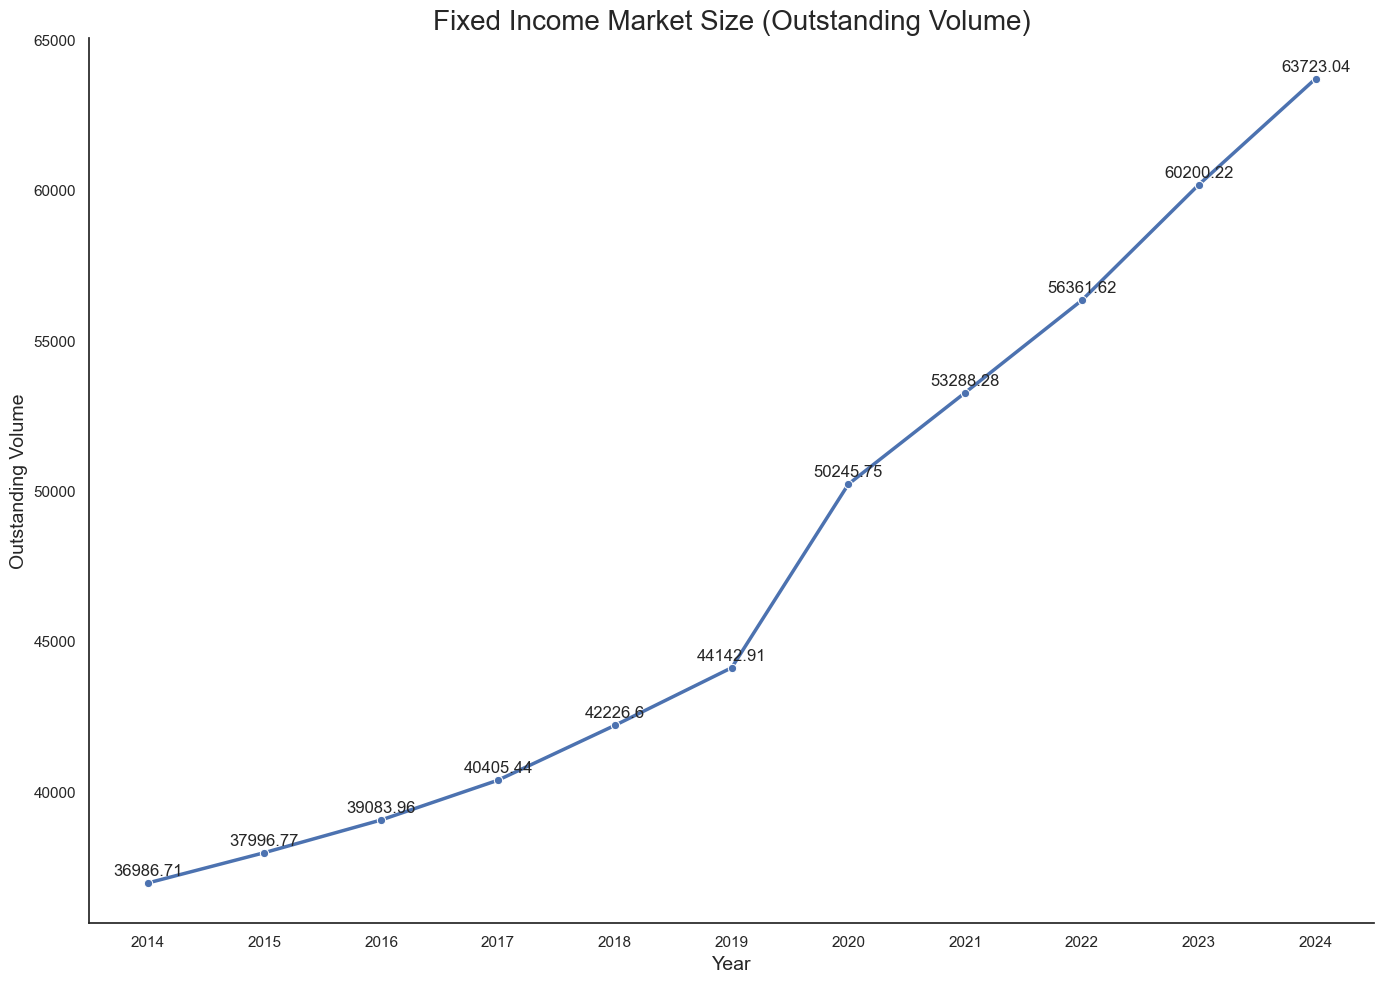

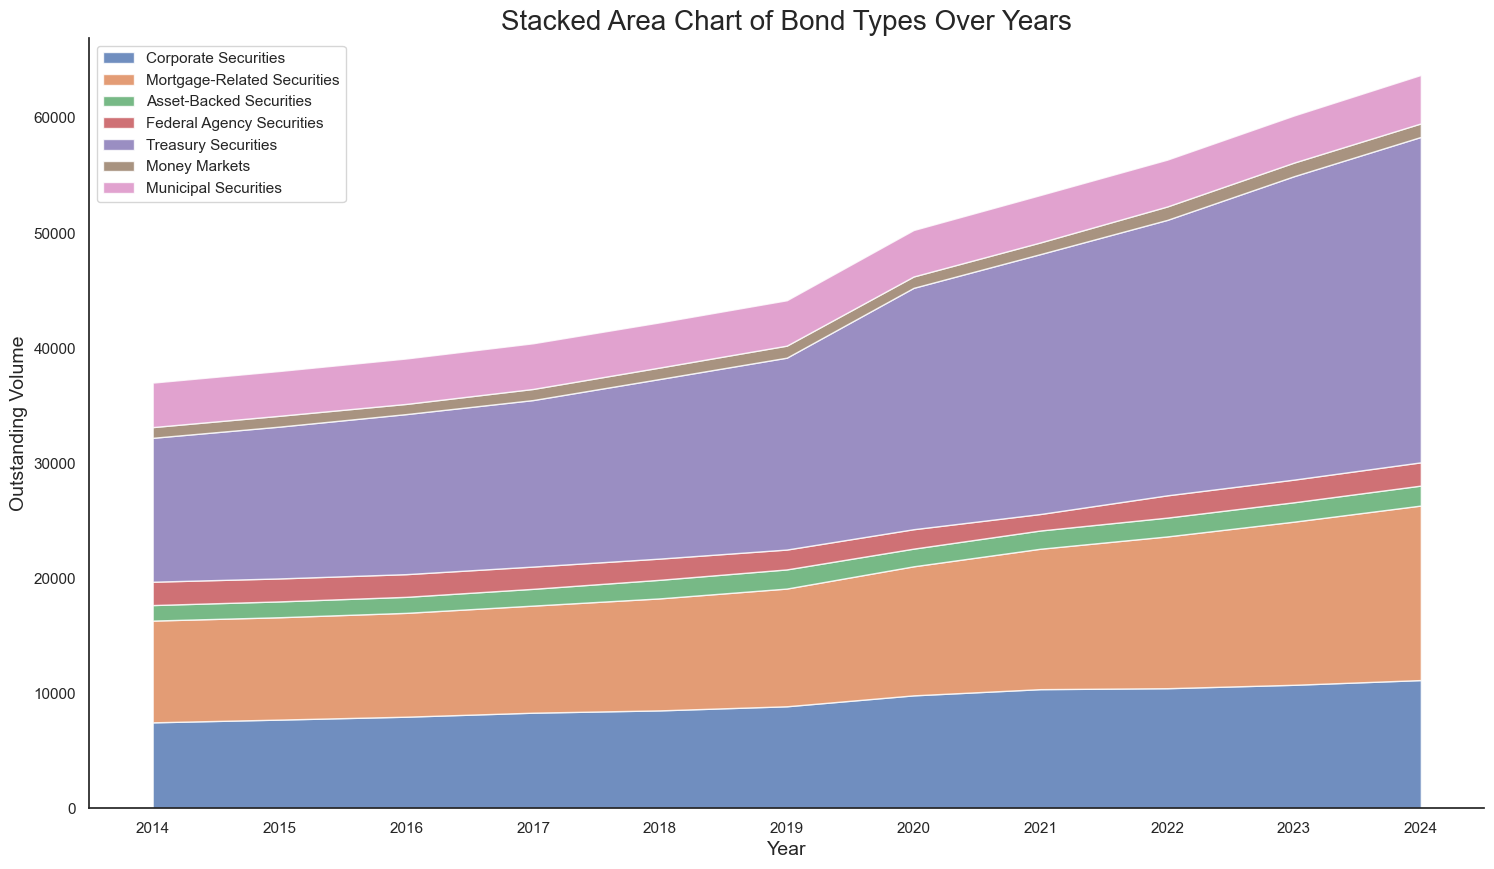

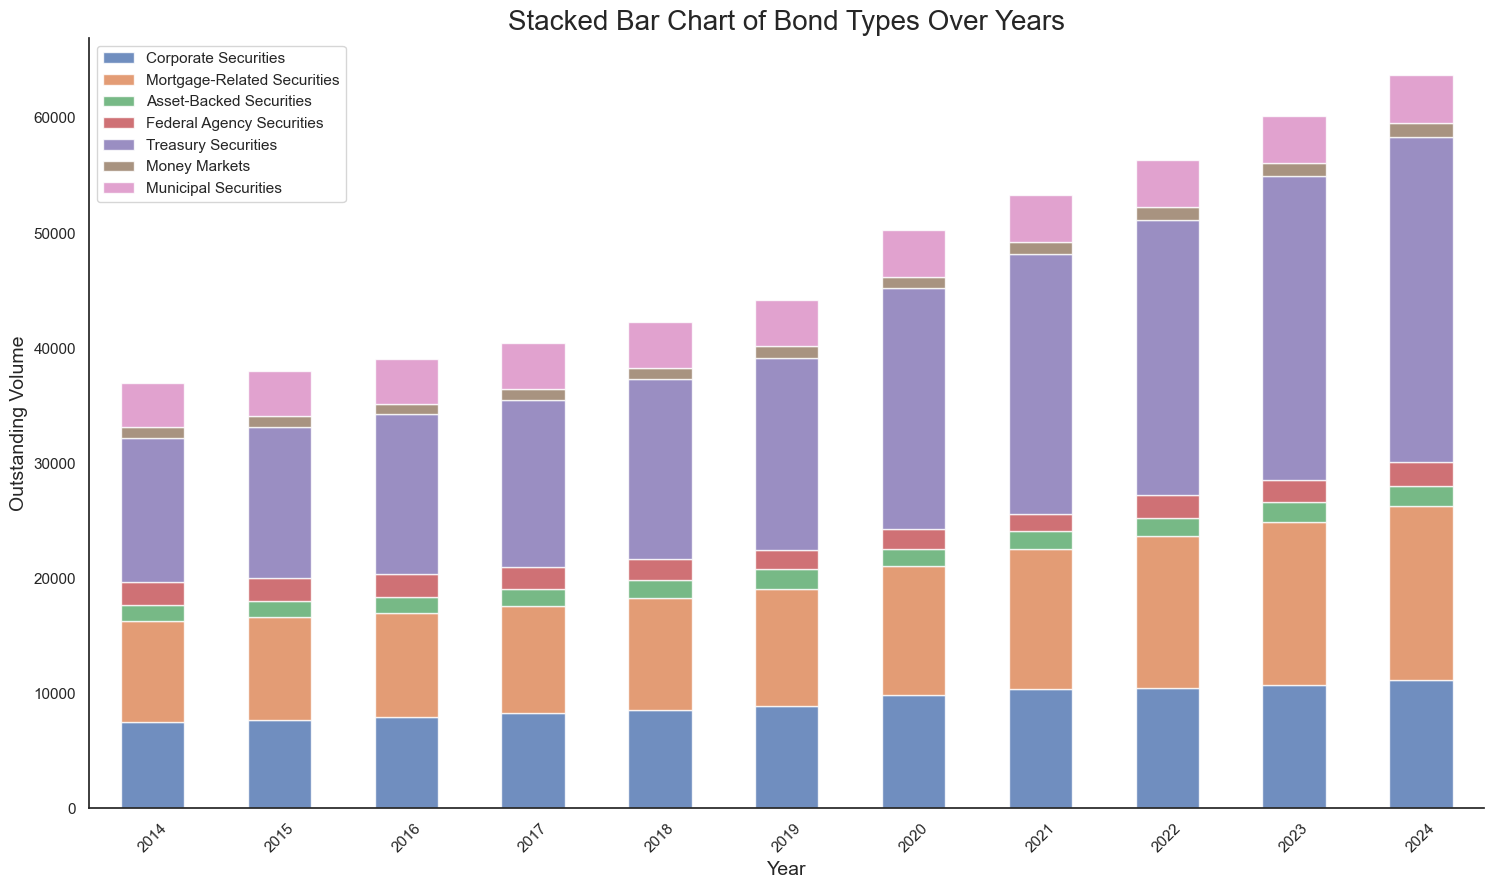

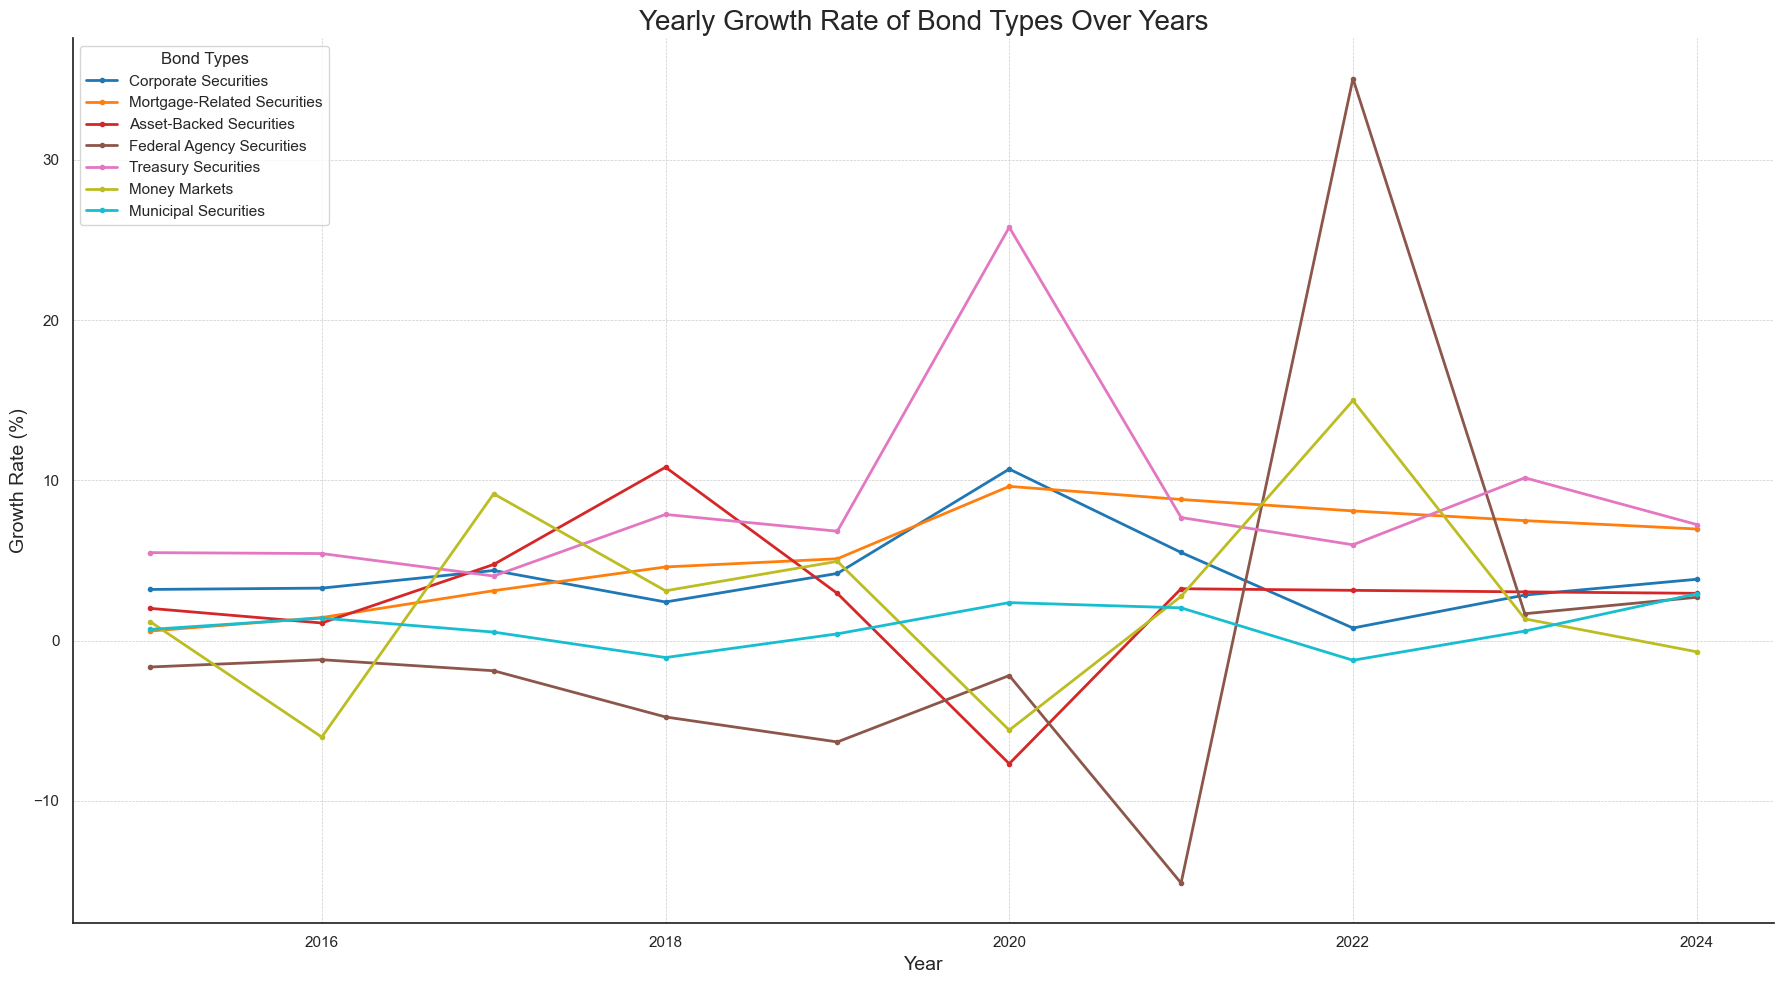

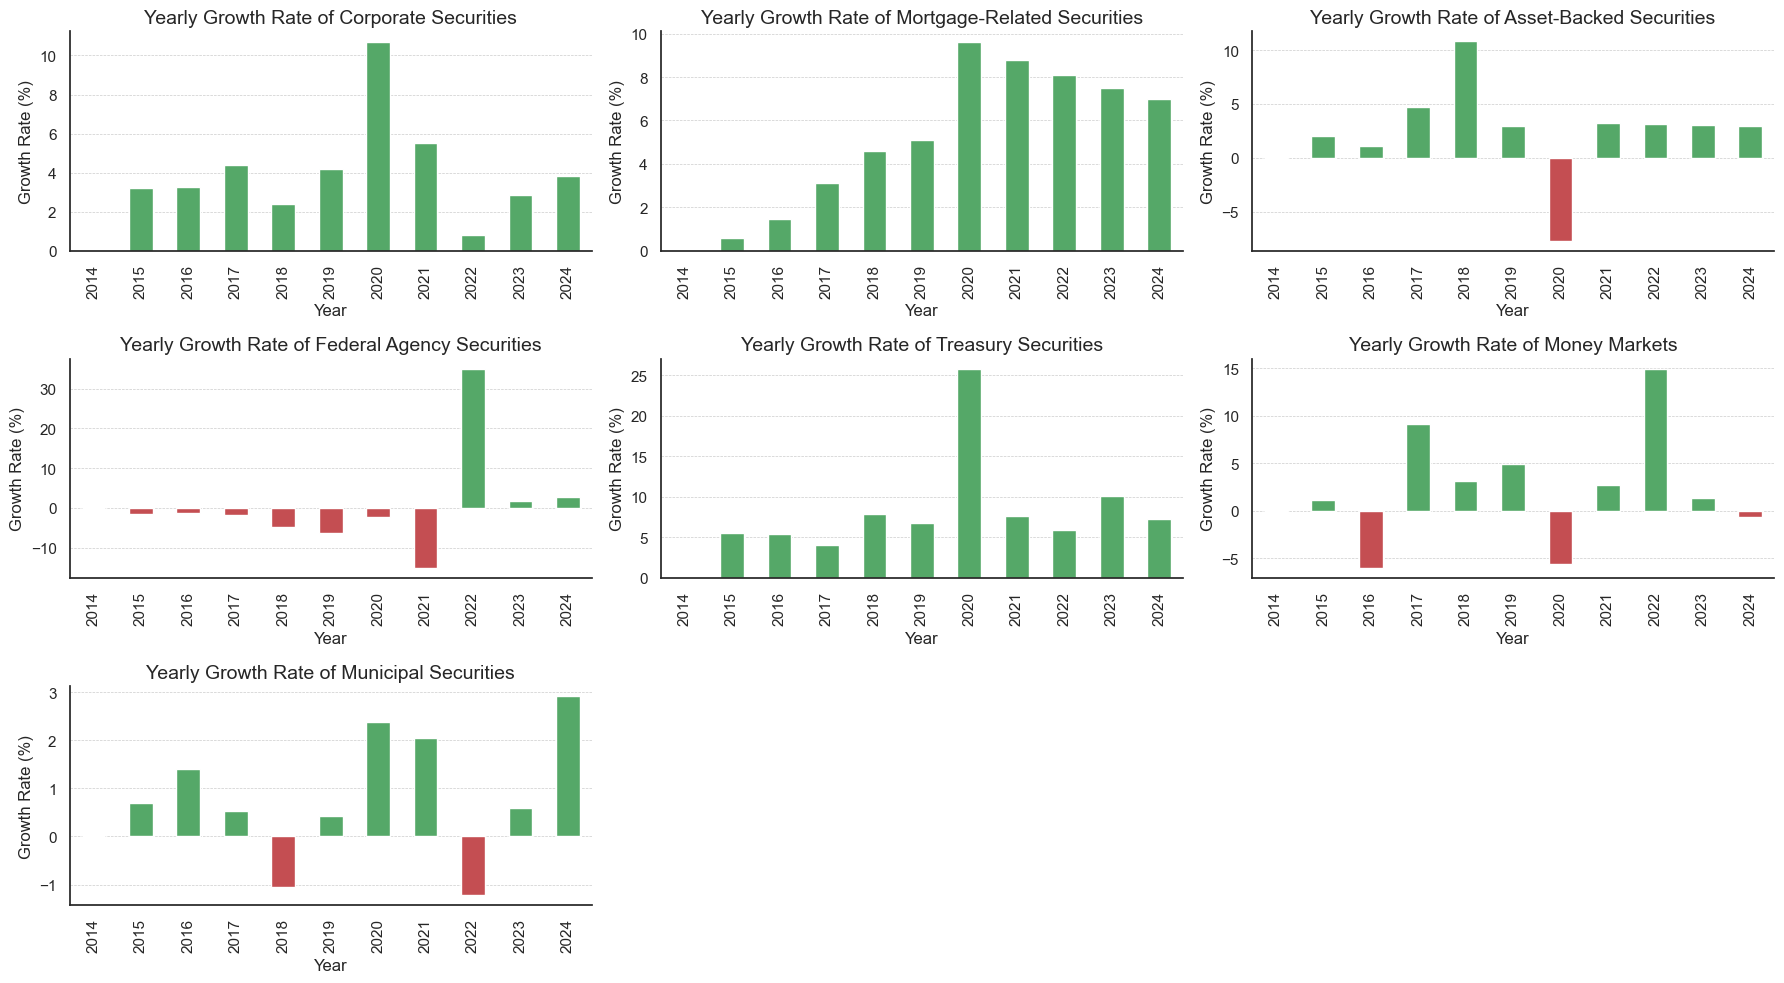

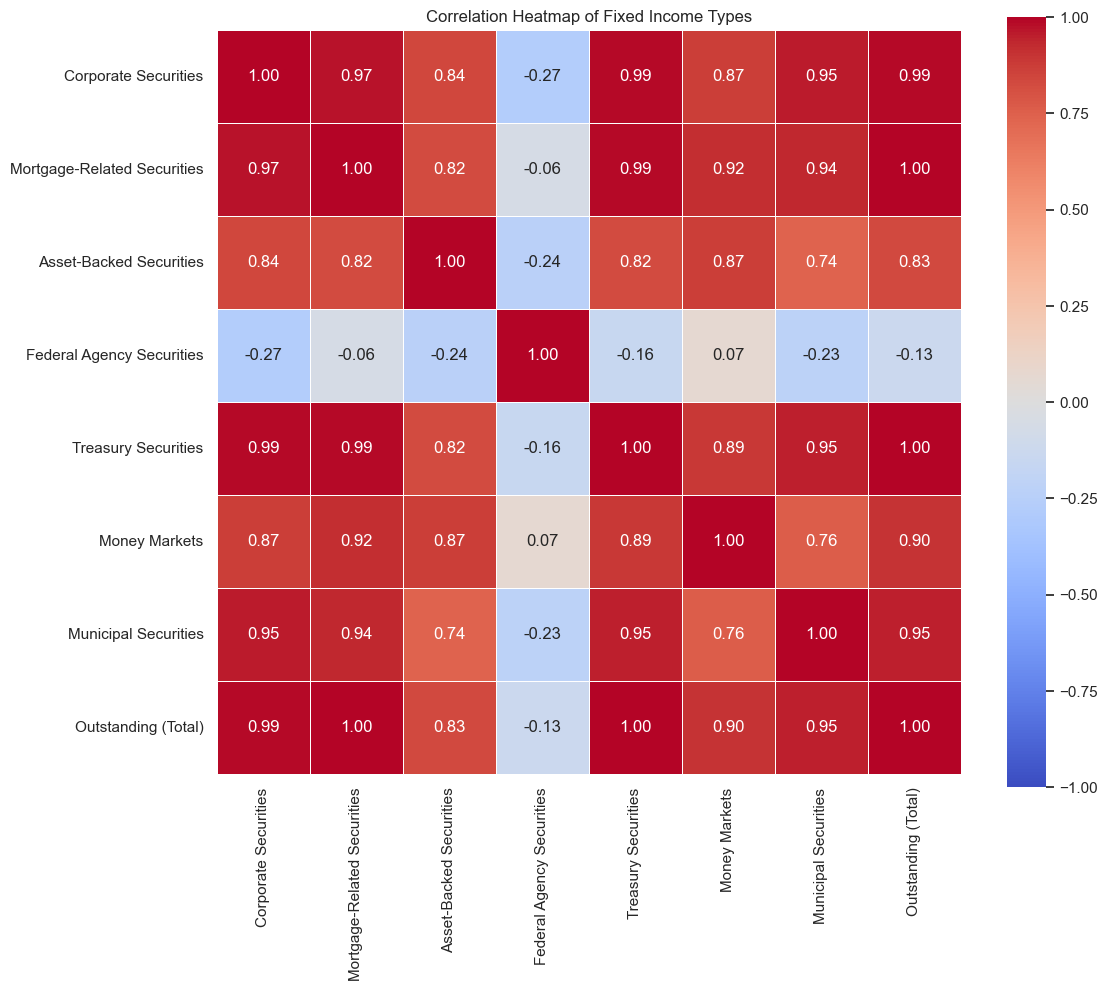

In [2]:
# Part 1: Fixed Income Market Analysis

# Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, 
                             roc_auc_score, 
                             average_precision_score)
from sklearn.model_selection import cross_val_score
import warnings
import time
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="distributed.utils_perf")
from multiprocessing import Pool
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from collections import Counter
import os
import re
import math


df_sifma_market = pd.read_excel(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\SIFMA\2025Q2\Market_size.xlsx")
df_sifma_issu = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\SIFMA\2025Q2\cleaned_sifma_issuance_2025Q2.csv")
df_sifma_trade = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\SIFMA\2025Q2\cleaned_sifma_trading_volume_2025Q2.csv")
df_gdp = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\Macro\GDP.csv")
df_recession = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\Macro\GDP-based Recession index.csv")
df_cpi = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\Macro\cpi.csv")
df_YC = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\Macro\T10Y2Y.csv")
df_housing_price = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\Macro\fmhpi_master_file.csv")
df_unemployment = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\Macro\UNRATE.csv")


#Visualization
# Set the style of the visualization
sns.set(style="white")

# Create a color palette
palette = sns.color_palette("husl", 1)

# Set the figure size
plt.figure(figsize=(14, 10))

# Draw line plot with Seaborn and get the Axes object
ax = sns.lineplot(x='period', y='Outstanding (Total)', data=df_sifma_market, palette=palette, linewidth=2.5, marker='o')

# Add title and labels
ax.set_title('Fixed Income Market Size (Outstanding Volume)', fontsize=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Outstanding Volume', fontsize=14)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate each data point with its value
for index, row in df_sifma_market.iterrows():
    ax.annotate(f"{round(row['Outstanding (Total)'],2)}", (row['period'], row['Outstanding (Total)']), textcoords="offset points", xytext=(0,5), ha='center')

# Set x-tickers to display all years
ax.set_xticks(df_sifma_market['period'].unique())  # Set x-ticks to match all dates in your DataFrame

# Show the plot
plt.tight_layout()
plt.show()




#Market Size - Aggregated by Fixed Income types - Stacked Area Chart
# Set the figure size
plt.figure(figsize=(18, 10))

# List of columns (excluding 'Year' and 'Total') to be used for the stacked area chart
columns = ['Corporate Securities', 'Mortgage-Related Securities',
       'Asset-Backed Securities', 'Federal Agency Securities',
       'Treasury Securities', 'Money Markets', 'Municipal Securities']

# Plot stacked area chart
plt.stackplot(df_sifma_market['period'], *[df_sifma_market[col] for col in columns], labels=columns, alpha=0.8)

# Add title and labels
plt.title('Stacked Area Chart of Bond Types Over Years', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Outstanding Volume', fontsize=14)

# Add legend
plt.legend(loc='upper left')

# Remove top and right spines
ax = plt.gca()  # Get the current Axes instance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-tickers to display all years
ax.set_xticks(df_sifma_market['period'])  # Set x-ticks to match all years in your DataFrame


# Show the plot
plt.show()



#Market Size - Aggregated by Fixed Income types - Stacked Bar Chart

# Set the figure size
plt.figure(figsize=(18, 10))

# List of columns (excluding 'Year' and 'Total') to be used for the stacked area chart
columns = ['Corporate Securities', 'Mortgage-Related Securities',
       'Asset-Backed Securities', 'Federal Agency Securities',
       'Treasury Securities', 'Money Markets', 'Municipal Securities']

# Plot stacked bar chart
df_sifma_market.set_index('period')[columns].plot(kind='bar', stacked=True, figsize=(18, 10), alpha=0.8, ax=plt.gca())

# Add title and labels
plt.title('Stacked Bar Chart of Bond Types Over Years', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Outstanding Volume', fontsize=14)

# Add legend
plt.legend(loc='upper left')

# Remove top and right spines
ax = plt.gca()  # Get the current Axes instance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-tickers to display all years
ax.set_xticks(range(len(df_sifma_market['period'])))  # Set x-ticks to match all years in your DataFrame
ax.set_xticklabels(df_sifma_market['period'], rotation=45)  # Set x-tick labels with rotation for better visibility

# Show the plot
plt.show()


#Growth Rate - Aggregated by Fixed Income types - Line Plot

# Set the figure size
plt.figure(figsize=(18, 10))

# Calculate year-on-year growth rates
df_growth_rates = df_sifma_market.set_index('period')[columns].pct_change() * 100  # Convert to percentage

# Plot line chart for growth rates
ax = df_growth_rates.plot(linewidth=2, marker='o', markersize=3, ax=plt.gca(), colormap='tab10')

# Add title and labels
ax.set_title('Yearly Growth Rate of Bond Types Over Years', fontsize=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Growth Rate (%)', fontsize=14)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(loc='upper left', title="Bond Types")

# Grid lines for better clarity
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


#Growth Rate - Aggregated by Fixed Income types - Separate Line Plots & Bar Charts

# Ensure dataframe is sorted by year/period
df_sifma_market = df_sifma_market.sort_values(by='period')

# Calculate year-on-year growth rates
df_growth_rates = df_sifma_market.set_index('period')[columns].pct_change() * 100  # Convert to percentage

# Set the figure size
plt.figure(figsize=(18, 10))

# Plot each bond type as a separate subplot
for i, col in enumerate(columns):
    ax = plt.subplot(3, 3, i+1)
    
    # Determine colors for each bar based on positive or negative growth rate
    colors = ['g' if val > 0 else 'r' for val in df_growth_rates[col]]
    
    # Bar plot
    df_growth_rates[col].plot(kind='bar', ax=ax, color=colors)
    
    # Set title and labels
    ax.set_title(f'Yearly Growth Rate of {col}', fontsize=14)
    ax.set_ylabel('Growth Rate (%)')
    ax.set_xlabel('Year')
    
    # Grid lines for better clarity
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()



#Correlation Heatmap - Fixed Income Market - Aggregated by Bond Types

# Calculate correlation matrix
corr_matrix = df_sifma_market.drop(columns=['period']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=.5)

# Set plot title
plt.title('Correlation Heatmap of Fixed Income Types')

# Show the plot
plt.show()

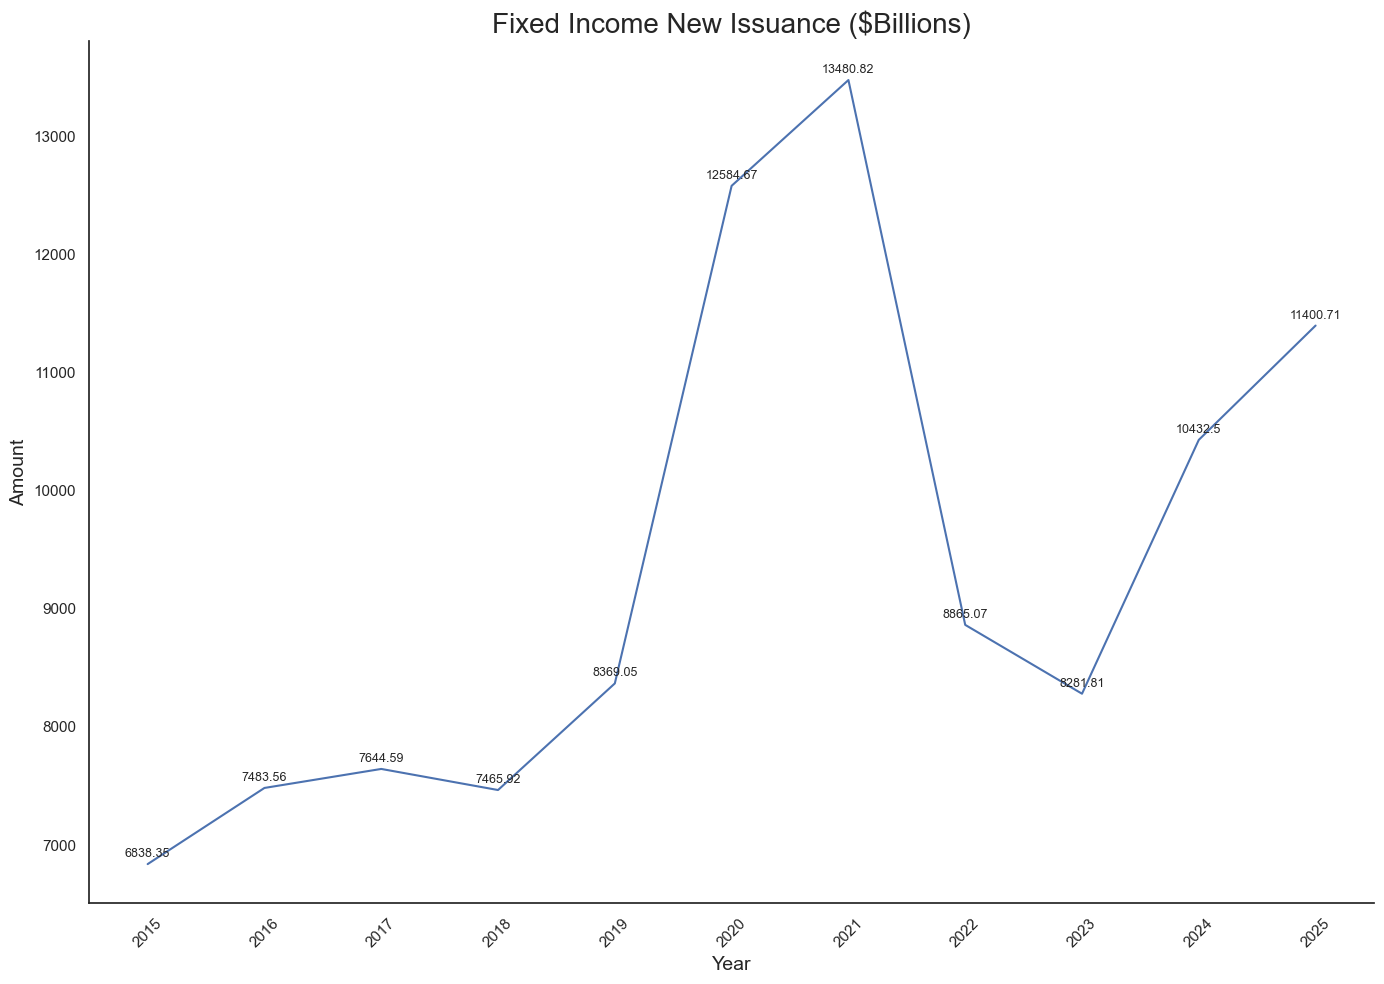

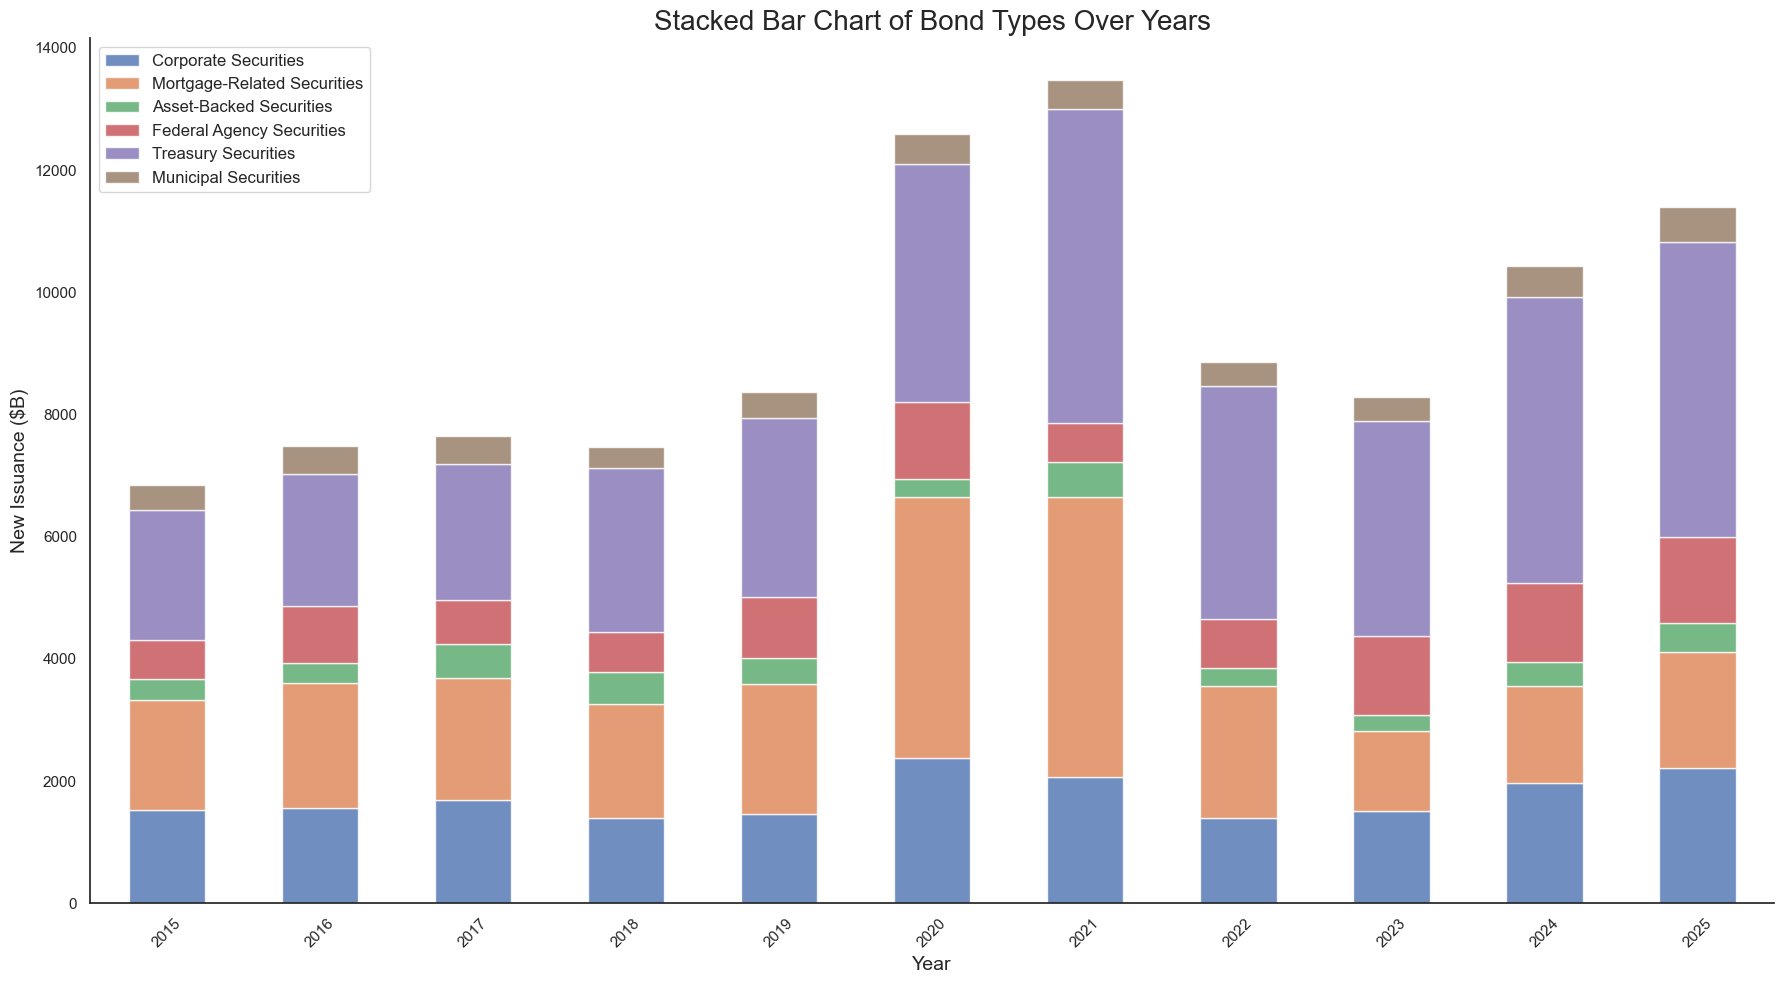

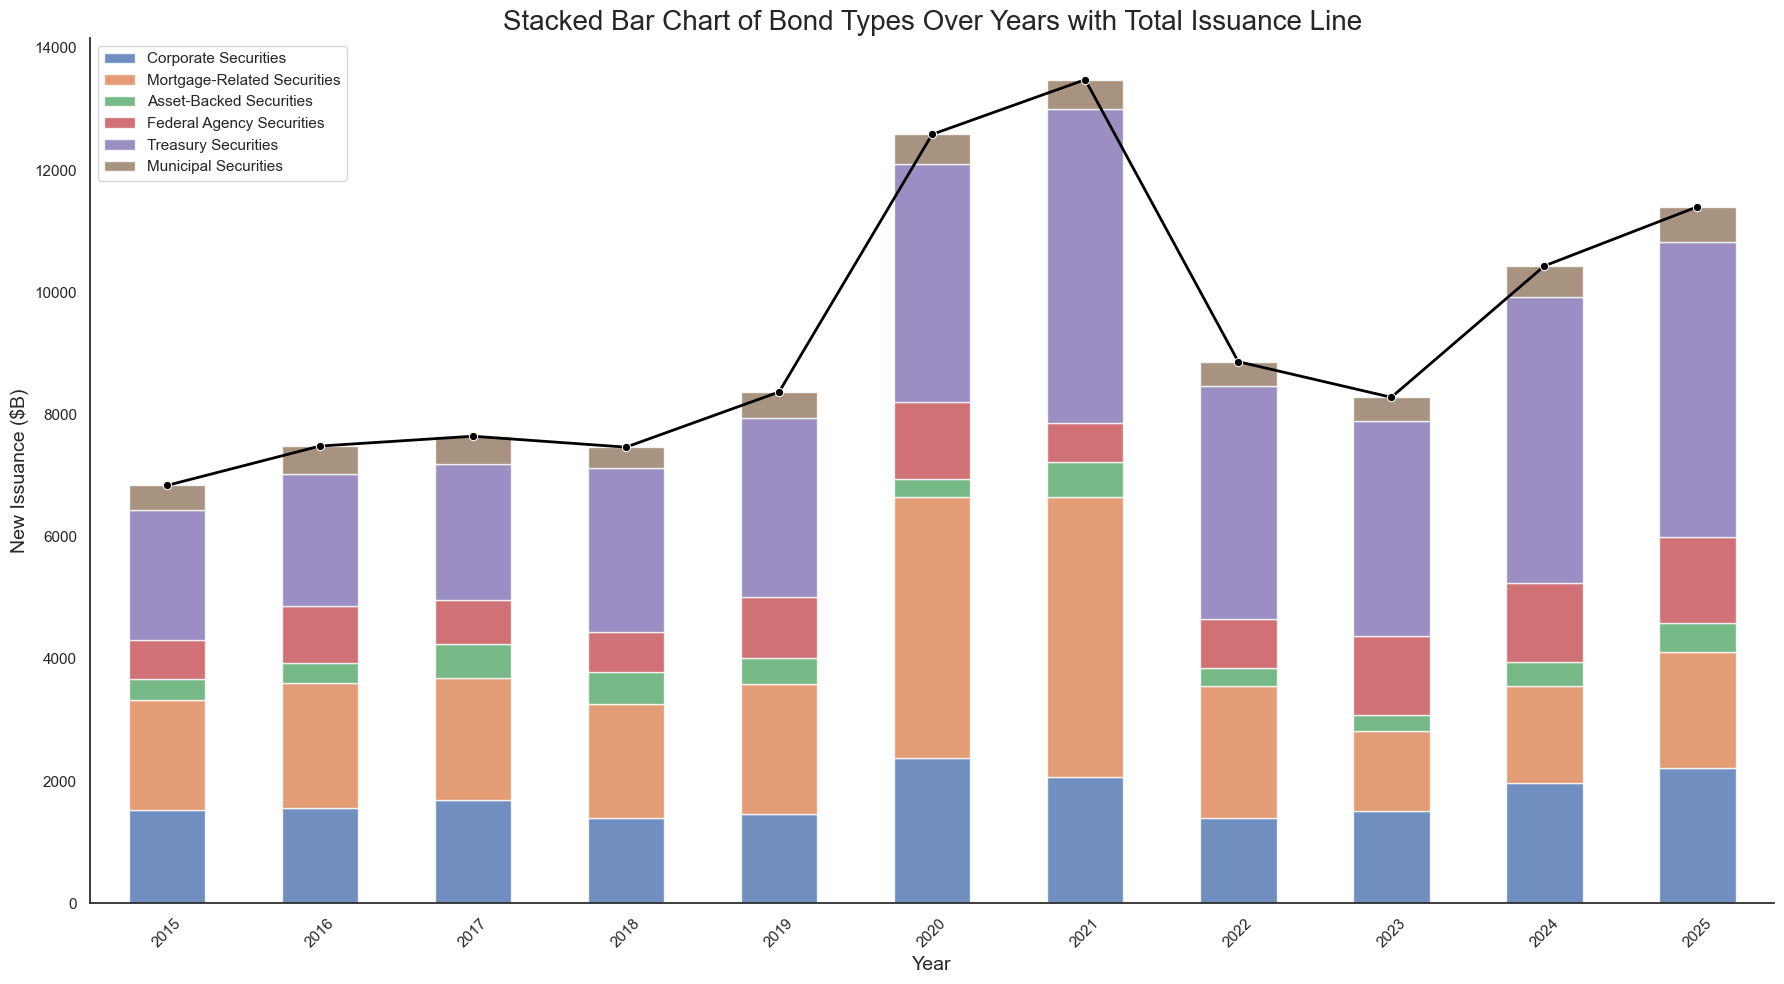

In [3]:
# Ensure period is int and no NaNs exist
df_sifma_issu = df_sifma_issu.rename(columns={'Year': 'period'})
df_sifma_issu = df_sifma_issu.dropna(subset=['period', 'Issuance (Total)'])
df_sifma_issu['period'] = df_sifma_issu['period'].astype(int)

# Set seaborn style
sns.set(style="white")

# Plot
plt.figure(figsize=(14, 10))
sns.lineplot(x='period', y='Issuance (Total)', data=df_sifma_issu)

# Format axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate values
for index, row in df_sifma_issu.iterrows():
    ax.annotate(f"{round(row['Issuance (Total)'], 2)}",
                (row['period'], row['Issuance (Total)']),
                textcoords="offset points", xytext=(0, 5),
                ha='center', fontsize=9)

# Labels and title
plt.title('Fixed Income New Issuance ($Billions)', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount', fontsize=14)

# Set integer x-ticks
ax.set_xticks(df_sifma_issu['period'].tolist())
ax.set_xticklabels(df_sifma_issu['period'].astype(str), rotation=45)

plt.tight_layout()
plt.show()




# List of columns for the stacked bar chart
columns = ['Corporate Securities', 'Mortgage-Related Securities',
           'Asset-Backed Securities', 'Federal Agency Securities',
           'Treasury Securities', 'Municipal Securities']

# Set up the figure and axes explicitly
fig, ax = plt.subplots(figsize=(18, 10))

# Plot the stacked bar chart on the specified Axes
df_sifma_issu.set_index('period')[columns].plot(
    kind='bar',
    stacked=True,
    alpha=0.8,
    ax=ax
)

# Title and axis labels
ax.set_title('Stacked Bar Chart of Bond Types Over Years', fontsize=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('New Issuance ($B)', fontsize=14)

# X-ticks and labels
ax.set_xticks(range(len(df_sifma_issu)))
ax.set_xticklabels(df_sifma_issu['period'], rotation=45)

# Legend
ax.legend(loc='upper left', fontsize=12)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()



#Issuance - Aggregation by Bond Types & Total - Line plot & Stacked Bar Chart
# Create a string version of the period for categorical x-axis
df_sifma_issu['Year_Str'] = df_sifma_issu['period'].astype(str)

# List of component columns for stacked bars
columns = ['Corporate Securities', 'Mortgage-Related Securities',
           'Asset-Backed Securities', 'Federal Agency Securities',
           'Treasury Securities', 'Municipal Securities']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(18, 10))

# Plot stacked bar chart
df_sifma_issu.set_index('Year_Str')[columns].plot(kind='bar', stacked=True, alpha=0.8, ax=ax)

# Plot total issuance as a line plot on same axis
sns.lineplot(x='Year_Str', y='Issuance (Total)', data=df_sifma_issu,
             color='black', linewidth=2, marker='o', ax=ax)

# Customize x-axis
ax.set_xticks(range(len(df_sifma_issu)))
ax.set_xticklabels(df_sifma_issu['Year_Str'], rotation=45)

# Add labels and title
ax.set_title('Stacked Bar Chart of Bond Types Over Years with Total Issuance Line', fontsize=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('New Issuance ($B)', fontsize=14)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(loc='upper left', fontsize=11)

# Tight layout
plt.tight_layout()

# Show plot
plt.show()

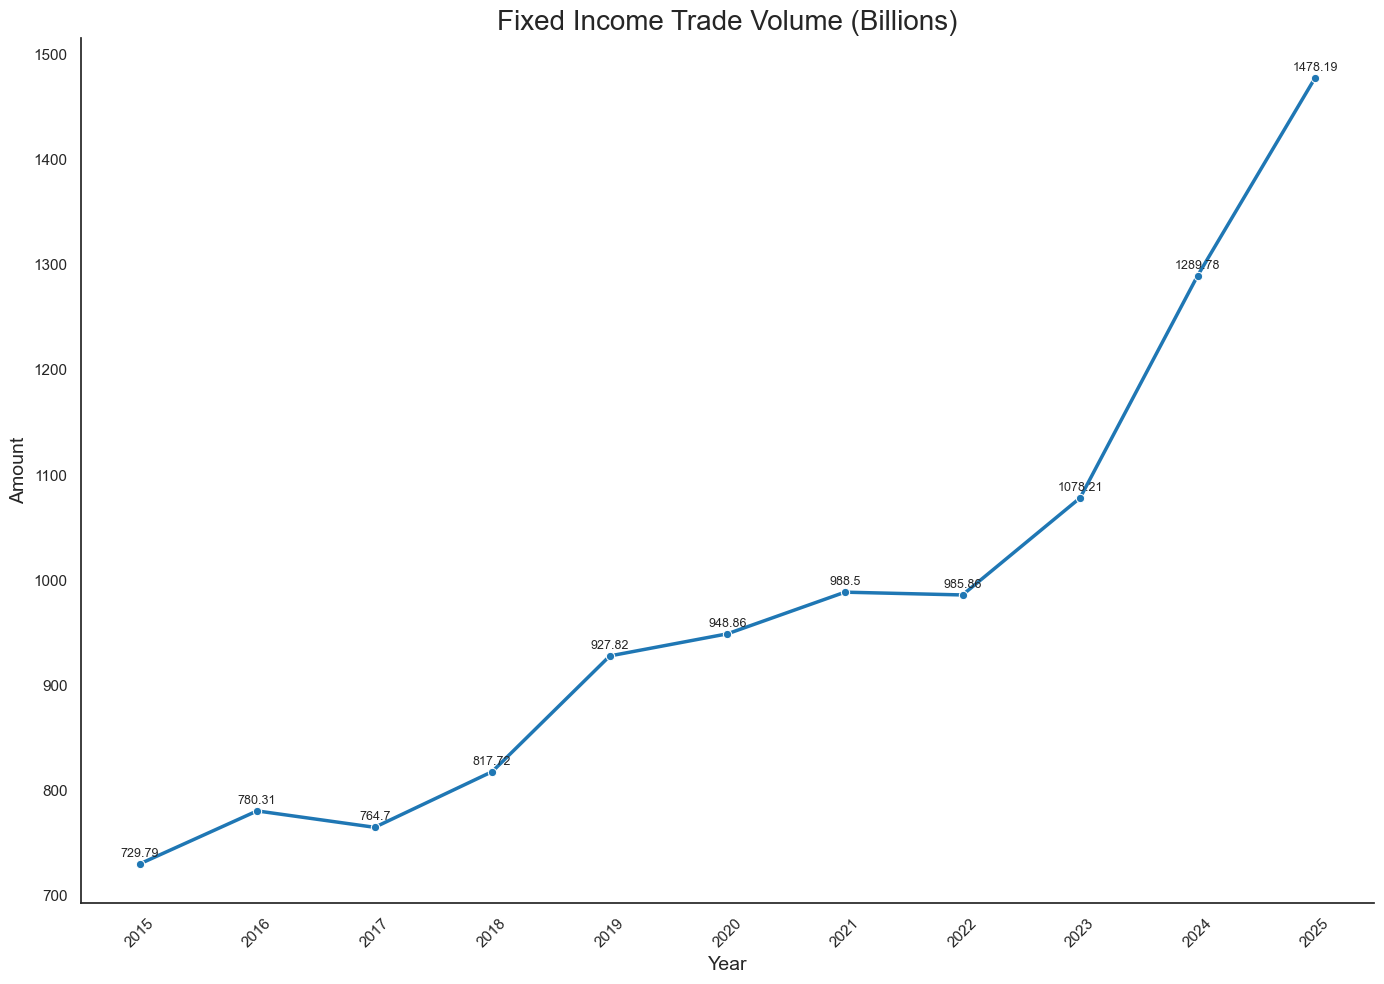

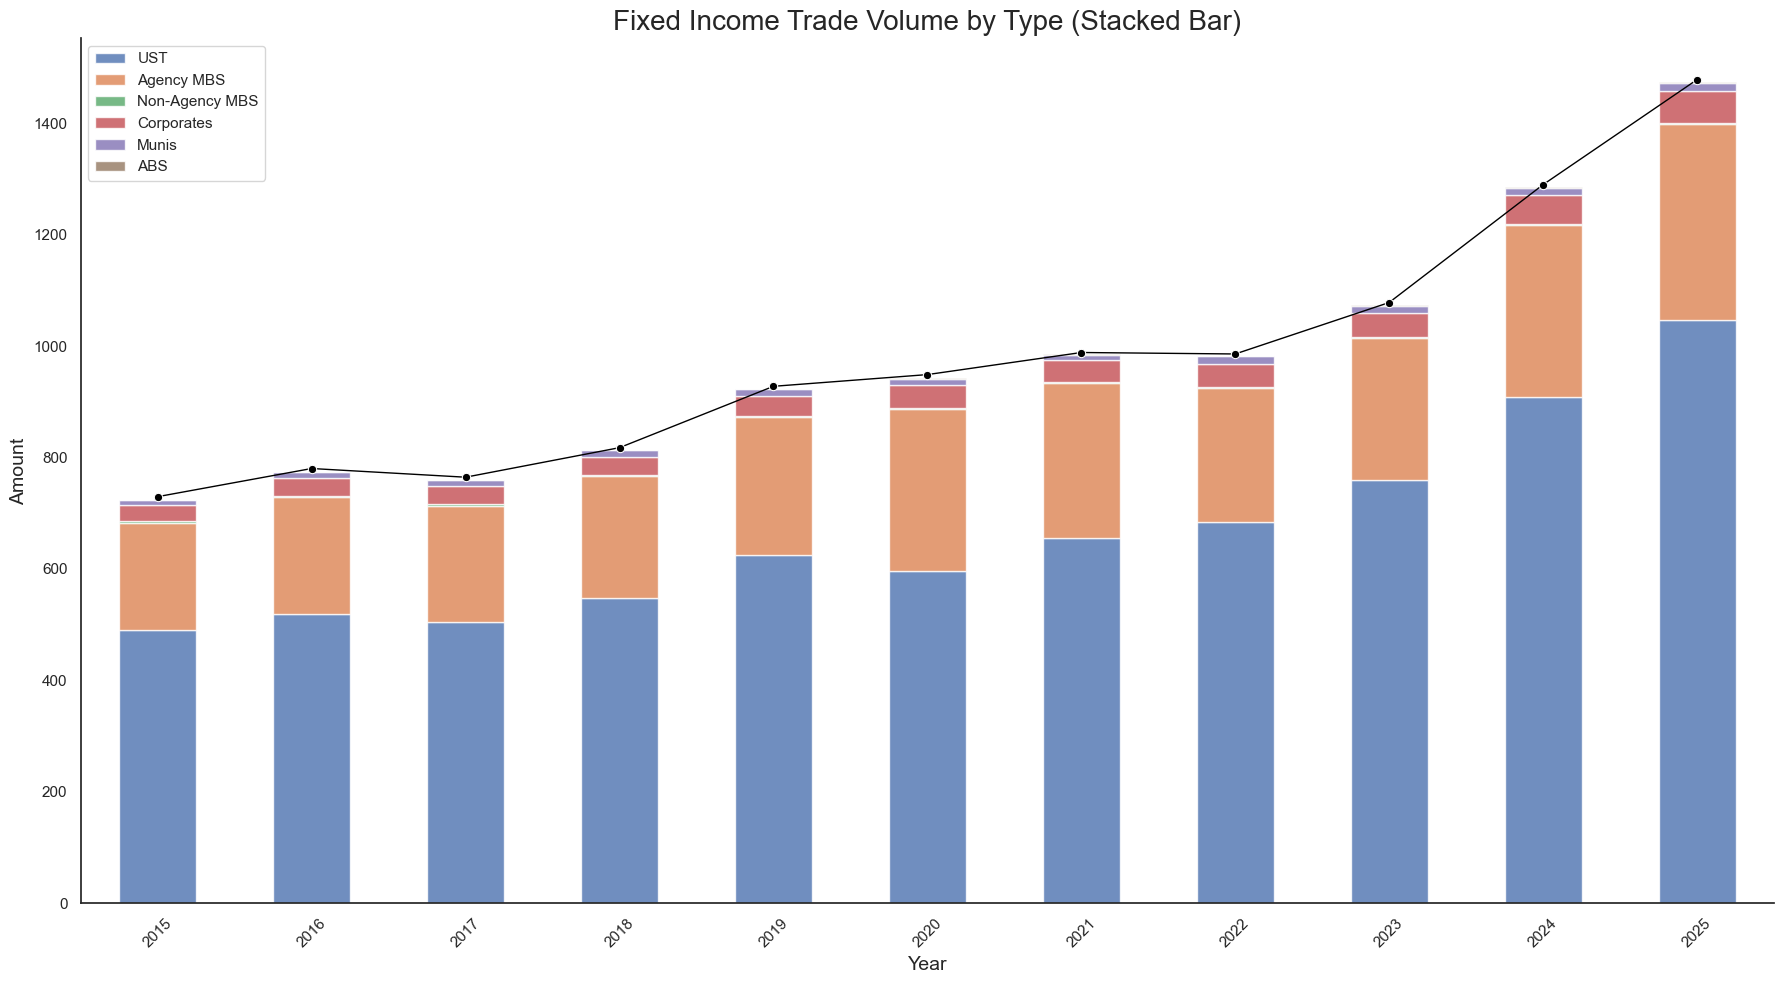

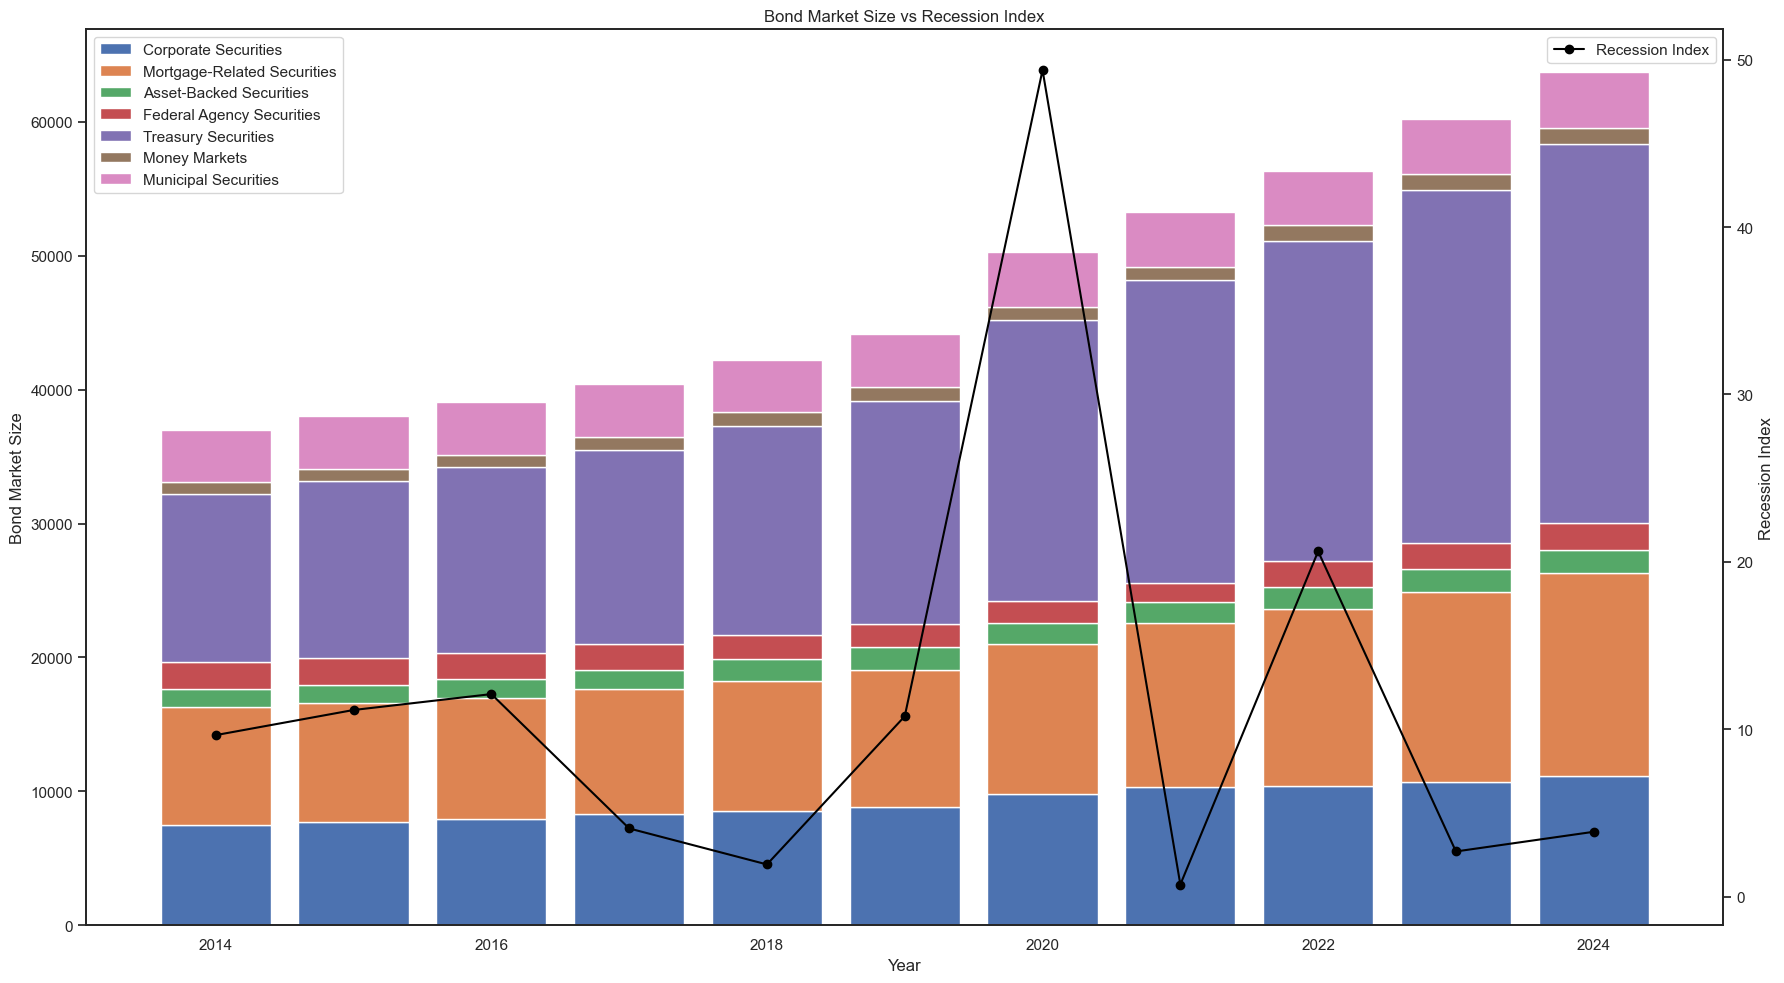

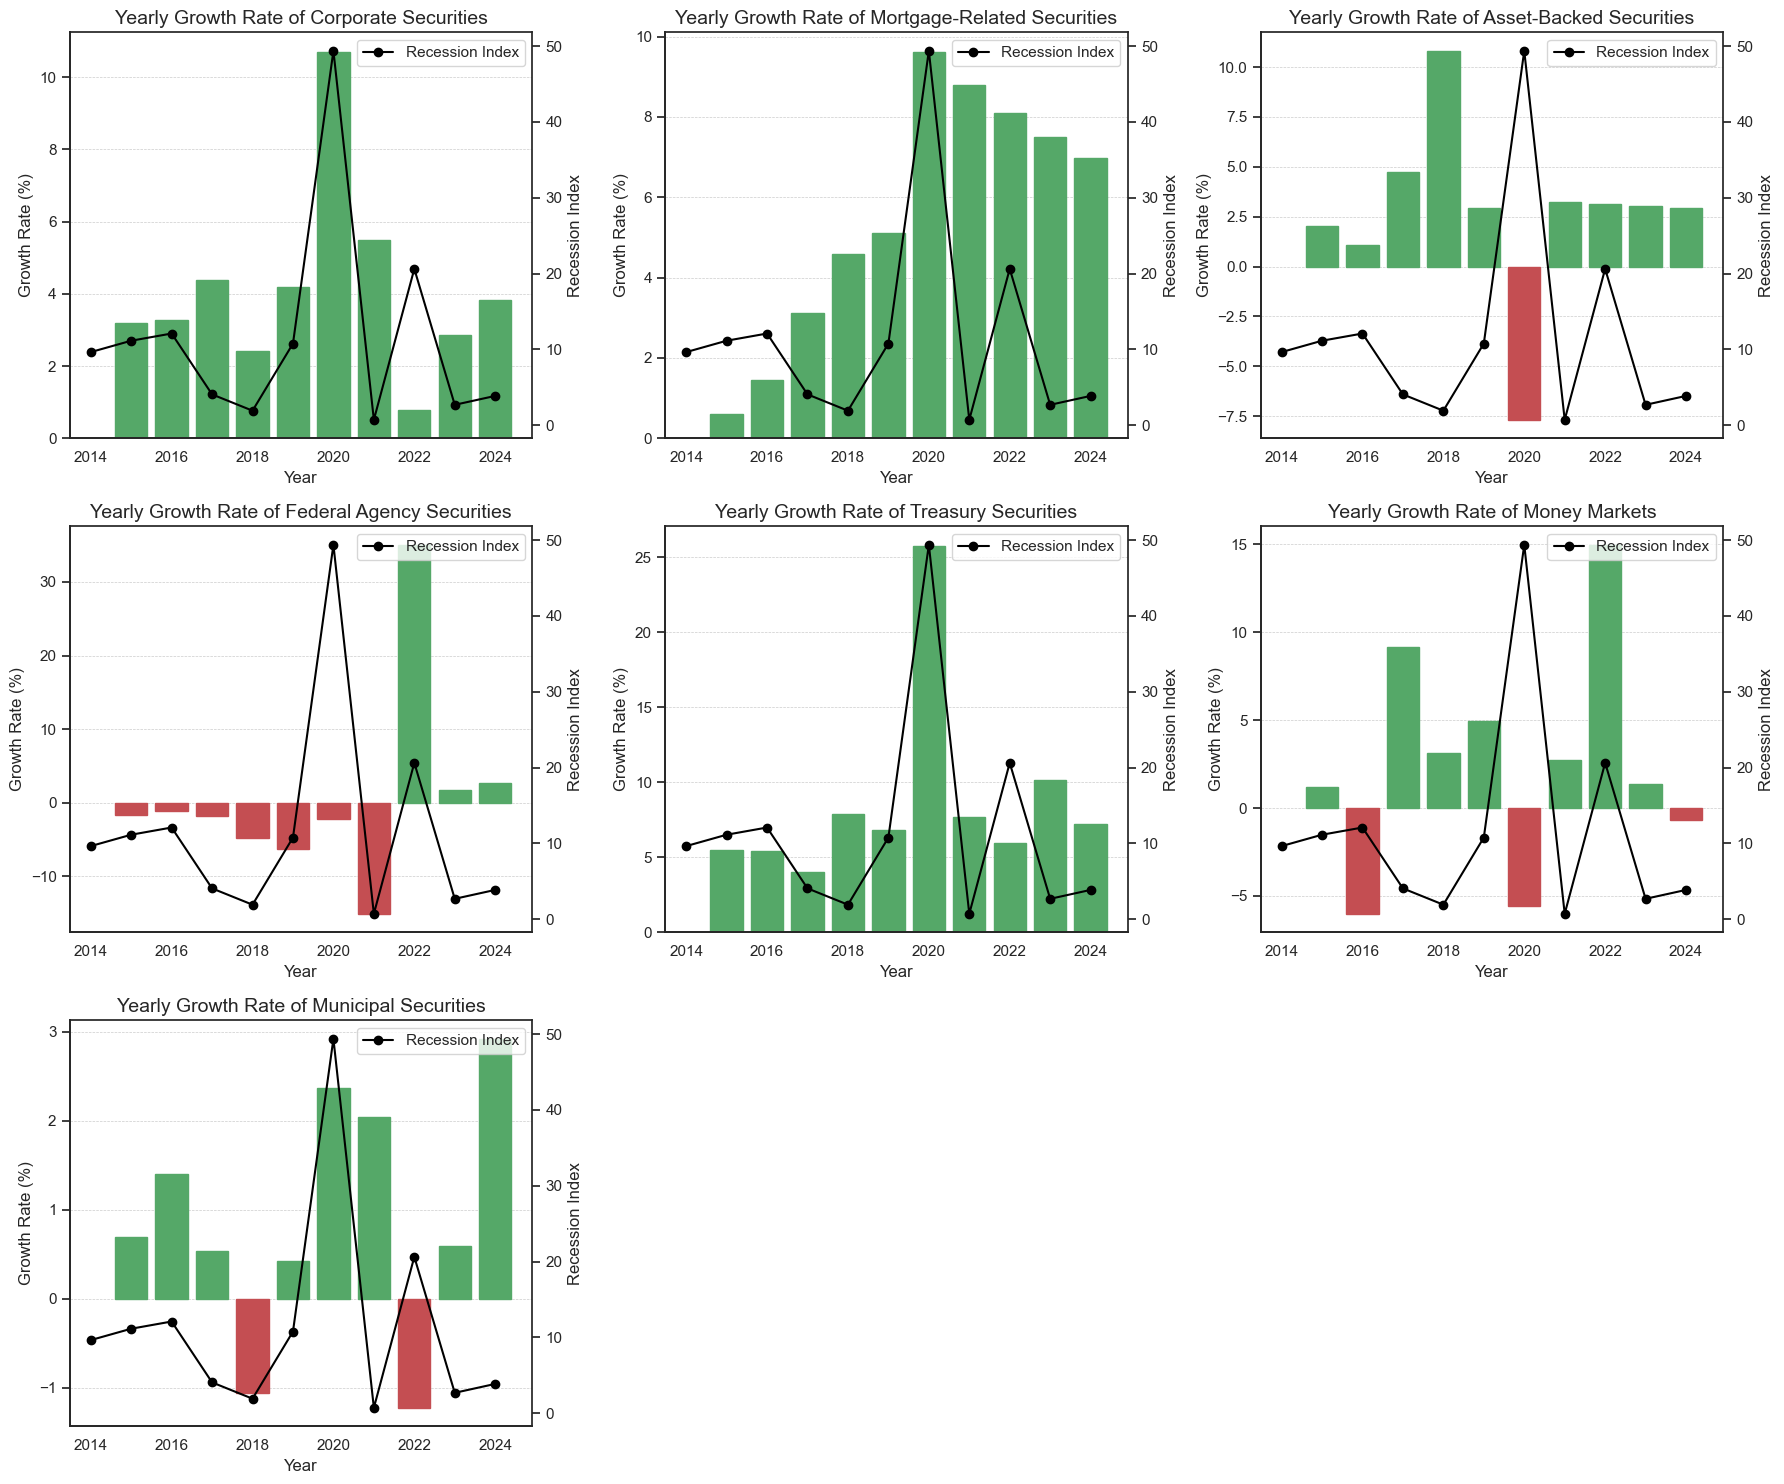

Bond Type  Pearson Correlation  Spearman Rank Correlation
0         Corporate Securities             0.668837                   0.030303
1  Mortgage-Related Securities             0.344345                  -0.006061
2      Asset-Backed Securities            -0.836724                  -0.696970
3    Federal Agency Securities             0.248919                   0.357576
4          Treasury Securities             0.822009                  -0.248485
5                Money Markets            -0.268702                  -0.200000
6         Municipal Securities             0.187656                  -0.006061

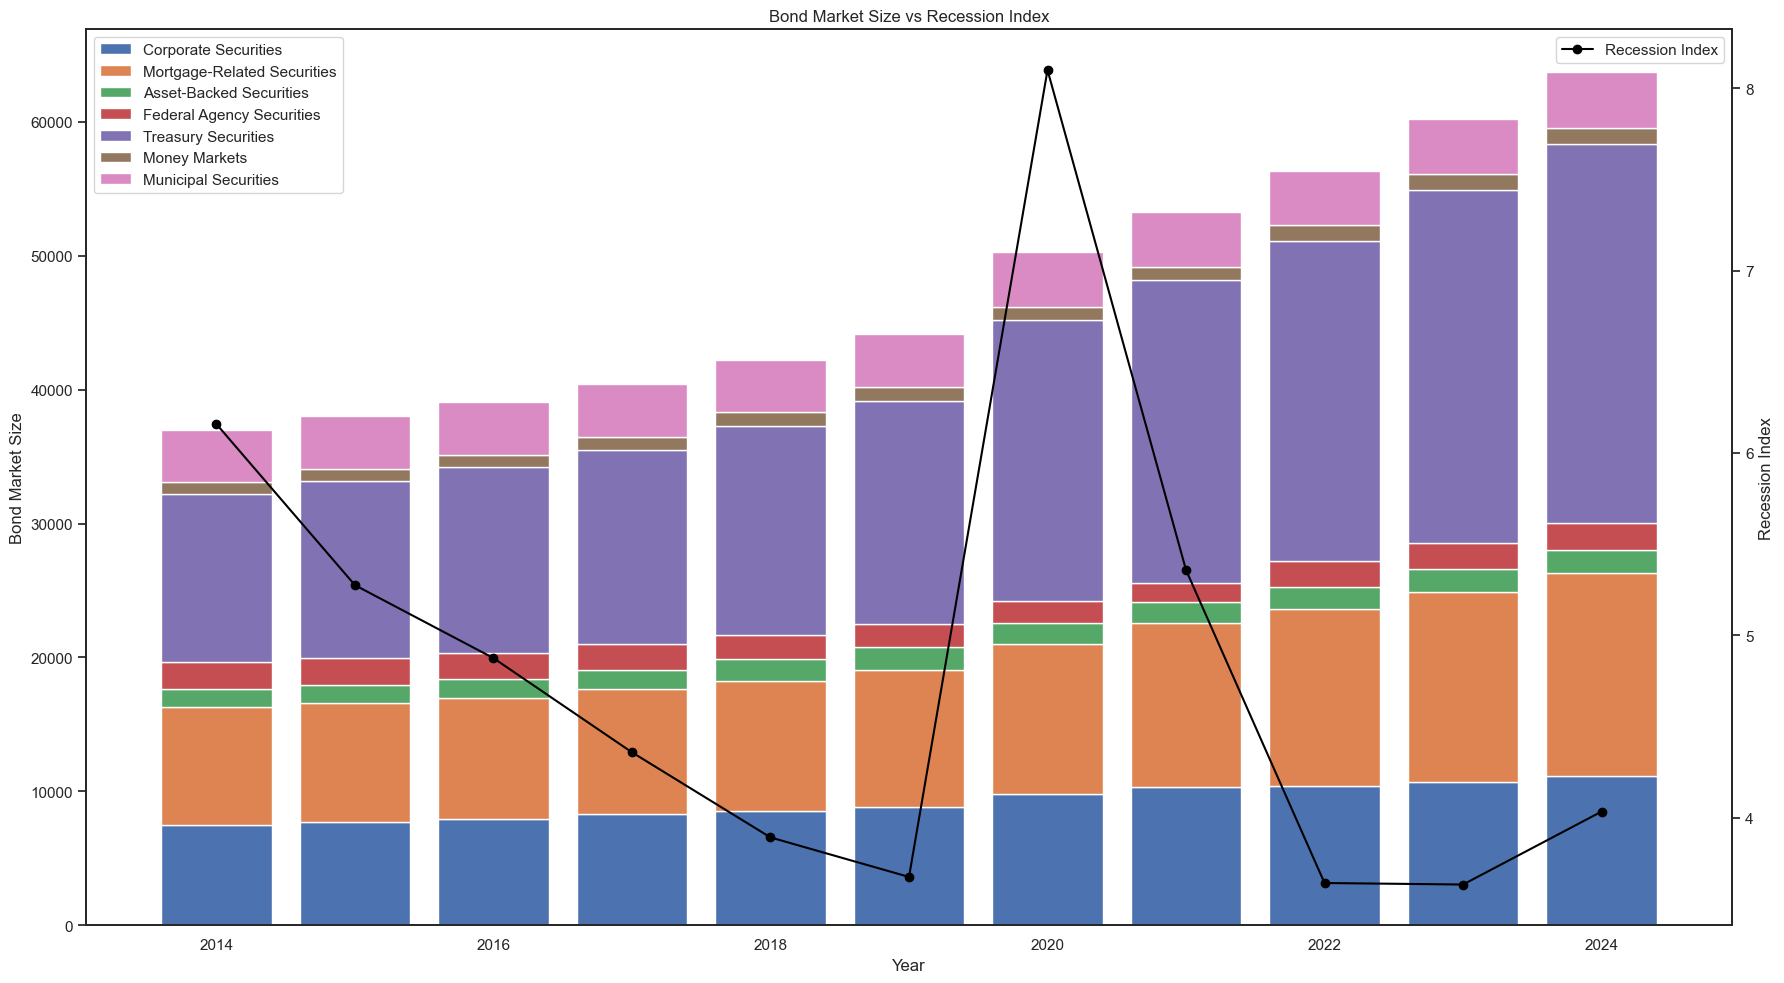

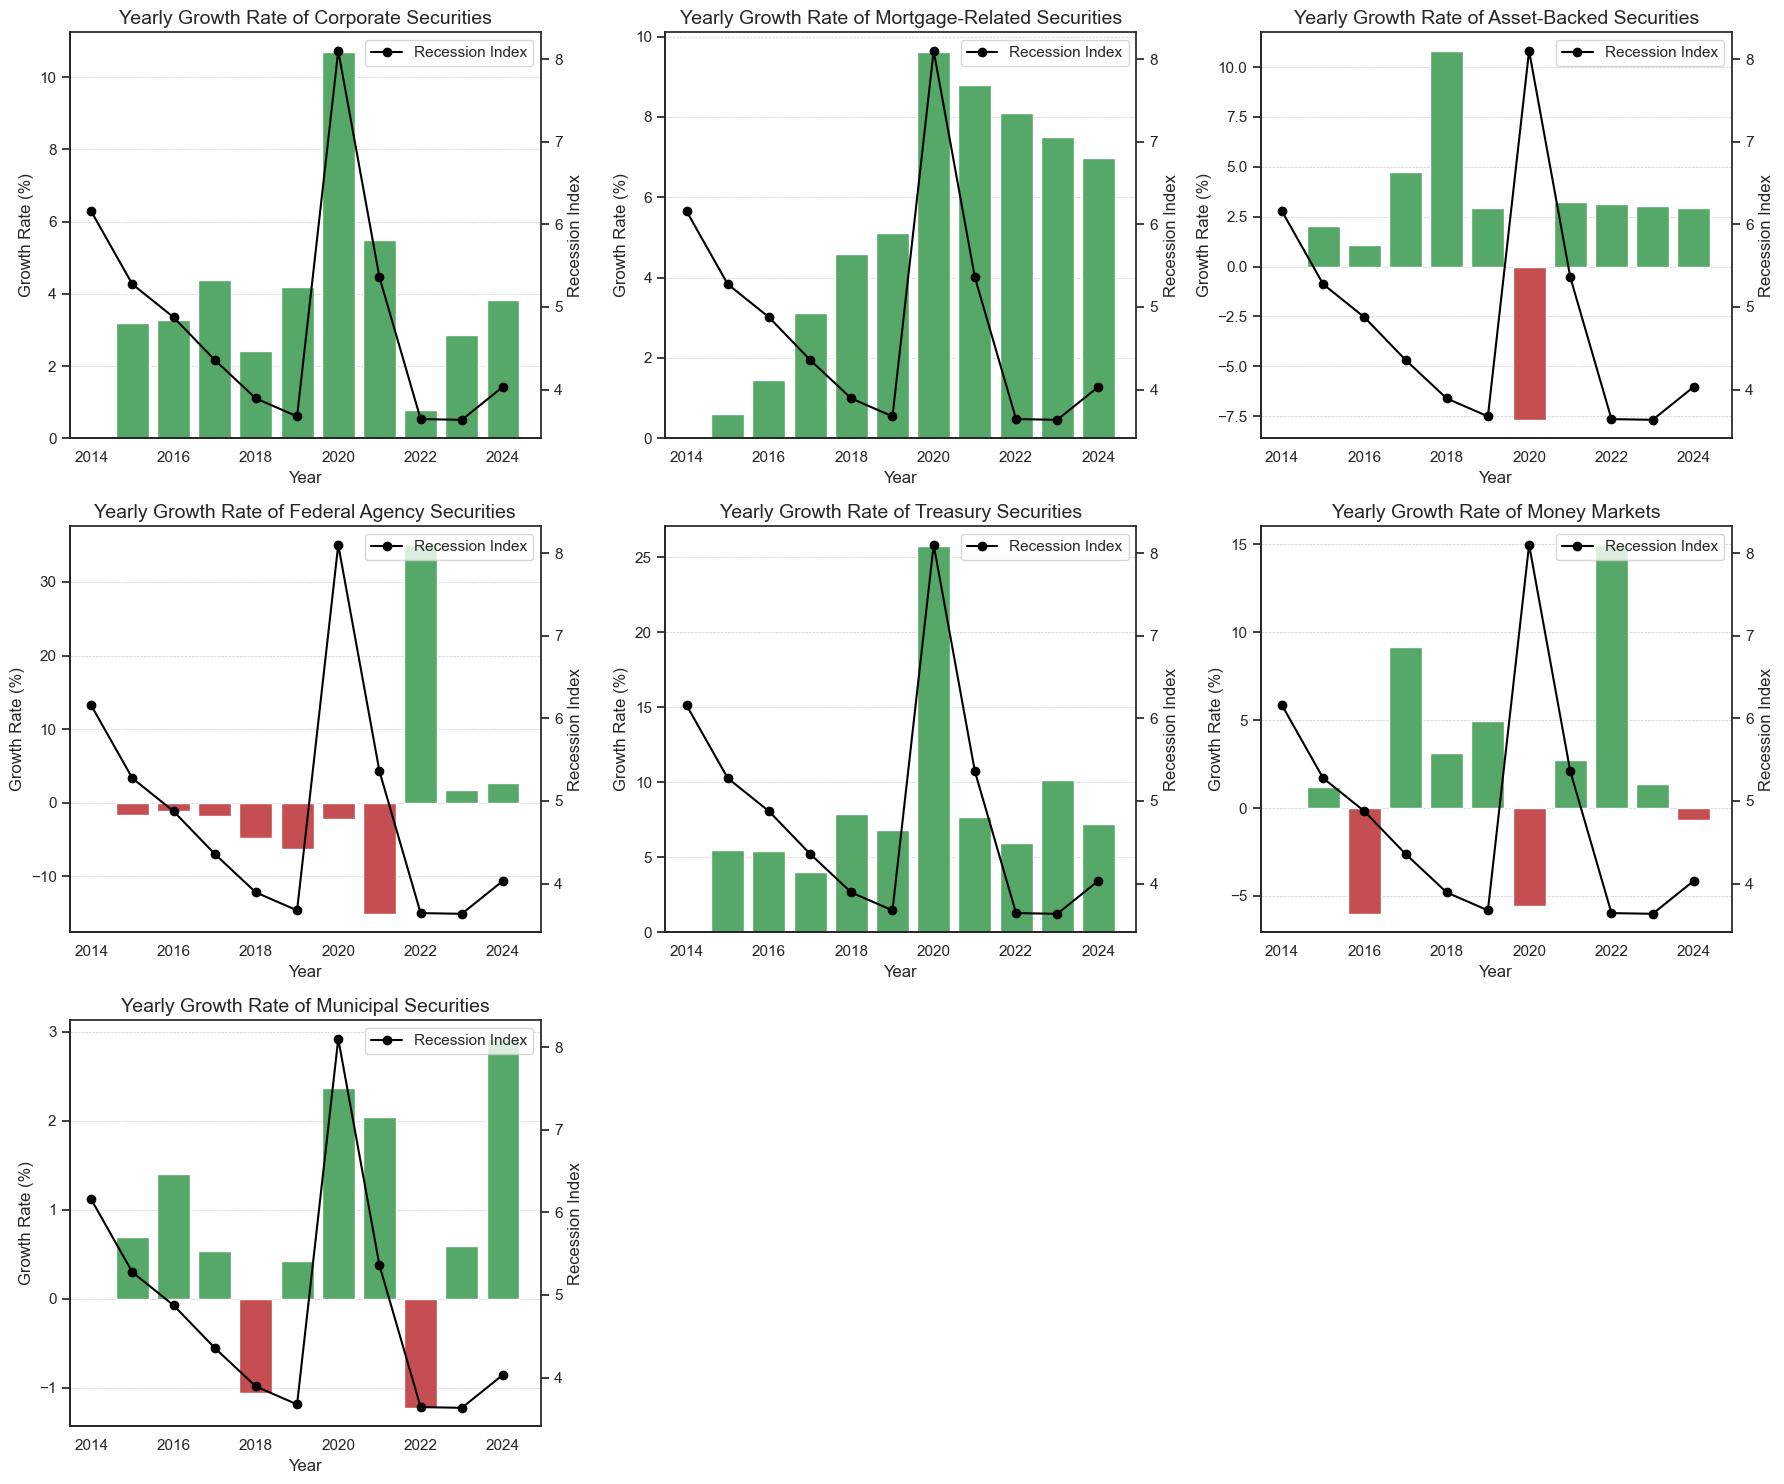

Bond Type  Pearson Correlation  Spearman Rank Correlation
0         Corporate Securities             0.889328                   0.696970
1  Mortgage-Related Securities             0.228246                   0.030303
2      Asset-Backed Securities            -0.797257                  -0.381818
3    Federal Agency Securities            -0.298724                  -0.430303
4          Treasury Securities             0.798133                  -0.018182
5                Money Markets            -0.575230                  -0.527273
6         Municipal Securities             0.545693                   0.660606

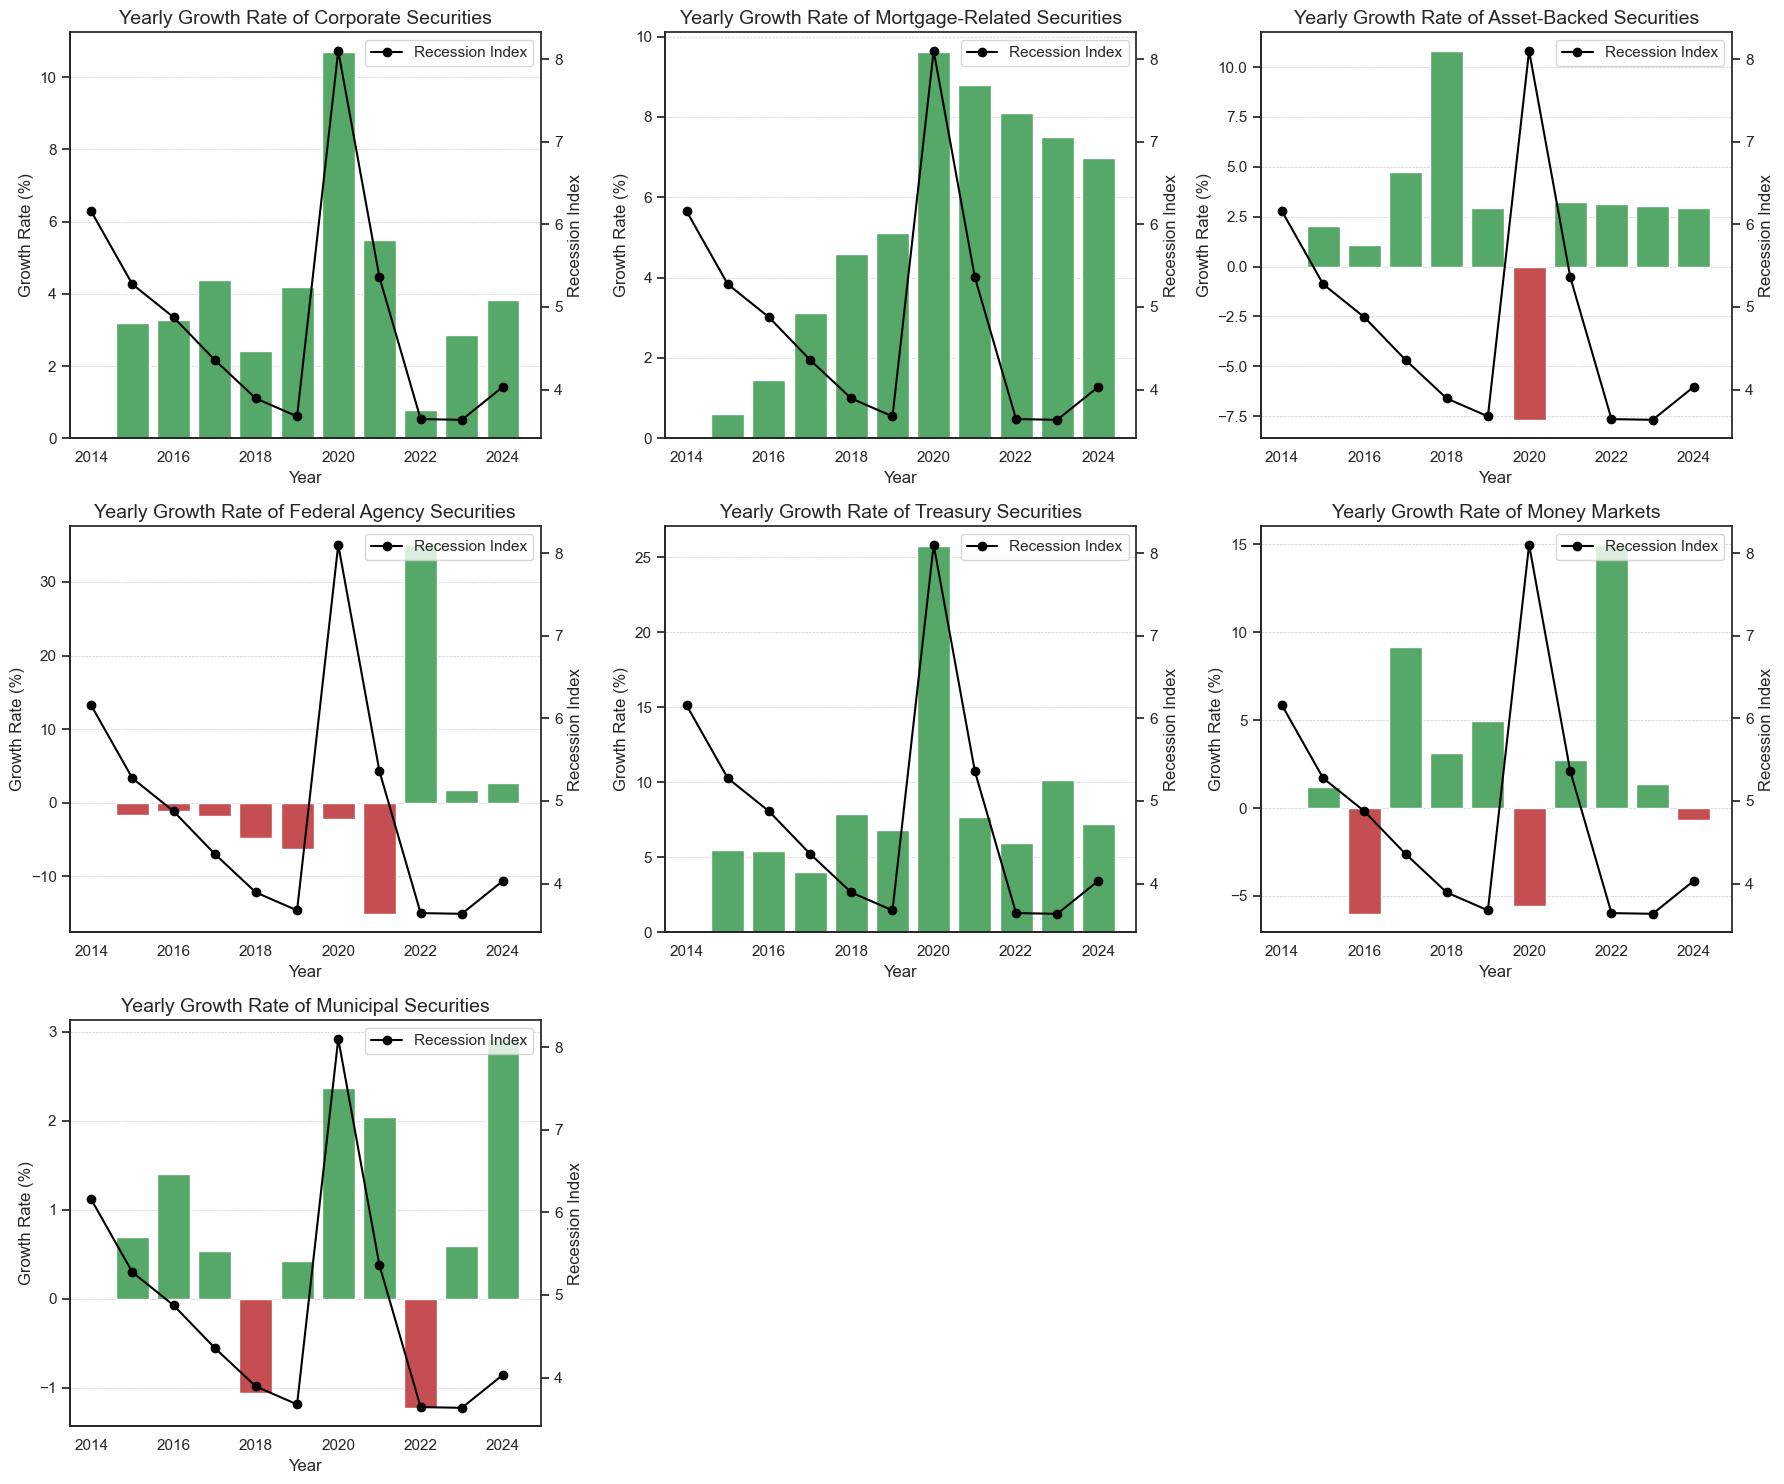

Bond Type  Pearson Correlation  Spearman Rank Correlation
0         Corporate Securities             0.889328                   0.696970
1  Mortgage-Related Securities             0.228246                   0.030303
2      Asset-Backed Securities            -0.797257                  -0.381818
3    Federal Agency Securities            -0.298724                  -0.430303
4          Treasury Securities             0.798133                  -0.018182
5                Money Markets            -0.575230                  -0.527273
6         Municipal Securities             0.545693                   0.660606

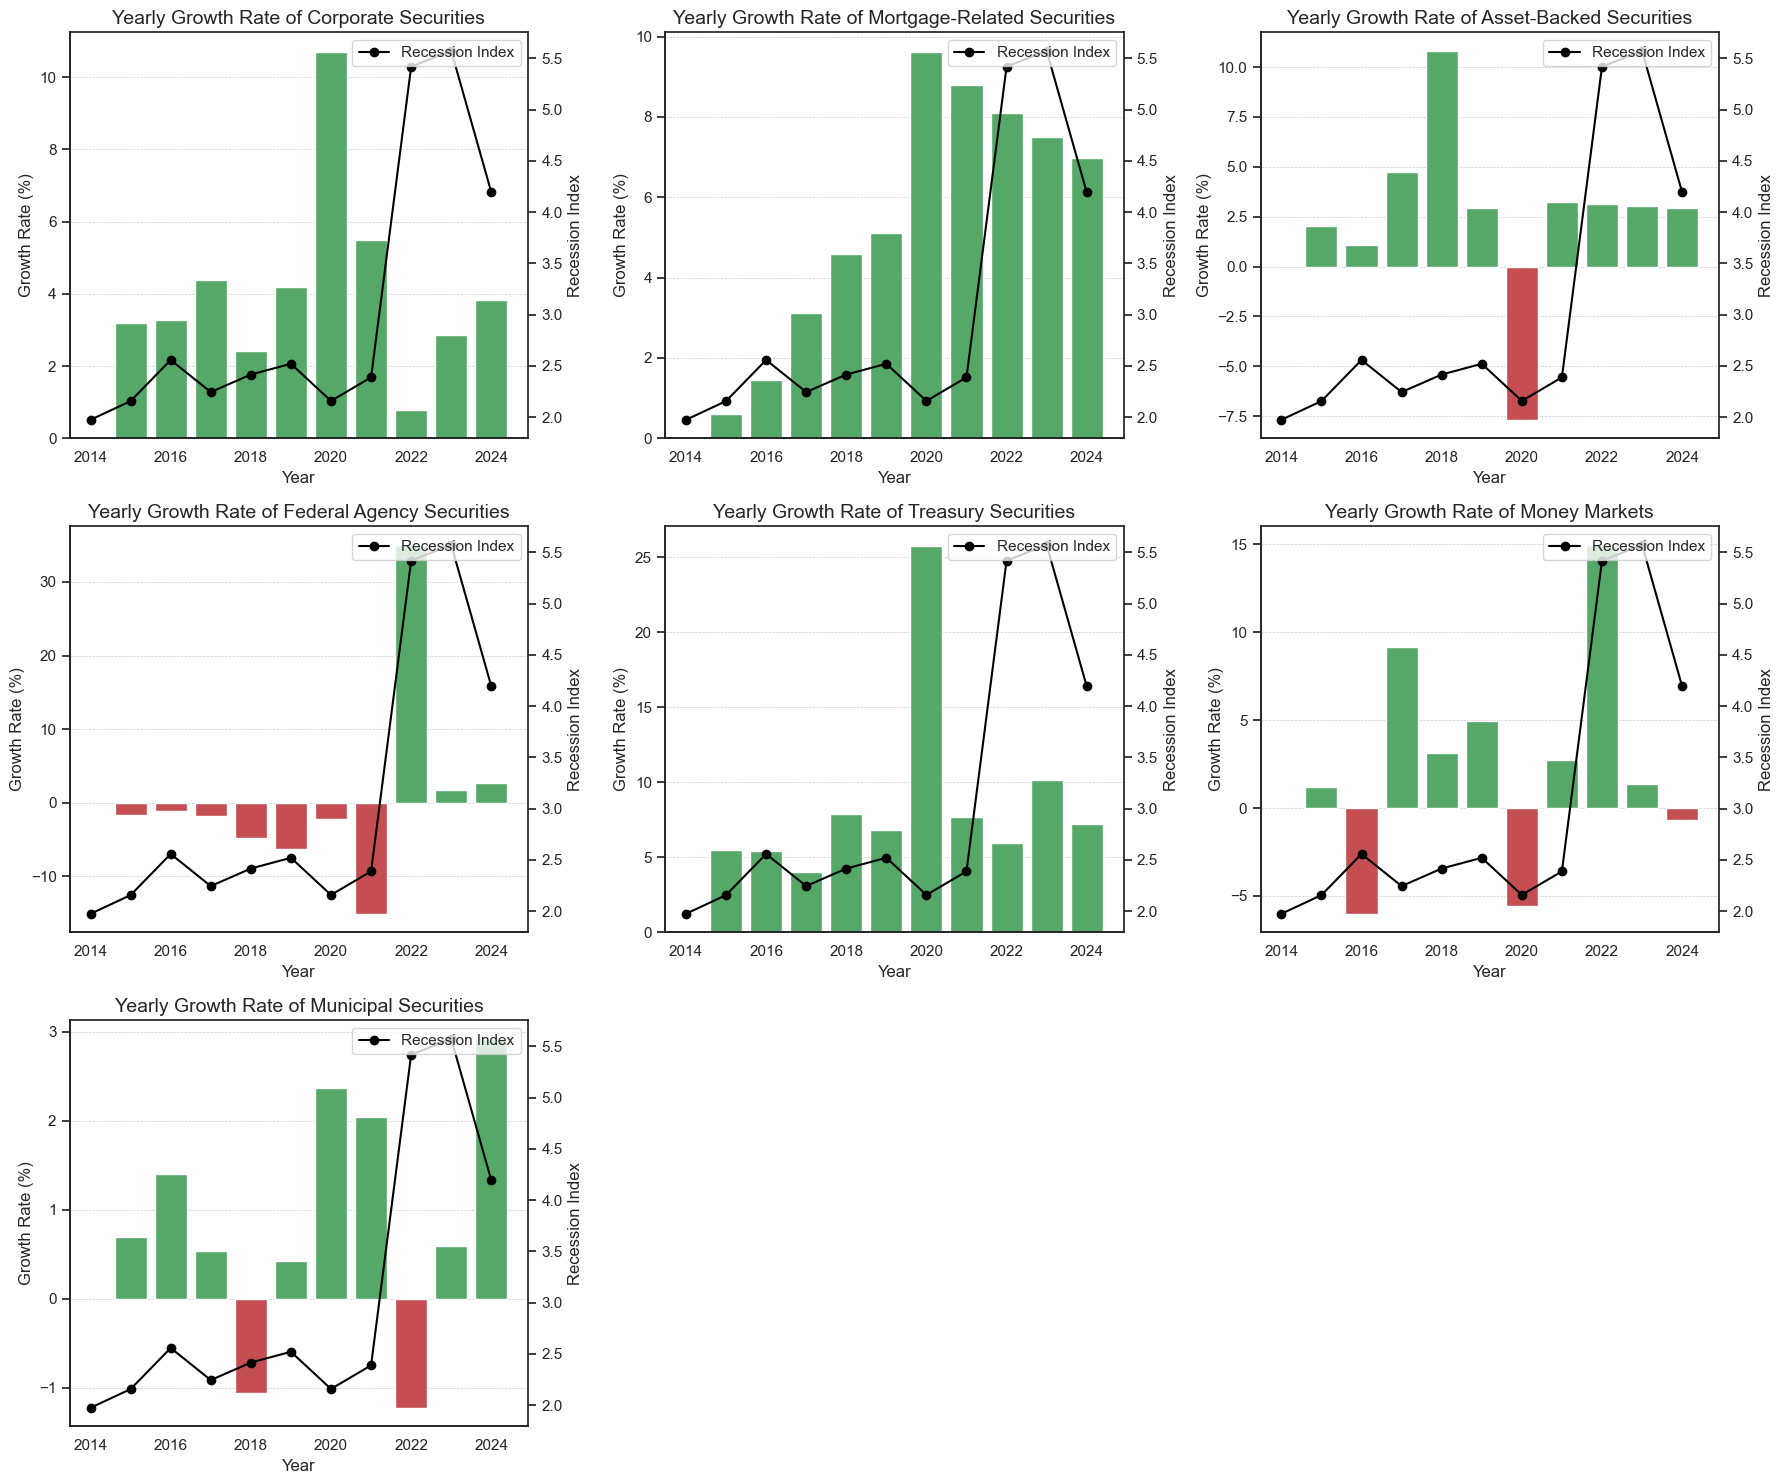

In [12]:
#Average Daily Trading Volume - Total - Line Plot
# Set the style of the visualization
sns.set(style="white")

# Make sure Year is int (for consistent plotting and ticks)
df_sifma_trade['Year'] = df_sifma_trade['Year'].astype(int)

# Sort the data by Year (just in case)
df_sifma_trade = df_sifma_trade.sort_values('Year')

# Draw line plot with Seaborn
plt.figure(figsize=(14, 10))
sns.lineplot(x='Year', y='Total', data=df_sifma_trade,
             color='tab:blue', linewidth=2.5, marker='o')

# Add title and labels
plt.title('Fixed Income Trade Volume (Billions)', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount', fontsize=14)

# Customize axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate each data point with its value
for index, row in df_sifma_trade.iterrows():
    ax.annotate(f"{round(row['Total'], 2)}",
                (row['Year'], row['Total']),
                textcoords="offset points", xytext=(0, 5),
                ha='center', fontsize=9)

# Set x-tickers and labels
ax.set_xticks(df_sifma_trade['Year'])
ax.set_xticklabels(df_sifma_trade['Year'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()



#Average Daily Trading Volume - Aggregation by Bond Types & Total - Line plot & Stacked Bar Chart

df_sifma_trade.columns[df_sifma_trade.columns.duplicated()]


# Columns to include in stacked bars
columns = ['UST', 'Agency MBS', 'Non-Agency MBS', 'Corporates', 'Munis', 'ABS']

df_sifma_trade['Year_Str'] = df_sifma_trade['Year'].astype(str)

plt.figure(figsize=(18, 10))
ax = plt.gca()

df_sifma_trade.set_index('Year_Str')[columns].plot(kind='bar', stacked=True, alpha=0.8, ax=ax)

sns.lineplot(x='Year_Str', y='Total', data=df_sifma_trade, color='black', linewidth=1, marker='o', ax=ax)

ax.set_xticks(range(len(df_sifma_trade['Year_Str'])))
ax.set_xticklabels(df_sifma_trade['Year_Str'], rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Fixed Income Trade Volume by Type (Stacked Bar)', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount', fontsize=14)

plt.tight_layout()
plt.show()




# Part 2: Macro Correlation Study


#Correlation Study - Macro Economic Indicator Correlation

#GDP-Based Recession Index vs. Total Bond Market size
# Step 1: Convert 'DATE' column to datetime

# Clean column names
# Convert date column properly
df_recession['observation_date'] = pd.to_datetime(df_recession['observation_date'])

# Extract year
df_recession['YEAR'] = df_recession['observation_date'].dt.year


# Step 3: Aggregate recession index by year
df_recession_yearly = df_recession.groupby('YEAR', as_index=False).mean(numeric_only=True)

# Step 4: Merge with market data
merged_df = df_sifma_market.merge(df_recession_yearly, left_on='period', right_on='YEAR', how='left')



columns = ['Corporate Securities', 'Mortgage-Related Securities', 'Asset-Backed Securities',
                'Federal Agency Securities', 'Treasury Securities', 'Money Markets', 'Municipal Securities']
# Extracting data
years = merged_df['period'].values
bond_sizes = merged_df[columns].values
recession_index = merged_df['JHGDPBRINDX'].values

# Plotting the bond market size as a stacked bar chart
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.bar(years, bond_sizes[:, 0], label=columns[0])
for i in range(1, len(columns)):
    ax1.bar(years, bond_sizes[:, i], bottom=bond_sizes[:, :i].sum(axis=1), label=columns[i])
ax1.set_xlabel('Year')
ax1.set_ylabel('Bond Market Size')
ax1.set_title('Bond Market Size vs Recession Index')
ax1.legend(loc='upper left')

# Creating a secondary y-axis for the recession index
ax2 = ax1.twinx()
ax2.plot(years, recession_index, 'o-', color='black', label='Recession Index')
ax2.set_ylabel('Recession Index')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show() 



#GDP-Based Recession Index vs. Separate Bond Market size

# Ensure dataframe is sorted by year/period
merged_df = merged_df.sort_values(by='period')

# Calculate year-on-year growth rates for the columns in `merged_df`
df_growth_rates = merged_df.set_index('period')[columns].pct_change() * 100  # Convert to percentage

df_growth_rate_temp = merged_df[columns].pct_change() * 100  # Convert to percentage
df_growth_rate_temp['period'] = merged_df['period']

# Merge the two dataframes on the year columns
merged_df = df_growth_rate_temp.merge(df_recession_yearly, left_on='period', right_on='YEAR', how='left')


# Set the figure size
plt.figure(figsize=(18, 15))

# Plot each bond type as a separate subplot
for i, col in enumerate(columns):
    ax1 = plt.subplot(3, 3, i+1)
    
    # Bar plot for growth rate
    colors = ['g' if val > 0 else 'r' for val in df_growth_rates[col]]
    bars = ax1.bar(df_growth_rates.index, df_growth_rates[col], color=colors)
    
    # Add recession index as a line plot on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(merged_df['period'], merged_df['JHGDPBRINDX'], 'o-', color='black', label='Recession Index')
    
    # Set title, labels, and legends
    ax1.set_title(f'Yearly Growth Rate of {col}', fontsize=14)
    ax1.set_ylabel('Growth Rate (%)')
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Recession Index')
    ax2.legend(loc='upper right')
    
    # Highlight positive growth rates in green and negative in red
    for bar, growth_rate in zip(bars, df_growth_rates[col]):
        if growth_rate > 0:
            bar.set_color('g')
        else:
            bar.set_color('r')
    
    # Grid lines for better clarity
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()



#Recession: Correlation Coefficient for each bond type

# Assuming merged_df is your dataframe
pearson_correlations = []
spearman_correlations = []

# Loop through each bond type
for col in columns:
    pearson_corr = merged_df[col].corr(merged_df['JHGDPBRINDX'], method='pearson')
    spearman_corr = merged_df[col].corr(merged_df['JHGDPBRINDX'], method='spearman')
    
    pearson_correlations.append(pearson_corr)
    spearman_correlations.append(spearman_corr)

# Create a dataframe to display results
results_df = pd.DataFrame({
    'Bond Type': columns,
    'Pearson Correlation': pearson_correlations,
    'Spearman Rank Correlation': spearman_correlations
})

display(results_df)


#Unemployment Rate Correlation vs. Bond Market Size
for df in [df_unemployment, df_cpi]:
    date_col = [col for col in df.columns if 'date' in col.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col])
    df['YEAR'] = df[date_col].dt.year


# Aggregate the recession index by year
df_unemployment_yearly = df_unemployment.groupby('YEAR').mean().reset_index()

# Merge the two dataframes on the year columns
merged_df_unemp = df_sifma_market.merge(df_unemployment_yearly, left_on='period', right_on='YEAR', how='left')

merged_df_unemp.head(5)




# Extracting data
years = merged_df_unemp['period'].values
bond_sizes = merged_df_unemp[columns].values
recession_index = merged_df_unemp['UNRATE'].values

# Plotting the bond market size as a stacked bar chart
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.bar(years, bond_sizes[:, 0], label=columns[0])
for i in range(1, len(columns)):
    ax1.bar(years, bond_sizes[:, i], bottom=bond_sizes[:, :i].sum(axis=1), label=columns[i])
ax1.set_xlabel('Year')
ax1.set_ylabel('Bond Market Size')
ax1.set_title('Bond Market Size vs Recession Index')
ax1.legend(loc='upper left')

# Creating a secondary y-axis for the recession index
ax2 = ax1.twinx()
ax2.plot(years, recession_index, 'o-', color='black', label='Recession Index')
ax2.set_ylabel('Recession Index')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



#Unemployment Rate Correlation vs. Separate Bond Market size

# Merge the two dataframes on the year columns
merged_df_unemp = df_growth_rate_temp.merge(df_unemployment_yearly, left_on='period', right_on='YEAR', how='left')

df_growth_rates_unemp = df_growth_rate_temp.set_index('period')

# Set the figure size
plt.figure(figsize=(18, 15))

# Plot each bond type as a separate subplot
for i, col in enumerate(columns):
    ax1 = plt.subplot(3, 3, i+1)
    
    # Bar plot for growth rate with color based on the value
    colors = ['g' if val > 0 else 'r' for val in df_growth_rates[col]]
    ax1.bar(df_growth_rates.index, df_growth_rates[col], color=colors)
    
    # Add recession index as a line plot on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(merged_df_unemp['period'], merged_df_unemp['UNRATE'], 'o-', color='black', label='Recession Index')
    
    # Set title, labels, and legends
    ax1.set_title(f'Yearly Growth Rate of {col}', fontsize=14)
    ax1.set_ylabel('Growth Rate (%)')
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Recession Index')
    ax2.legend(loc='upper right')
    
    # Grid lines for better clarity
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()




#Unemployment: Correlation Coefficient for each bond type

# Assuming merged_df is your dataframe
pearson_correlations = []
spearman_correlations = []

# Loop through each bond type
for col in columns:
    pearson_corr = merged_df_unemp[col].corr(merged_df_unemp['UNRATE'], method='pearson')
    spearman_corr = merged_df_unemp[col].corr(merged_df_unemp['UNRATE'], method='spearman')
    
    pearson_correlations.append(pearson_corr)
    spearman_correlations.append(spearman_corr)

# Create a dataframe to display results
results_df = pd.DataFrame({
    'Bond Type': columns,
    'Pearson Correlation': pearson_correlations,
    'Spearman Rank Correlation': spearman_correlations
})

display(results_df)



#After 2008: Unemployment Rate Correlation vs. Separate Bond Market size

merged_df_unemp_2008 = merged_df_unemp[merged_df_unemp['period']>= 2008]
# Convert the 'DATE' column to datetime
for df in [df_unemployment, df_cpi]:
    date_col = [col for col in df.columns if 'date' in col.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col])
    df['YEAR'] = df[date_col].dt.year

# Aggregate the recession index by year
df_unemployment_yearly = df_unemployment.groupby('YEAR').mean().reset_index()

# Merge the two dataframes on the year columns
merged_df_unemp = df_sifma_market.merge(df_unemployment_yearly, left_on='period', right_on='YEAR', how='left')

df_growth_rate_temp_2008 = merged_df_unemp[columns].pct_change() * 100  # Convert to percentage
df_growth_rate_temp_2008['period'] = merged_df_unemp_2008['period']
df_growth_rate_temp_2008 = df_growth_rate_temp_2008[df_growth_rate_temp_2008['period'] >= 2008]
df_growth_rate_temp_2008 = df_growth_rate_temp_2008.set_index('period')

# Set the figure size
plt.figure(figsize=(18, 15))

# Plot each bond type as a separate subplot
for i, col in enumerate(columns):
    ax1 = plt.subplot(3, 3, i+1)
    
    # Bar plot for growth rate with color based on the value
    colors = ['g' if val > 0 else 'r' for val in df_growth_rate_temp_2008[col]]
    ax1.bar(df_growth_rate_temp_2008.index, df_growth_rate_temp_2008[col], color=colors)
    
    # Add recession index as a line plot on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(merged_df_unemp_2008['period'], merged_df_unemp_2008['UNRATE'], 'o-', color='black', label='Recession Index')
    
    # Set title, labels, and legends
    ax1.set_title(f'Yearly Growth Rate of {col}', fontsize=14)
    ax1.set_ylabel('Growth Rate (%)')
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Recession Index')
    ax2.legend(loc='upper right')
    
    # Grid lines for better clarity
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()



# Assuming merged_df is your dataframe
pearson_correlations = []
spearman_correlations = []

# Loop through each bond type
for col in columns:
    pearson_corr = merged_df_unemp_2008[col].corr(merged_df_unemp_2008['UNRATE'], method='pearson')
    spearman_corr = merged_df_unemp_2008[col].corr(merged_df_unemp_2008['UNRATE'], method='spearman')
    
    pearson_correlations.append(pearson_corr)
    spearman_correlations.append(spearman_corr)

# Create a dataframe to display results
results_df = pd.DataFrame({
    'Bond Type': columns,
    'Pearson Correlation': pearson_correlations,
    'Spearman Rank Correlation': spearman_correlations
})

display(results_df)



#CPI vs. Bond Market Size


for df in [df_cpi]:
    date_col = [col for col in df.columns if 'date' in col.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col])
    df['YEAR'] = df[date_col].dt.year



# Aggregate the recession index by year
df_cpi_yearly = df_cpi.groupby('YEAR').mean().reset_index()

# Merge the two dataframes on the year columns
merged_df_cpi = df_growth_rate_temp.merge(df_cpi_yearly, left_on='period', right_on='YEAR', how='left')

# merged_df_cpi.head(5)

# Set the figure size
plt.figure(figsize=(18, 15))

# Plot each bond type as a separate subplot
for i, col in enumerate(columns):
    ax1 = plt.subplot(3, 3, i+1)
    
    # Bar plot for growth rate with color based on the value
    colors = ['g' if val > 0 else 'r' for val in df_growth_rates[col]]
    ax1.bar(df_growth_rates.index, df_growth_rates[col], color=colors)
    
    # Add recession index as a line plot on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(merged_df_cpi['period'], merged_df_cpi['CORESTICKM159SFRBATL'], 'o-', color='black', label='Recession Index')
    
    # Set title, labels, and legends
    ax1.set_title(f'Yearly Growth Rate of {col}', fontsize=14)
    ax1.set_ylabel('Growth Rate (%)')
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Recession Index')
    ax2.legend(loc='upper right')
    
    # Grid lines for better clarity
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


Bond Type  Pearson Correlation  \
0         Corporate Securities            -0.498180   
1  Mortgage-Related Securities             0.415598   
2      Asset-Backed Securities             0.102095   
3    Federal Agency Securities             0.694428   
4          Treasury Securities            -0.119604   
5                Money Markets             0.366152   
6         Municipal Securities            -0.227798   

   Spearman Rank Correlation  Kendall Tau Correlation  
0                  -0.539394                -0.422222  
1                   0.212121                 0.200000  
2                   0.151515                 0.111111  
3                   0.587879                 0.377778  
4                   0.115152                 0.066667  
5                   0.127273                 0.111111  
6                  -0.224242                -0.155556

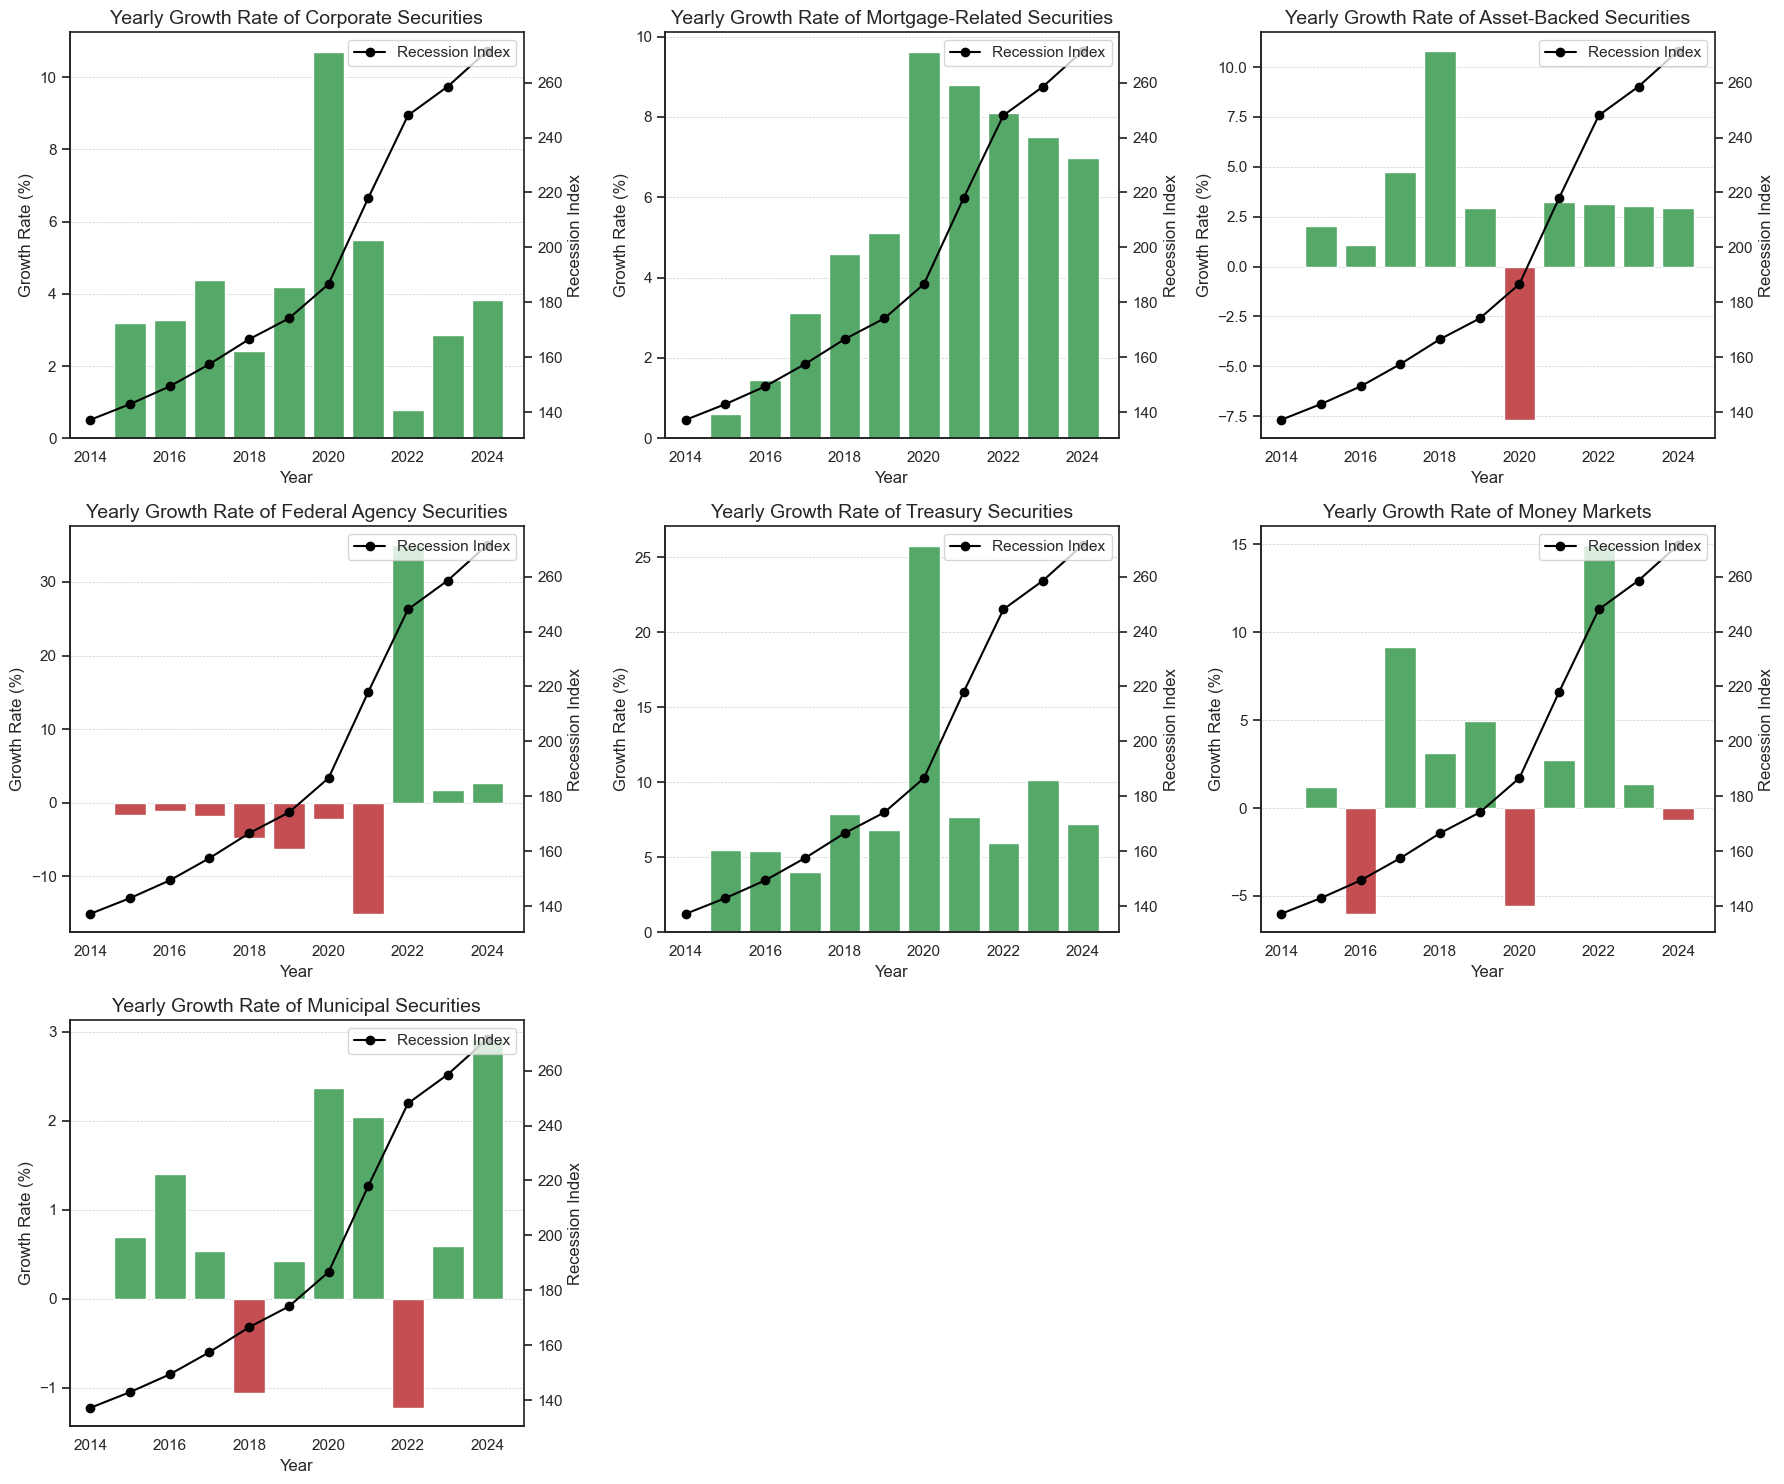

Bond Type  Pearson Correlation  \
0         Corporate Securities            -0.157330   
1  Mortgage-Related Securities             0.726171   
2      Asset-Backed Securities            -0.020331   
3    Federal Agency Securities             0.408777   
4          Treasury Securities             0.083683   
5                Money Markets             0.204418   
6         Municipal Securities             0.177720   

   Spearman Rank Correlation  Kendall Tau Correlation  
0                  -0.042424                 0.022222  
1                   0.757576                 0.555556  
2                   0.163636                 0.022222  
3                   0.333333                 0.111111  
4                   0.563636                 0.333333  
5                   0.090909                 0.022222  
6                   0.187879                 0.111111

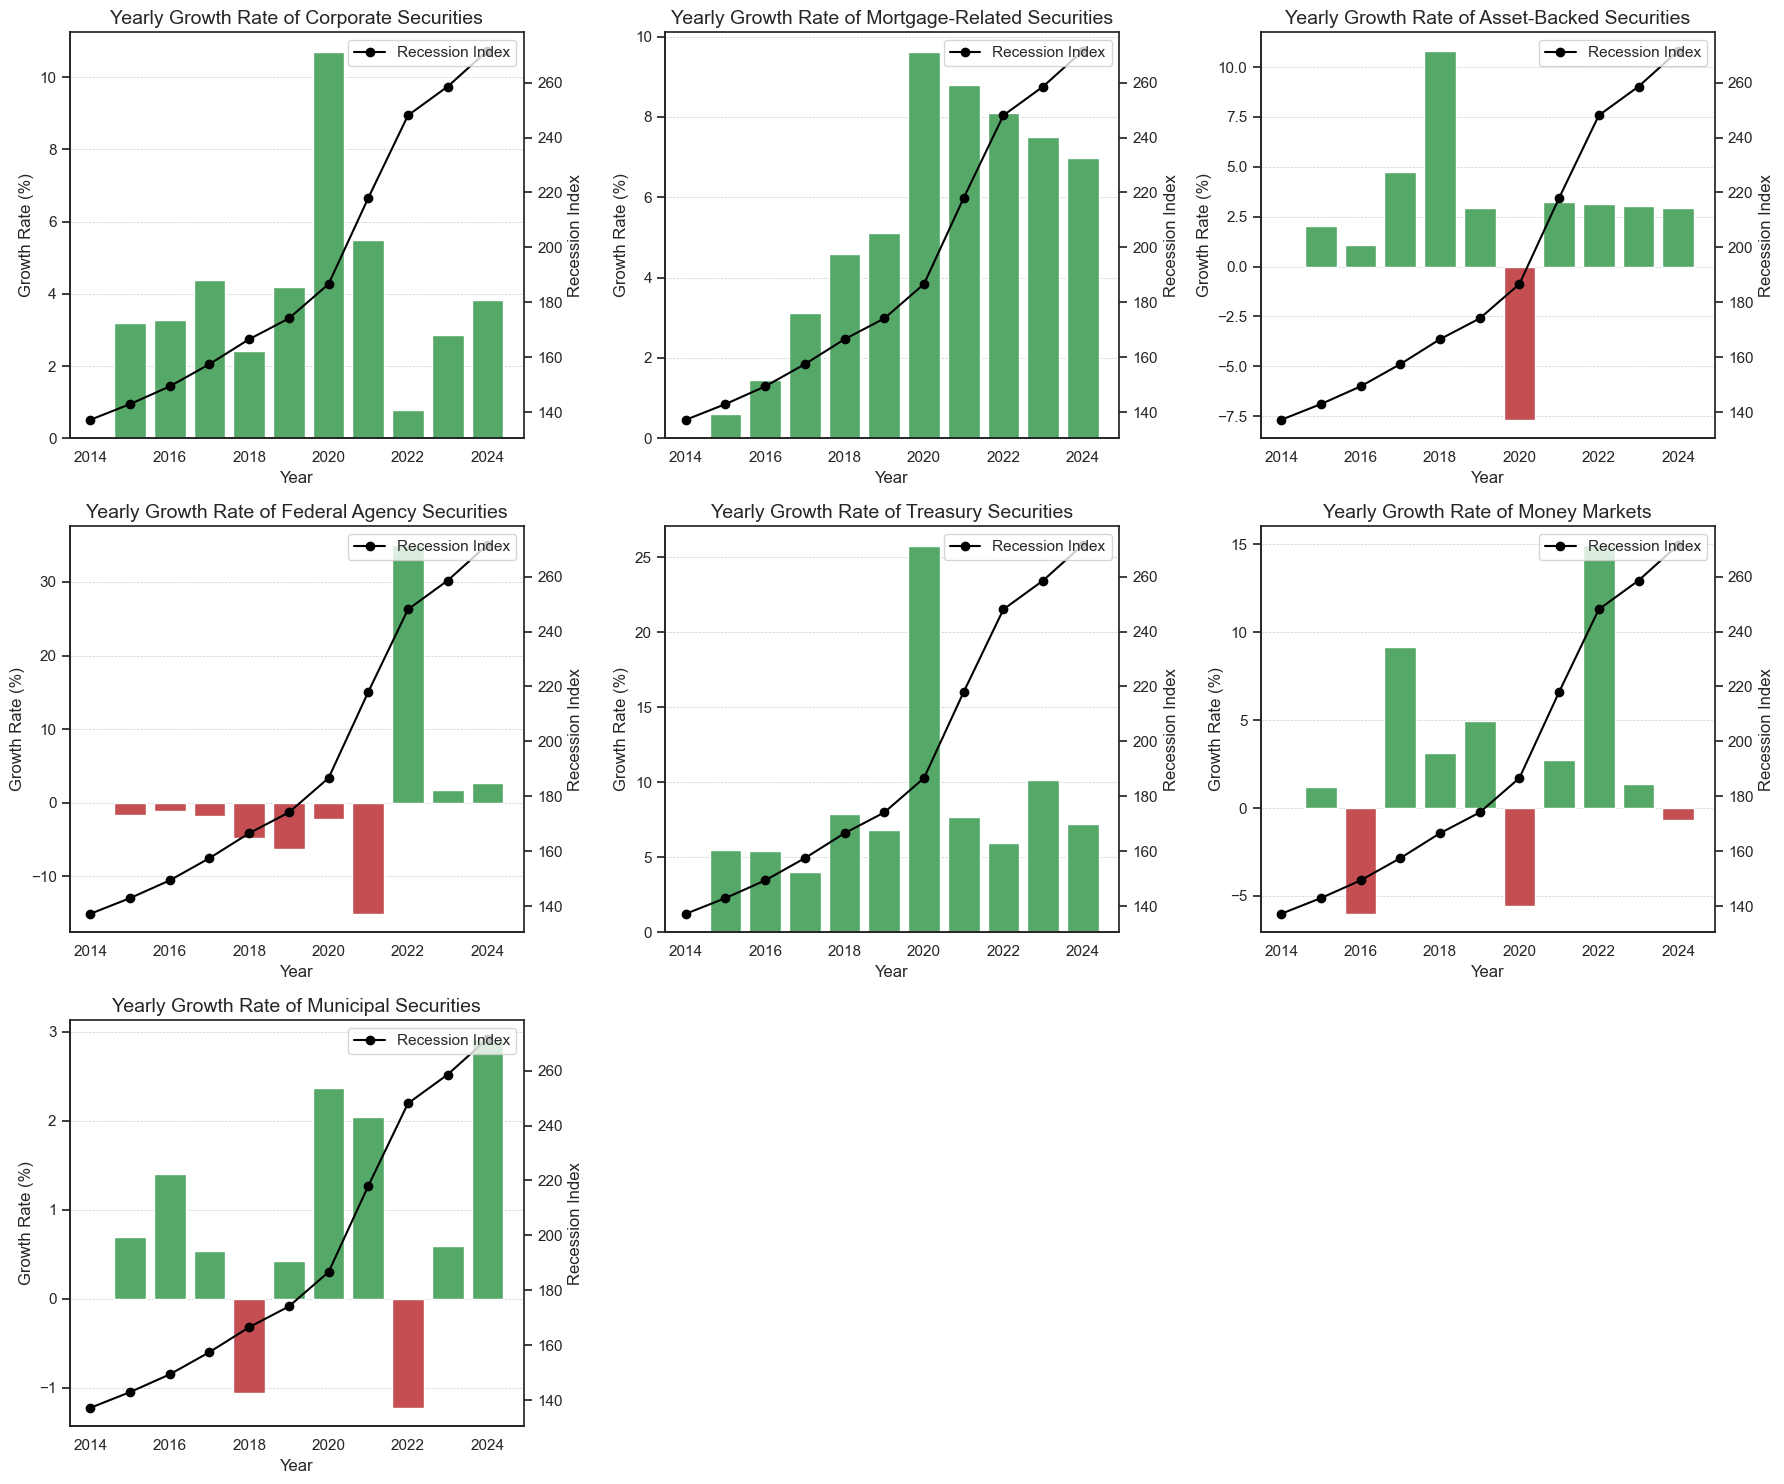

Bond Type  Pearson Correlation  \
0         Corporate Securities            -0.157330   
1  Mortgage-Related Securities             0.726171   
2      Asset-Backed Securities            -0.020331   
3    Federal Agency Securities             0.408777   
4          Treasury Securities             0.083683   
5                Money Markets             0.204418   
6         Municipal Securities             0.177720   

   Spearman Rank Correlation  Kendall Tau Correlation  
0                  -0.042424                 0.022222  
1                   0.757576                 0.555556  
2                   0.163636                 0.022222  
3                   0.333333                 0.111111  
4                   0.563636                 0.333333  
5                   0.090909                 0.022222  
6                   0.187879                 0.111111

In [13]:
# Assuming merged_df is your dataframe
pearson_correlations = []
spearman_correlations = []
kendall_correlations = []

# Loop through each bond type
for col in columns:
    pearson_corr = merged_df_cpi[col].corr(merged_df_cpi['CORESTICKM159SFRBATL'], method='pearson')
    spearman_corr = merged_df_cpi[col].corr(merged_df_cpi['CORESTICKM159SFRBATL'], method='spearman')
    kendall_corr = merged_df_cpi[col].corr(merged_df_cpi['CORESTICKM159SFRBATL'], method='kendall')
    
    pearson_correlations.append(pearson_corr)
    spearman_correlations.append(spearman_corr)
    kendall_correlations.append(kendall_corr)

# Create a dataframe to display results
results_df = pd.DataFrame({
    'Bond Type': columns,
    'Pearson Correlation': pearson_correlations,
    'Spearman Rank Correlation': spearman_correlations,
    'Kendall Tau Correlation': kendall_correlations
})

display(results_df)




#Housing Price Index vs. Bond Size
# Group by Year and calculate the mean for Index_SA
yearly_housing_index = df_housing_price.groupby('Year')['Index_SA'].mean().reset_index()

merged_df_house = df_growth_rate_temp.merge(yearly_housing_index, left_on='period', right_on='Year', how='left')

# Set the figure size
plt.figure(figsize=(18, 15))

# Plot each bond type as a separate subplot
for i, col in enumerate(columns):
    ax1 = plt.subplot(3, 3, i+1)
    
    # Bar plot for growth rate with color based on the value
    colors = ['g' if val > 0 else 'r' for val in df_growth_rates[col]]
    ax1.bar(df_growth_rates.index, df_growth_rates[col], color=colors)
    
    # Add recession index as a line plot on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(merged_df_house['period'], merged_df_house['Index_SA'], 'o-', color='black', label='Recession Index')
    
    # Set title, labels, and legends
    ax1.set_title(f'Yearly Growth Rate of {col}', fontsize=14)
    ax1.set_ylabel('Growth Rate (%)')
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Recession Index')
    ax2.legend(loc='upper right')
    
    # Grid lines for better clarity
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()



# Assuming merged_df is your dataframe
pearson_correlations = []
spearman_correlations = []
kendall_correlations = []

# Loop through each bond type
for col in columns:
    pearson_corr = merged_df_house[col].corr(merged_df_house['Index_SA'], method='pearson')
    spearman_corr = merged_df_house[col].corr(merged_df_house['Index_SA'], method='spearman')
    kendall_corr = merged_df_house[col].corr(merged_df_house['Index_SA'], method='kendall')
    
    pearson_correlations.append(pearson_corr)
    spearman_correlations.append(spearman_corr)
    kendall_correlations.append(kendall_corr)

# Create a dataframe to display results
results_df = pd.DataFrame({
    'Bond Type': columns,
    'Pearson Correlation': pearson_correlations,
    'Spearman Rank Correlation': spearman_correlations,
    'Kendall Tau Correlation': kendall_correlations
})

display(results_df)



# Filter dataframes for years after 2008
df_growth_rates = df_growth_rates[df_growth_rates.index > 2008]
merged_df_house = merged_df_house[merged_df_house['period'] > 2008]

# Set the figure size
plt.figure(figsize=(18, 15))

# Plot each bond type as a separate subplot
for i, col in enumerate(columns):
    ax1 = plt.subplot(3, 3, i+1)
    
    # Bar plot for growth rate with color based on the value
    colors = ['g' if val > 0 else 'r' for val in df_growth_rates[col]]
    ax1.bar(df_growth_rates.index, df_growth_rates[col], color=colors)
    
    # Add recession index as a line plot on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(merged_df_house['period'], merged_df_house['Index_SA'], 'o-', color='black', label='Recession Index')
    
    # Set title, labels, and legends
    ax1.set_title(f'Yearly Growth Rate of {col}', fontsize=14)
    ax1.set_ylabel('Growth Rate (%)')
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Recession Index')
    ax2.legend(loc='upper right')
    
    # Grid lines for better clarity
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()



# Filter merged_df_house for years after 2008
merged_df_house = merged_df_house[merged_df_house['period'] > 2008]

pearson_correlations = []
spearman_correlations = []
kendall_correlations = []

# Loop through each bond type
for col in columns:
    pearson_corr = merged_df_house[col].corr(merged_df_house['Index_SA'], method='pearson')
    spearman_corr = merged_df_house[col].corr(merged_df_house['Index_SA'], method='spearman')
    kendall_corr = merged_df_house[col].corr(merged_df_house['Index_SA'], method='kendall')
    
    pearson_correlations.append(pearson_corr)
    spearman_correlations.append(spearman_corr)
    kendall_correlations.append(kendall_corr)

# Create a dataframe to display results
results_df = pd.DataFrame({
    'Bond Type': columns,
    'Pearson Correlation': pearson_correlations,
    'Spearman Rank Correlation': spearman_correlations,
    'Kendall Tau Correlation': kendall_correlations
})

display(results_df)

Origination Data:


Loan Sequence Number  First Payment Date  Original Loan Term  Original UPB  \
0         F21Q11280918              202103               360.0      141000.0   
1         F21Q11303439              202103               360.0      798000.0   
2         F21Q11306083              202103               360.0      145000.0   
3         F21Q11310962              202103               360.0      357000.0   
4         F21Q11345533              202103               360.0      389000.0   

   Mortgage Insurance Percentage (MI %)  Original Loan-to-Value (LTV)  \
0                                  25.0                          90.0   
1                                  30.0                          95.0   
2                                   0.0                          58.0   
3                                   0.0                          59.0   
4                                  12.0                          81.0   

   Original Interest Rate Channel Loan Purpose  Super Conforming Flag  \
0                   2.875       R            P                      0   
1                   2.999       B            P                      1   
2                   2.990       R            C                      0   
3                   2.500       R            N                      0   
4                   2.875       B            N                      0   

   Credit Score First Time Homebuyer Flag  \
0         689.0                         N   
1         750.0                         Y   
2         782.0                         N   
3         815.0                         N   
4         740.0                         N   

   Original Debt-to-Income (DTI) Ratio  Number of Borrowers  Number of Units  \
0                                 35.0                  2.0              1.0   
1                                 48.0                  2.0              1.0   
2                                 20.0                  1.0              1.0   
3                                 38.0                  2.0              1.0   
4                                 23.0                  2.0              1.0   

  Occupancy Status Property State Property Type  Property Valuation Method  \
0                P             OH            SF                        2.0   
1                P             CA            CO                        2.0   
2                P             FL            SF                        1.0   
3                P             CA            SF                        1.0   
4                P             CO            PU                        1.0   

   Valid DTI Ratio  
0                1  
1                1  
2                1  
3                1  
4                1


Monthly Performance Data:


Loan Sequence Number  Monthly Reporting Period  Current Actual UPB  \
0         F21Q11280918                    202102            141000.0   
1         F21Q11280918                    202103            140000.0   
2         F21Q11280918                    202104            140000.0   
3         F21Q11280918                    202105            140000.0   
4         F21Q11280918                    202106                 0.0   

   Current Loan Delinquency Status  Loan Age  \
0                                0       0.0   
1                                0       1.0   
2                                0       2.0   
3                                0       3.0   
4                                0       4.0   

   Remaining Months to Legal Maturity  Zero Balance Code  \
0                               360.0                NaN   
1                               359.0                NaN   
2                               358.0                NaN   
3                               357.0                NaN   
4                               356.0                1.0   

   Current Interest Rate  Delinquency Due to Disaster  Interest Bearing UPB  
0                  2.875                            0              141000.0  
1                  2.875                            0              140000.0  
2                  2.875                            0              140000.0  
3                  2.875                            0              140000.0  
4                  2.875                            0                   0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Loan Sequence Number                  1263 non-null   object 
 1   First Payment Date                    1263 non-null   int64  
 2   Original Loan Term                    1263 non-null   float64
 3   Original UPB                          1263 non-null   float64
 4   Mortgage Insurance Percentage (MI %)  1263 non-null   float64
 5   Original Loan-to-Value (LTV)          1263 non-null   float64
 6   Original Interest Rate                1263 non-null   float64
 7   Channel                               1263 non-null   object 
 8   Loan Purpose                          1263 non-null   object 
 9   Super Conforming Flag                 1263 non-null   int64  
 10  Credit Score                          1263 non-null   float64
 11  First Time Homebu

None

Loan Sequence Number  First Payment Date  Original Loan Term  Original UPB  \
0         F21Q11280918              202103               360.0      141000.0   
1         F21Q11303439              202103               360.0      798000.0   
2         F21Q11306083              202103               360.0      145000.0   
3         F21Q11310962              202103               360.0      357000.0   
4         F21Q11345533              202103               360.0      389000.0   

   Mortgage Insurance Percentage (MI %)  Original Loan-to-Value (LTV)  \
0                                  25.0                          90.0   
1                                  30.0                          95.0   
2                                   0.0                          58.0   
3                                   0.0                          59.0   
4                                  12.0                          81.0   

   Original Interest Rate Channel Loan Purpose  Super Conforming Flag  \
0                   2.875       R            P                      0   
1                   2.999       B            P                      1   
2                   2.990       R            C                      0   
3                   2.500       R            N                      0   
4                   2.875       B            N                      0   

   Credit Score First Time Homebuyer Flag  \
0         689.0                         N   
1         750.0                         Y   
2         782.0                         N   
3         815.0                         N   
4         740.0                         N   

   Original Debt-to-Income (DTI) Ratio  Number of Borrowers  Number of Units  \
0                                 35.0                  2.0              1.0   
1                                 48.0                  2.0              1.0   
2                                 20.0                  1.0              1.0   
3                                 38.0                  2.0              1.0   
4                                 23.0                  2.0              1.0   

  Occupancy Status Property State Property Type  Property Valuation Method  \
0                P             OH            SF                        2.0   
1                P             CA            CO                        2.0   
2                P             FL            SF                        1.0   
3                P             CA            SF                        1.0   
4                P             CO            PU                        1.0   

   Valid DTI Ratio  
0                1  
1                1  
2                1  
3                1  
4                1

Loan Sequence Number                    0
First Payment Date                      0
Original Loan Term                      0
Original UPB                            0
Mortgage Insurance Percentage (MI %)    0
Original Loan-to-Value (LTV)            0
Original Interest Rate                  0
Channel                                 0
Loan Purpose                            0
Super Conforming Flag                   0
Credit Score                            0
First Time Homebuyer Flag               0
Original Debt-to-Income (DTI) Ratio     0
Number of Borrowers                     0
Number of Units                         0
Occupancy Status                        0
Property State                          0
Property Type                           0
Property Valuation Method               0
Valid DTI Ratio                         0
dtype: int64


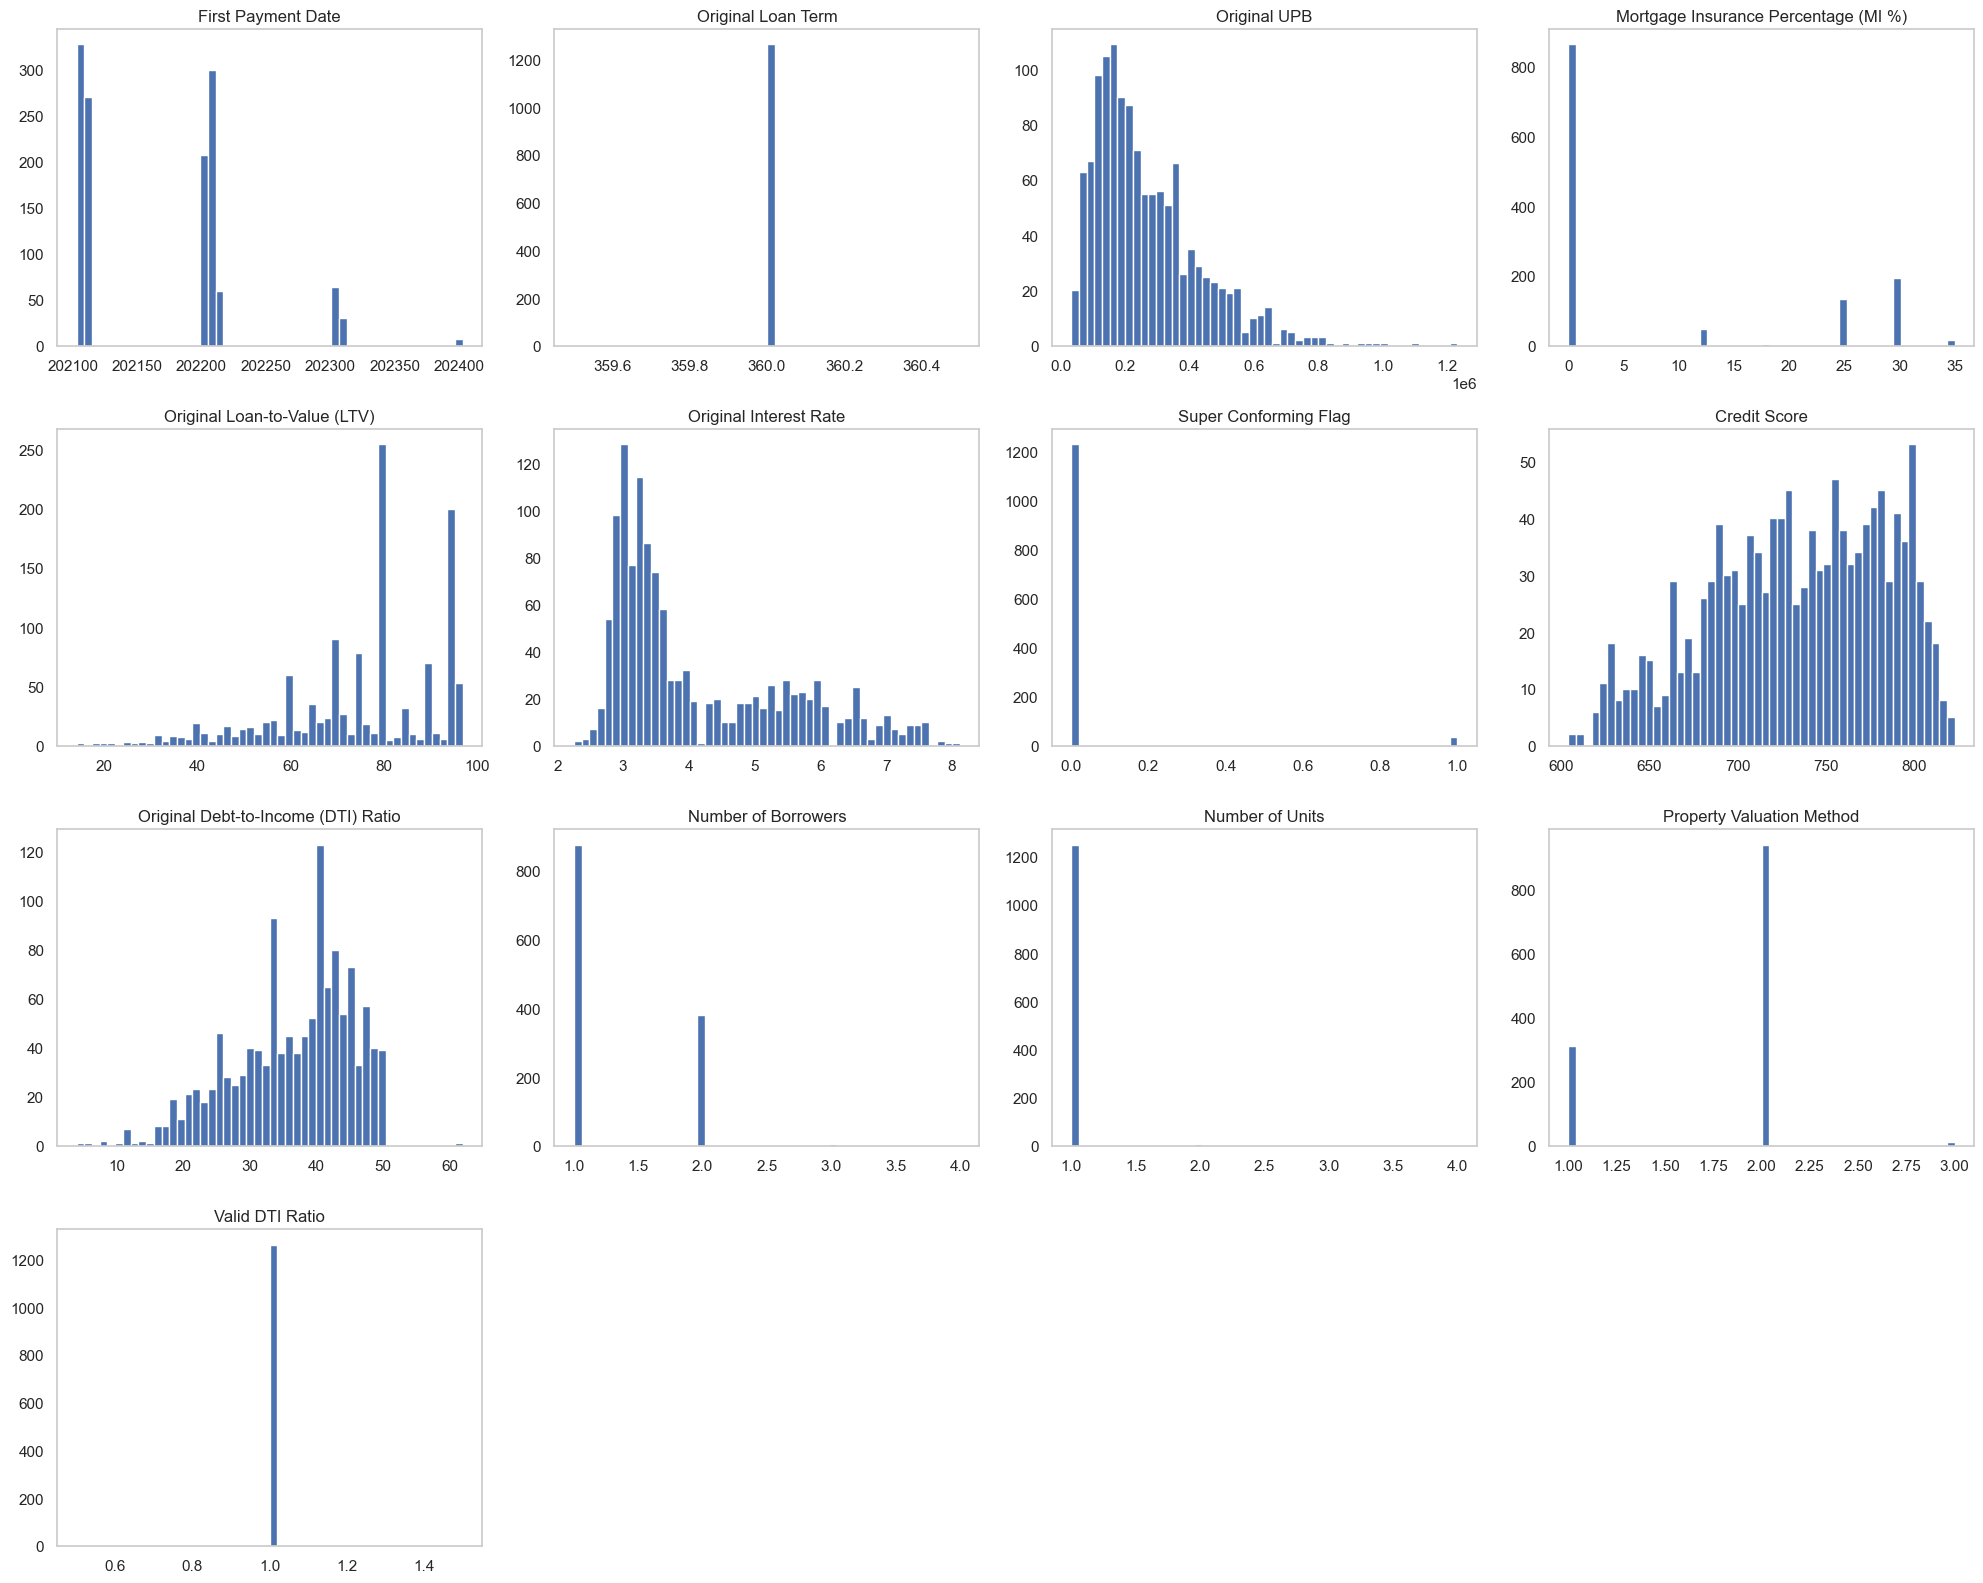

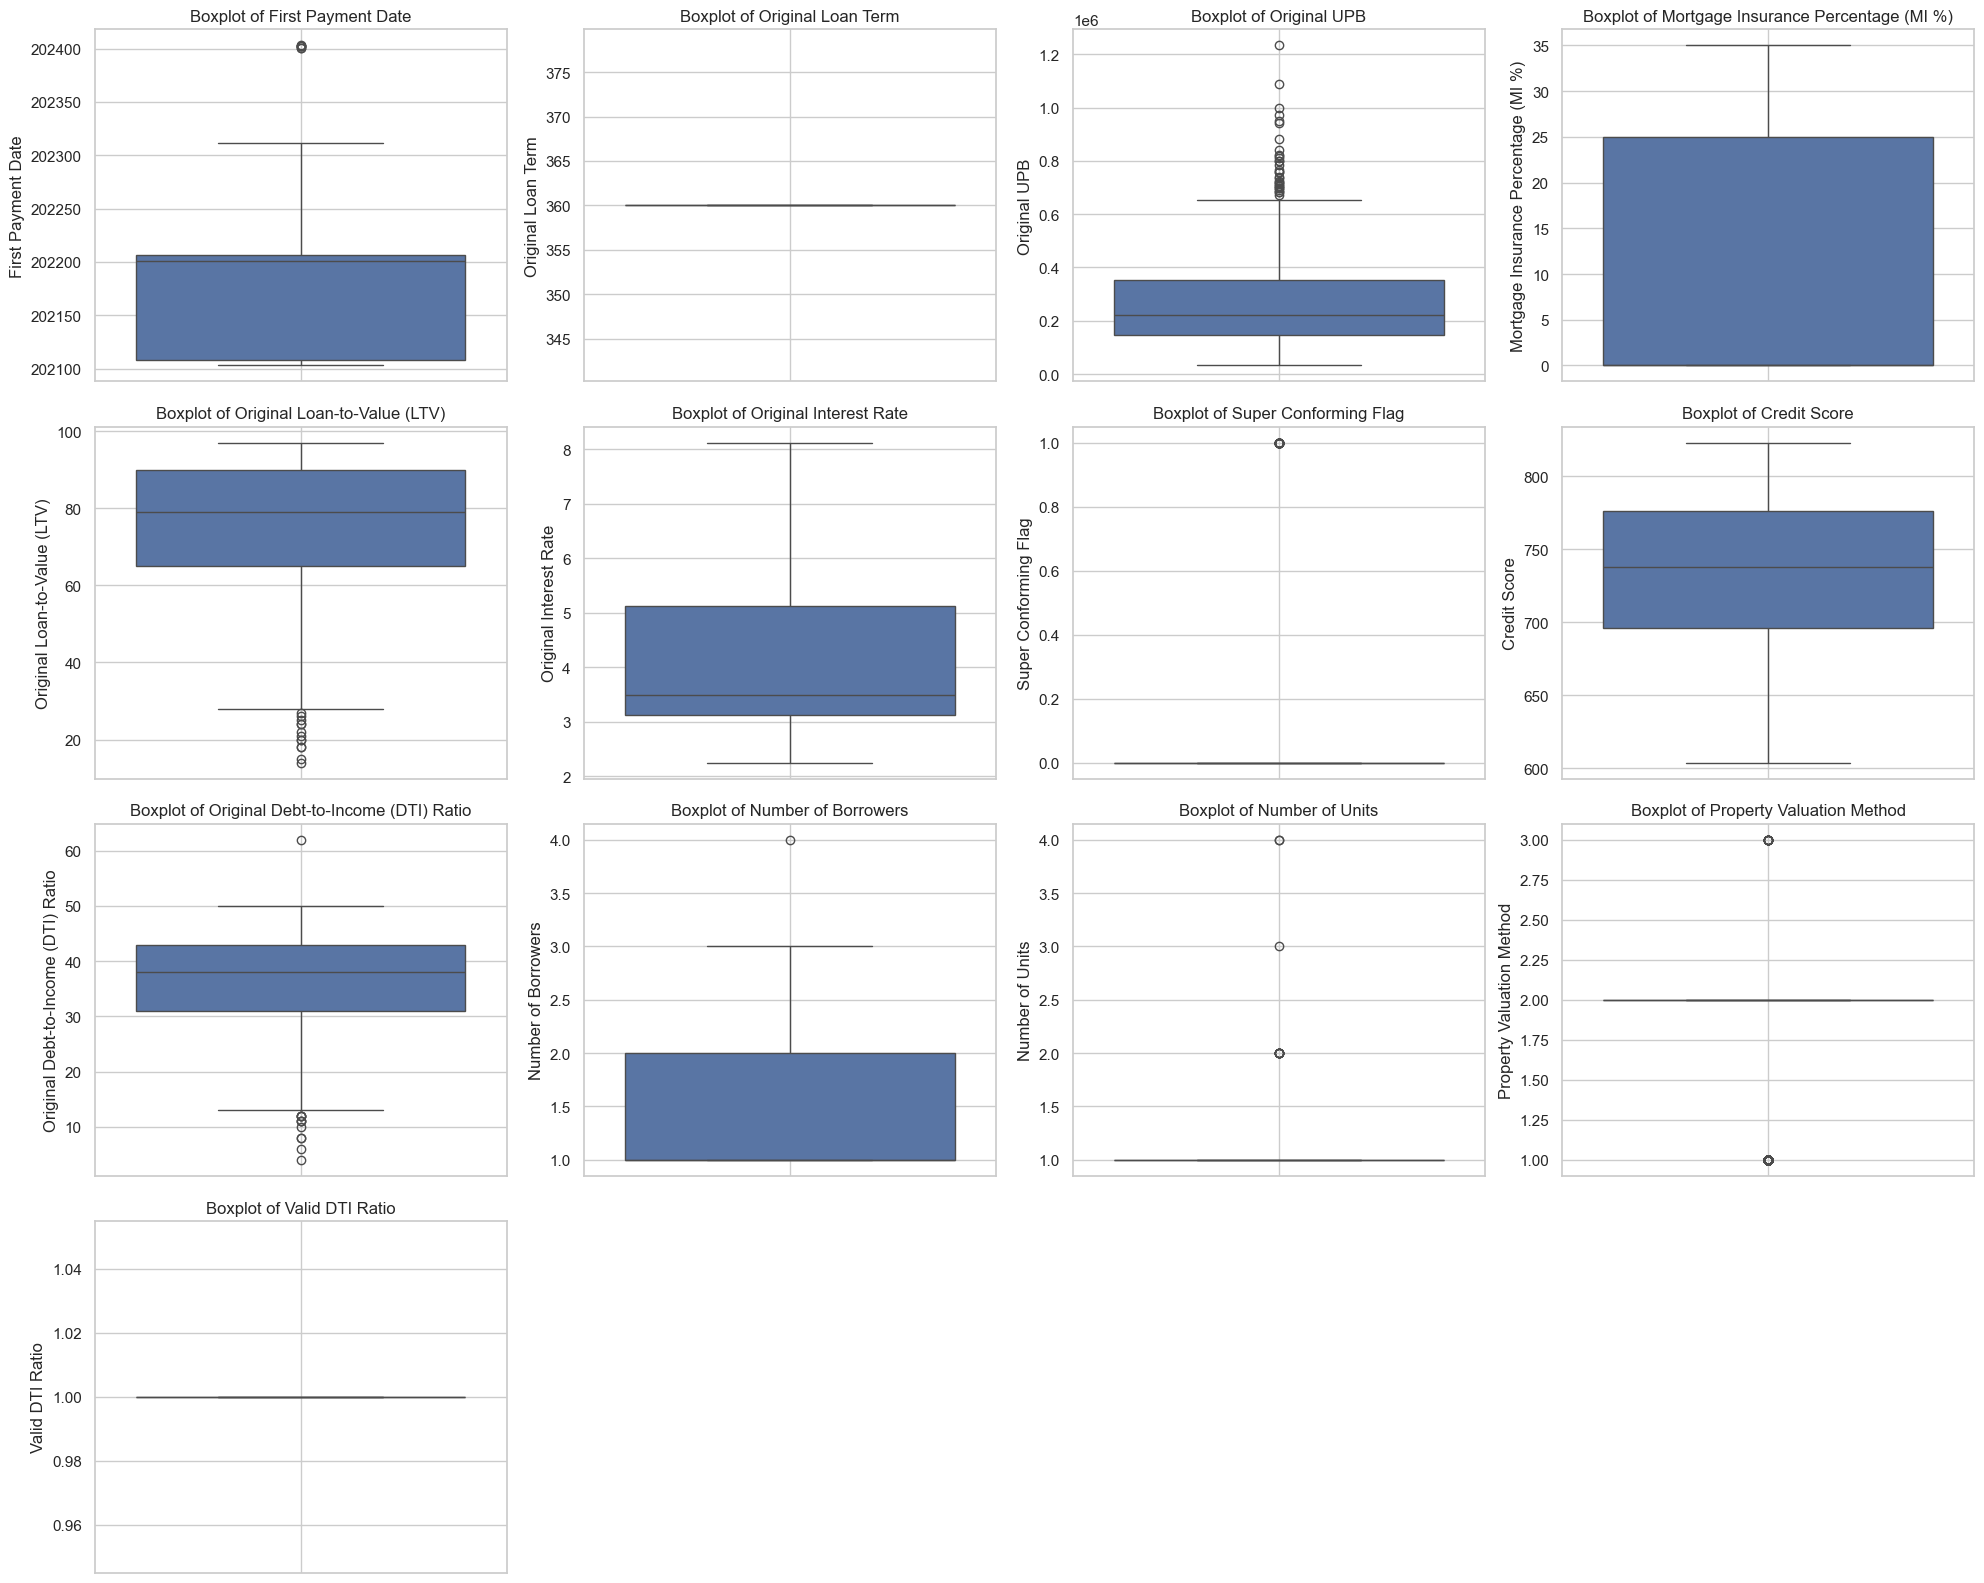

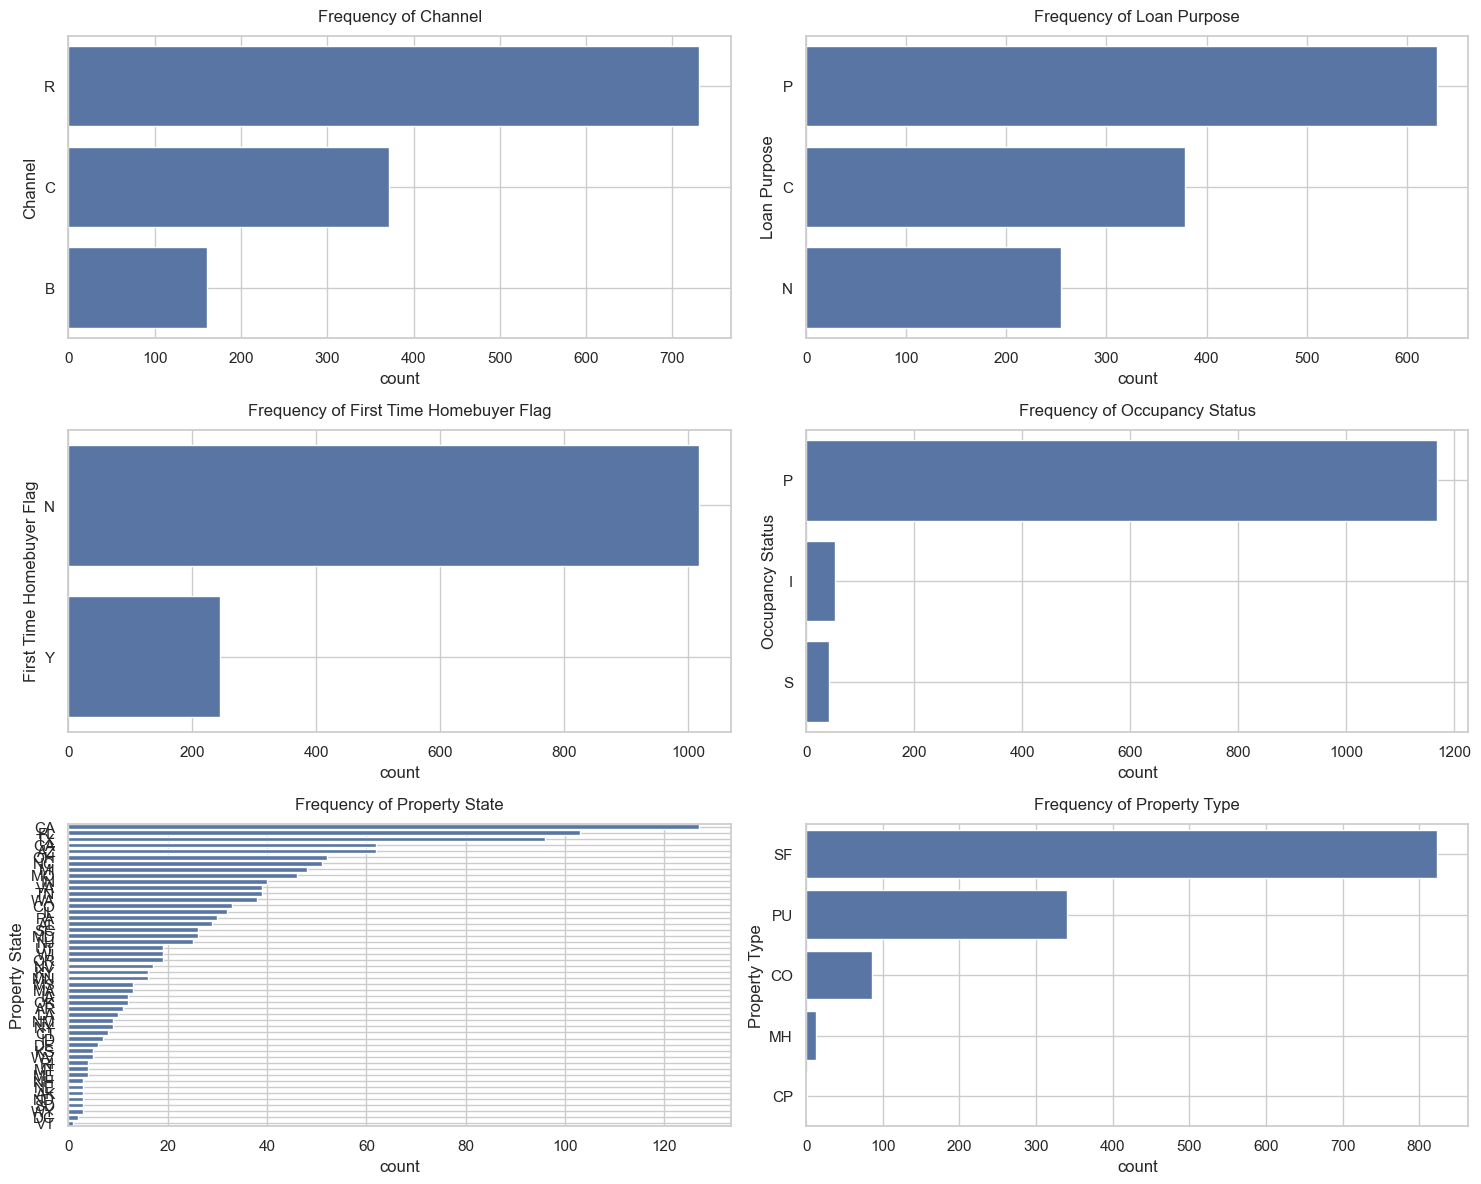

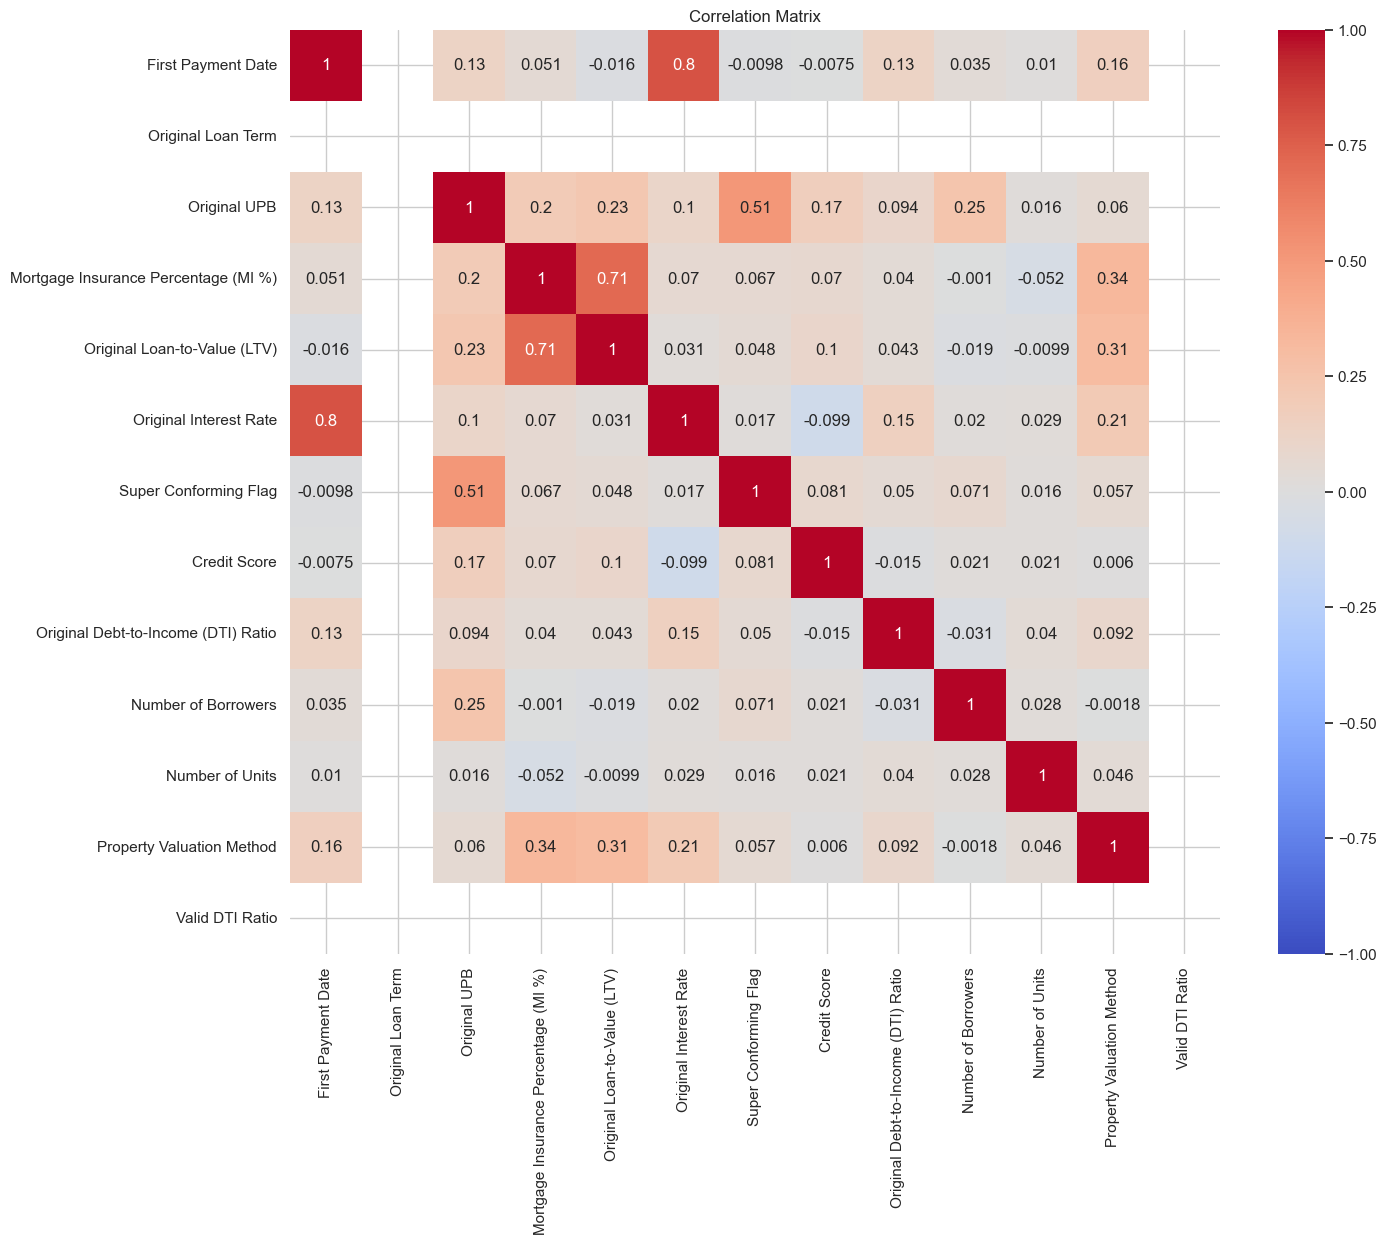

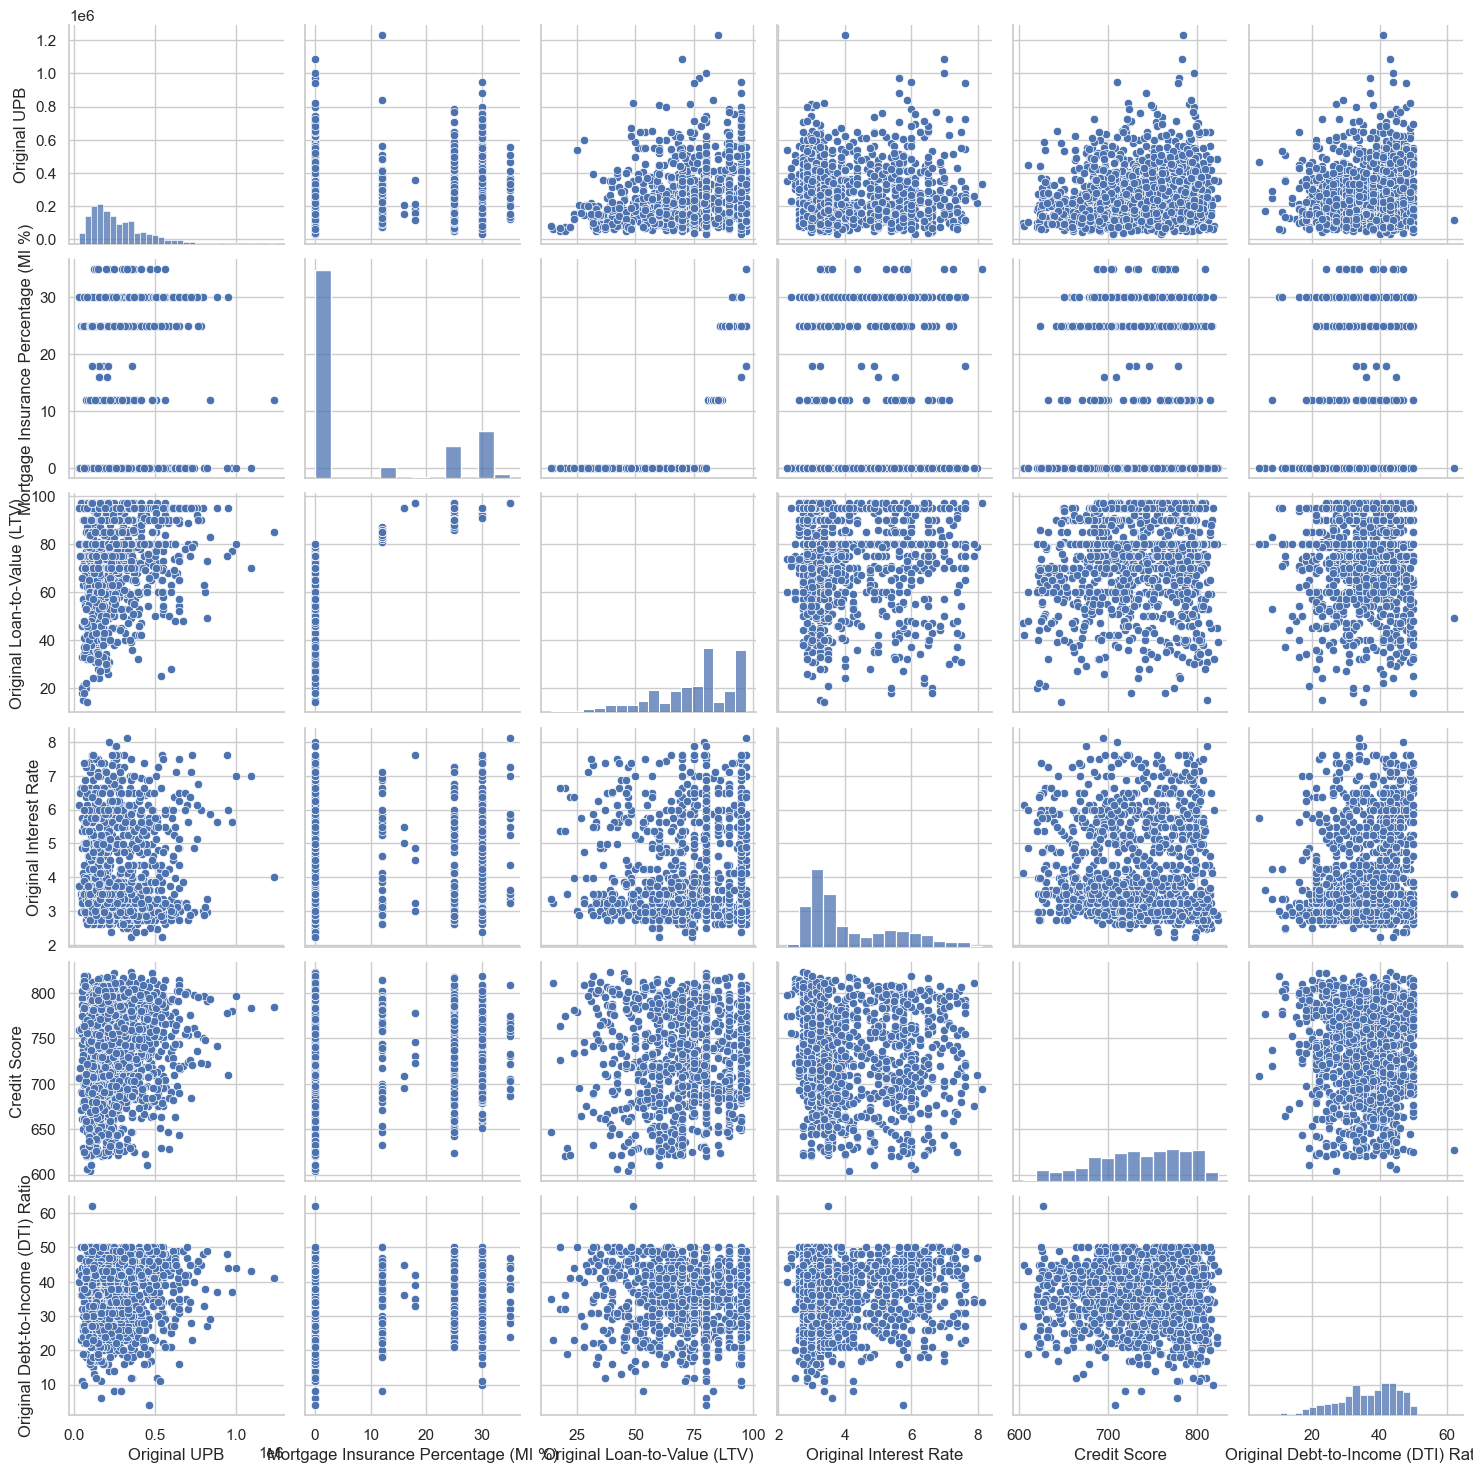

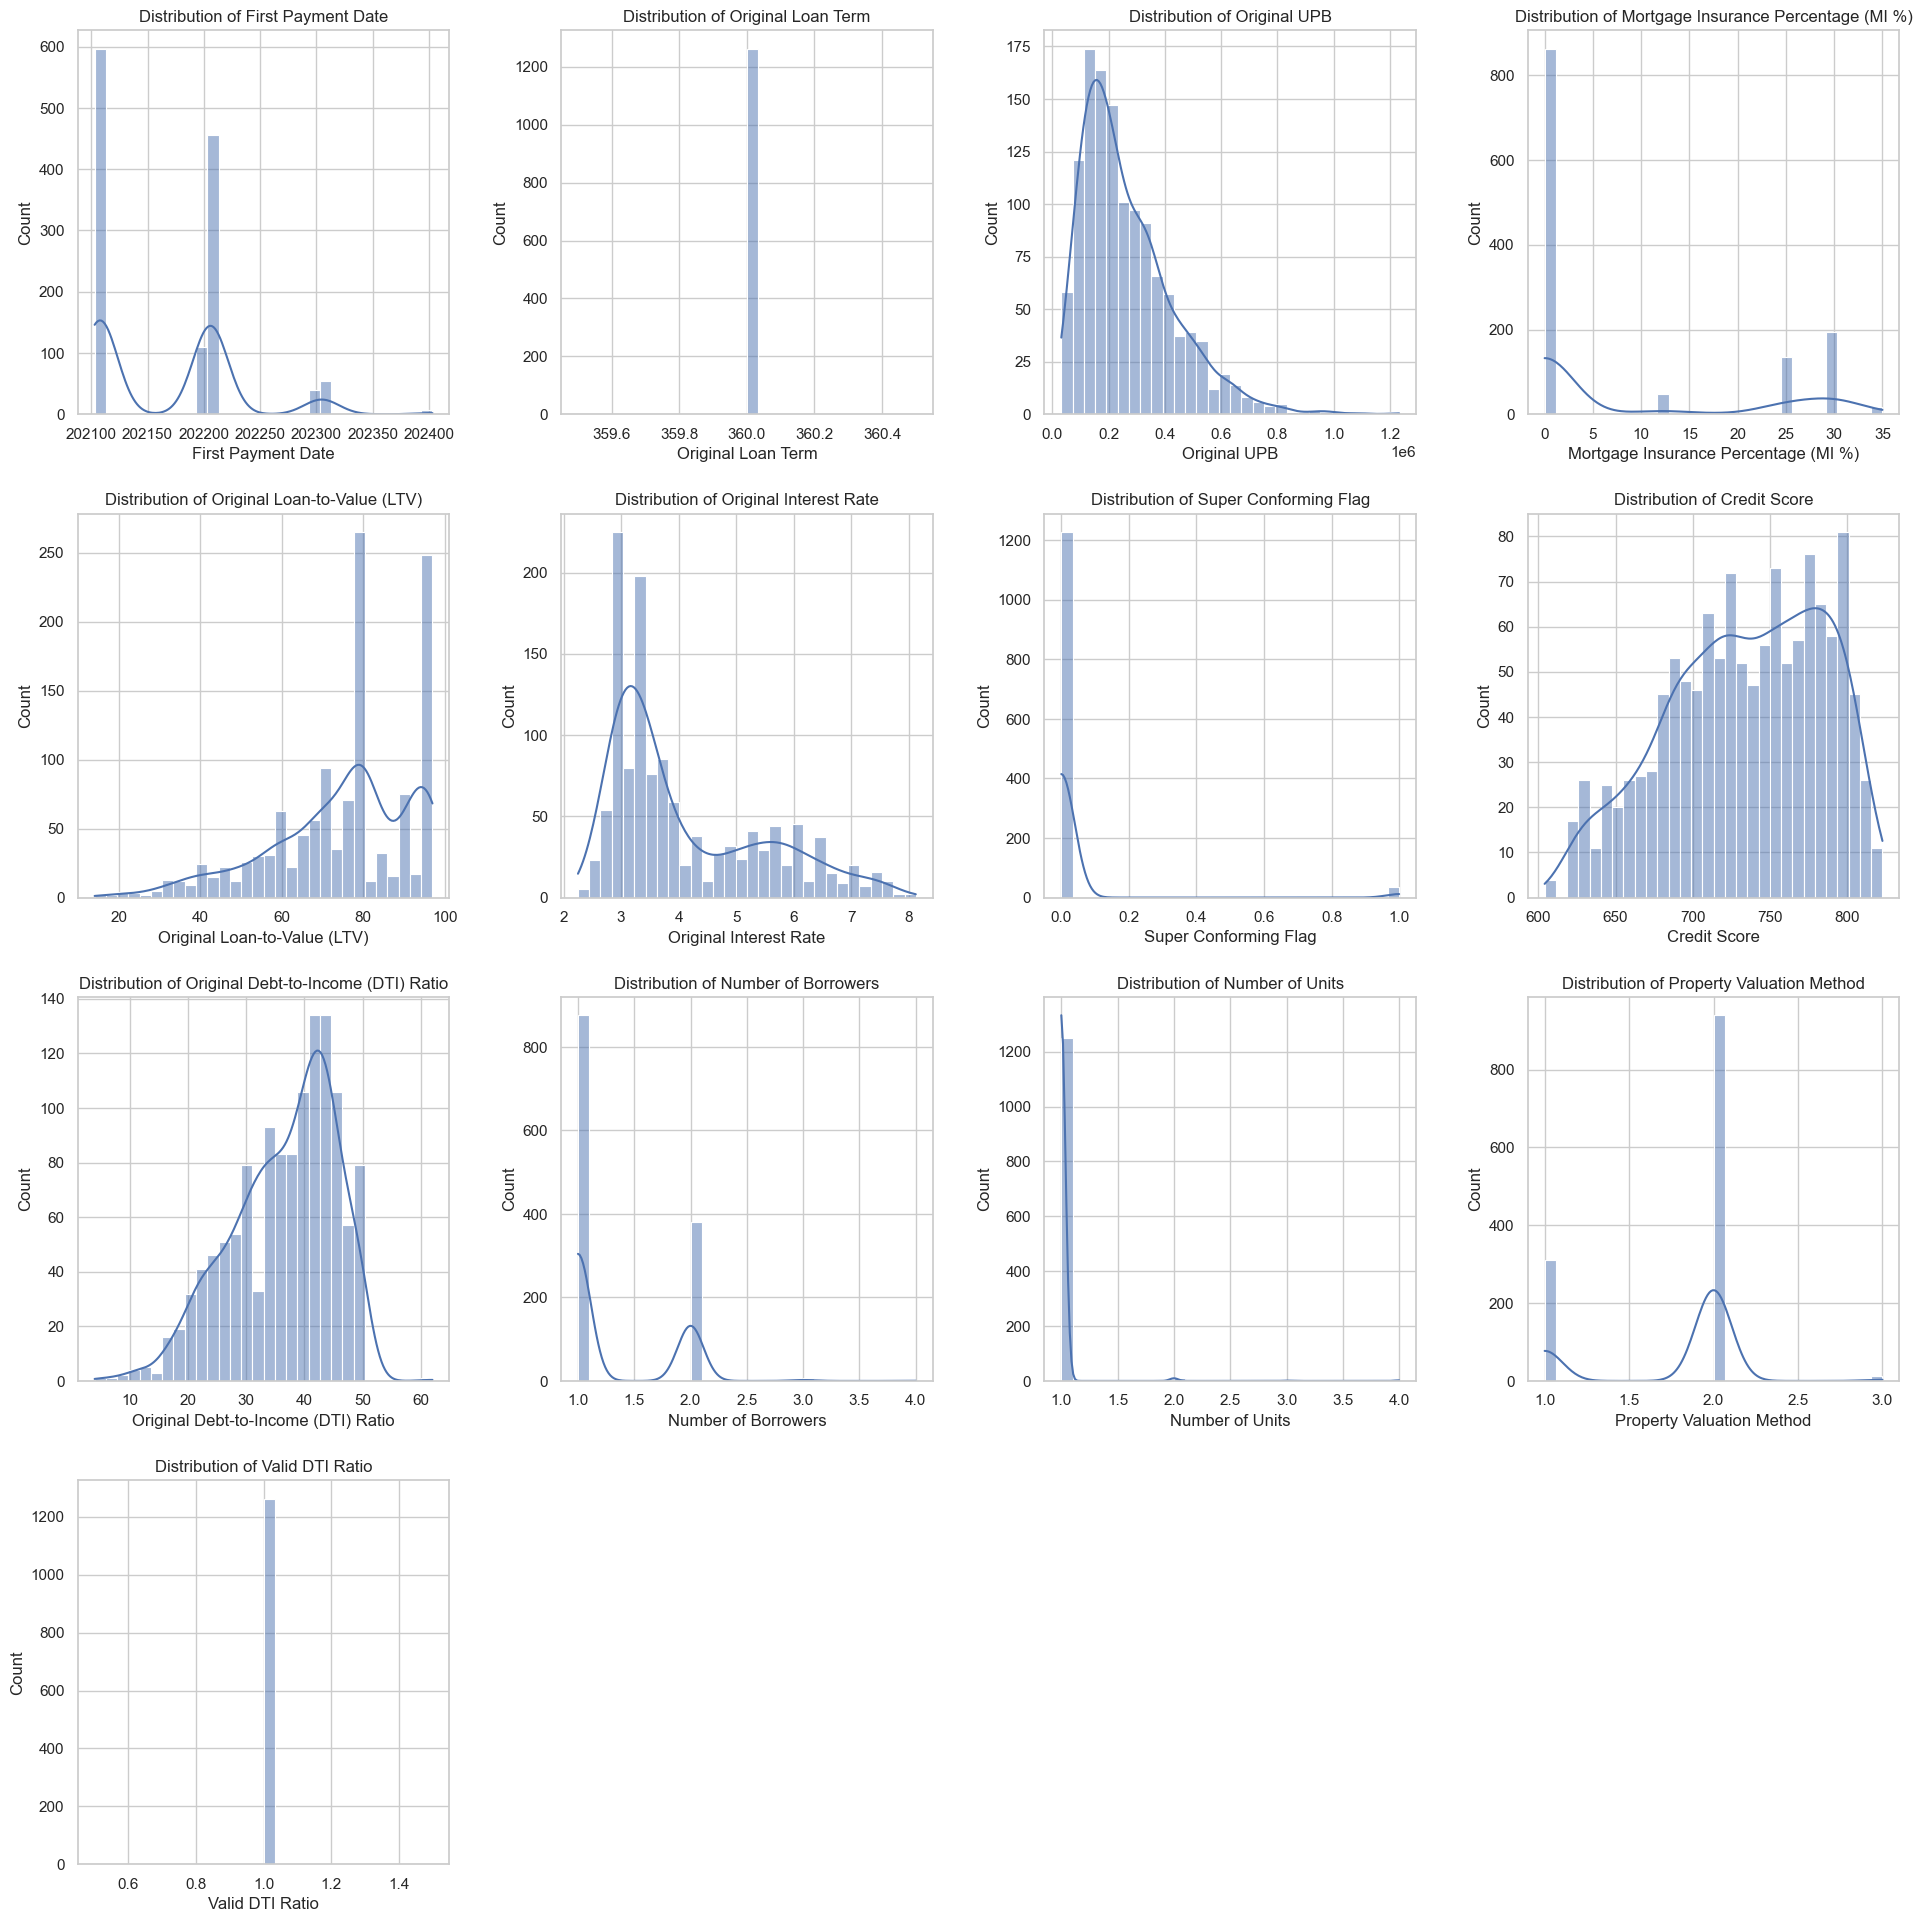

Monthly Reporting Period  Current Actual UPB  \
count              28242.000000        2.824200e+04   
mean              202260.646094        2.374414e+05   
std                   89.408397        1.634798e+05   
min               202102.000000        0.000000e+00   
25%               202205.000000        1.208446e+05   
50%               202301.000000        1.980973e+05   
75%               202309.000000        3.270000e+05   
max               202412.000000        1.261400e+06   

       Current Loan Delinquency Status      Loan Age  \
count                     28242.000000  28242.000000   
mean                          2.106366     13.057609   
std                           4.532515      9.376228   
min                           0.000000      0.000000   
25%                           0.000000      5.000000   
50%                           0.000000     12.000000   
75%                           1.000000     20.000000   
max                          38.000000     46.000000   

       Remaining Months to Legal Maturity  Zero Balance Code  \
count                        28242.000000        1263.000000   
mean                           346.942391           1.471101   
std                              9.376228           0.614597   
min                            314.000000           1.000000   
25%                            340.000000           1.000000   
50%                            348.000000           1.000000   
75%                            355.000000           2.000000   
max                            360.000000           3.000000   

       Current Interest Rate  Delinquency Due to Disaster  \
count           28242.000000                 28242.000000   
mean                3.918606                     0.031336   
std                 1.218648                     0.174228   
min                 2.250000                     0.000000   
25%                 3.000000                     0.000000   
50%                 3.375000                     0.000000   
75%                 4.625000                     0.000000   
max                 8.125000                     1.000000   

       Interest Bearing UPB  
count          2.824200e+04  
mean           2.373063e+05  
std            1.631959e+05  
min            0.000000e+00  
25%            1.208446e+05  
50%            1.980973e+05  
75%            3.260915e+05  
max            1.233000e+06

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Loan Sequence Number                28242 non-null  object 
 1   Monthly Reporting Period            28242 non-null  int64  
 2   Current Actual UPB                  28242 non-null  float64
 3   Current Loan Delinquency Status     28242 non-null  int64  
 4   Loan Age                            28242 non-null  float64
 5   Remaining Months to Legal Maturity  28242 non-null  float64
 6   Zero Balance Code                   1263 non-null   float64
 7   Current Interest Rate               28242 non-null  float64
 8   Delinquency Due to Disaster         28242 non-null  int64  
 9   Interest Bearing UPB                28242 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 2.2+ MB


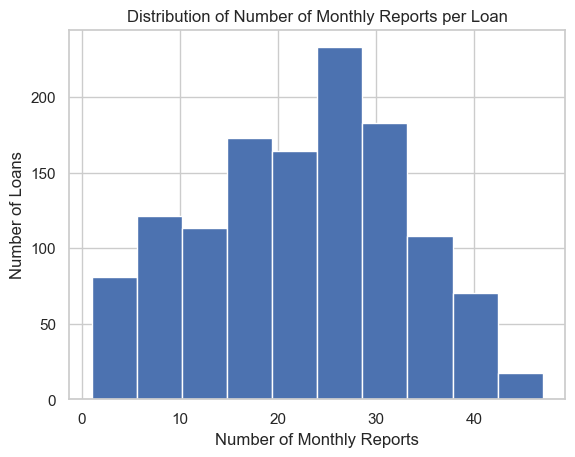

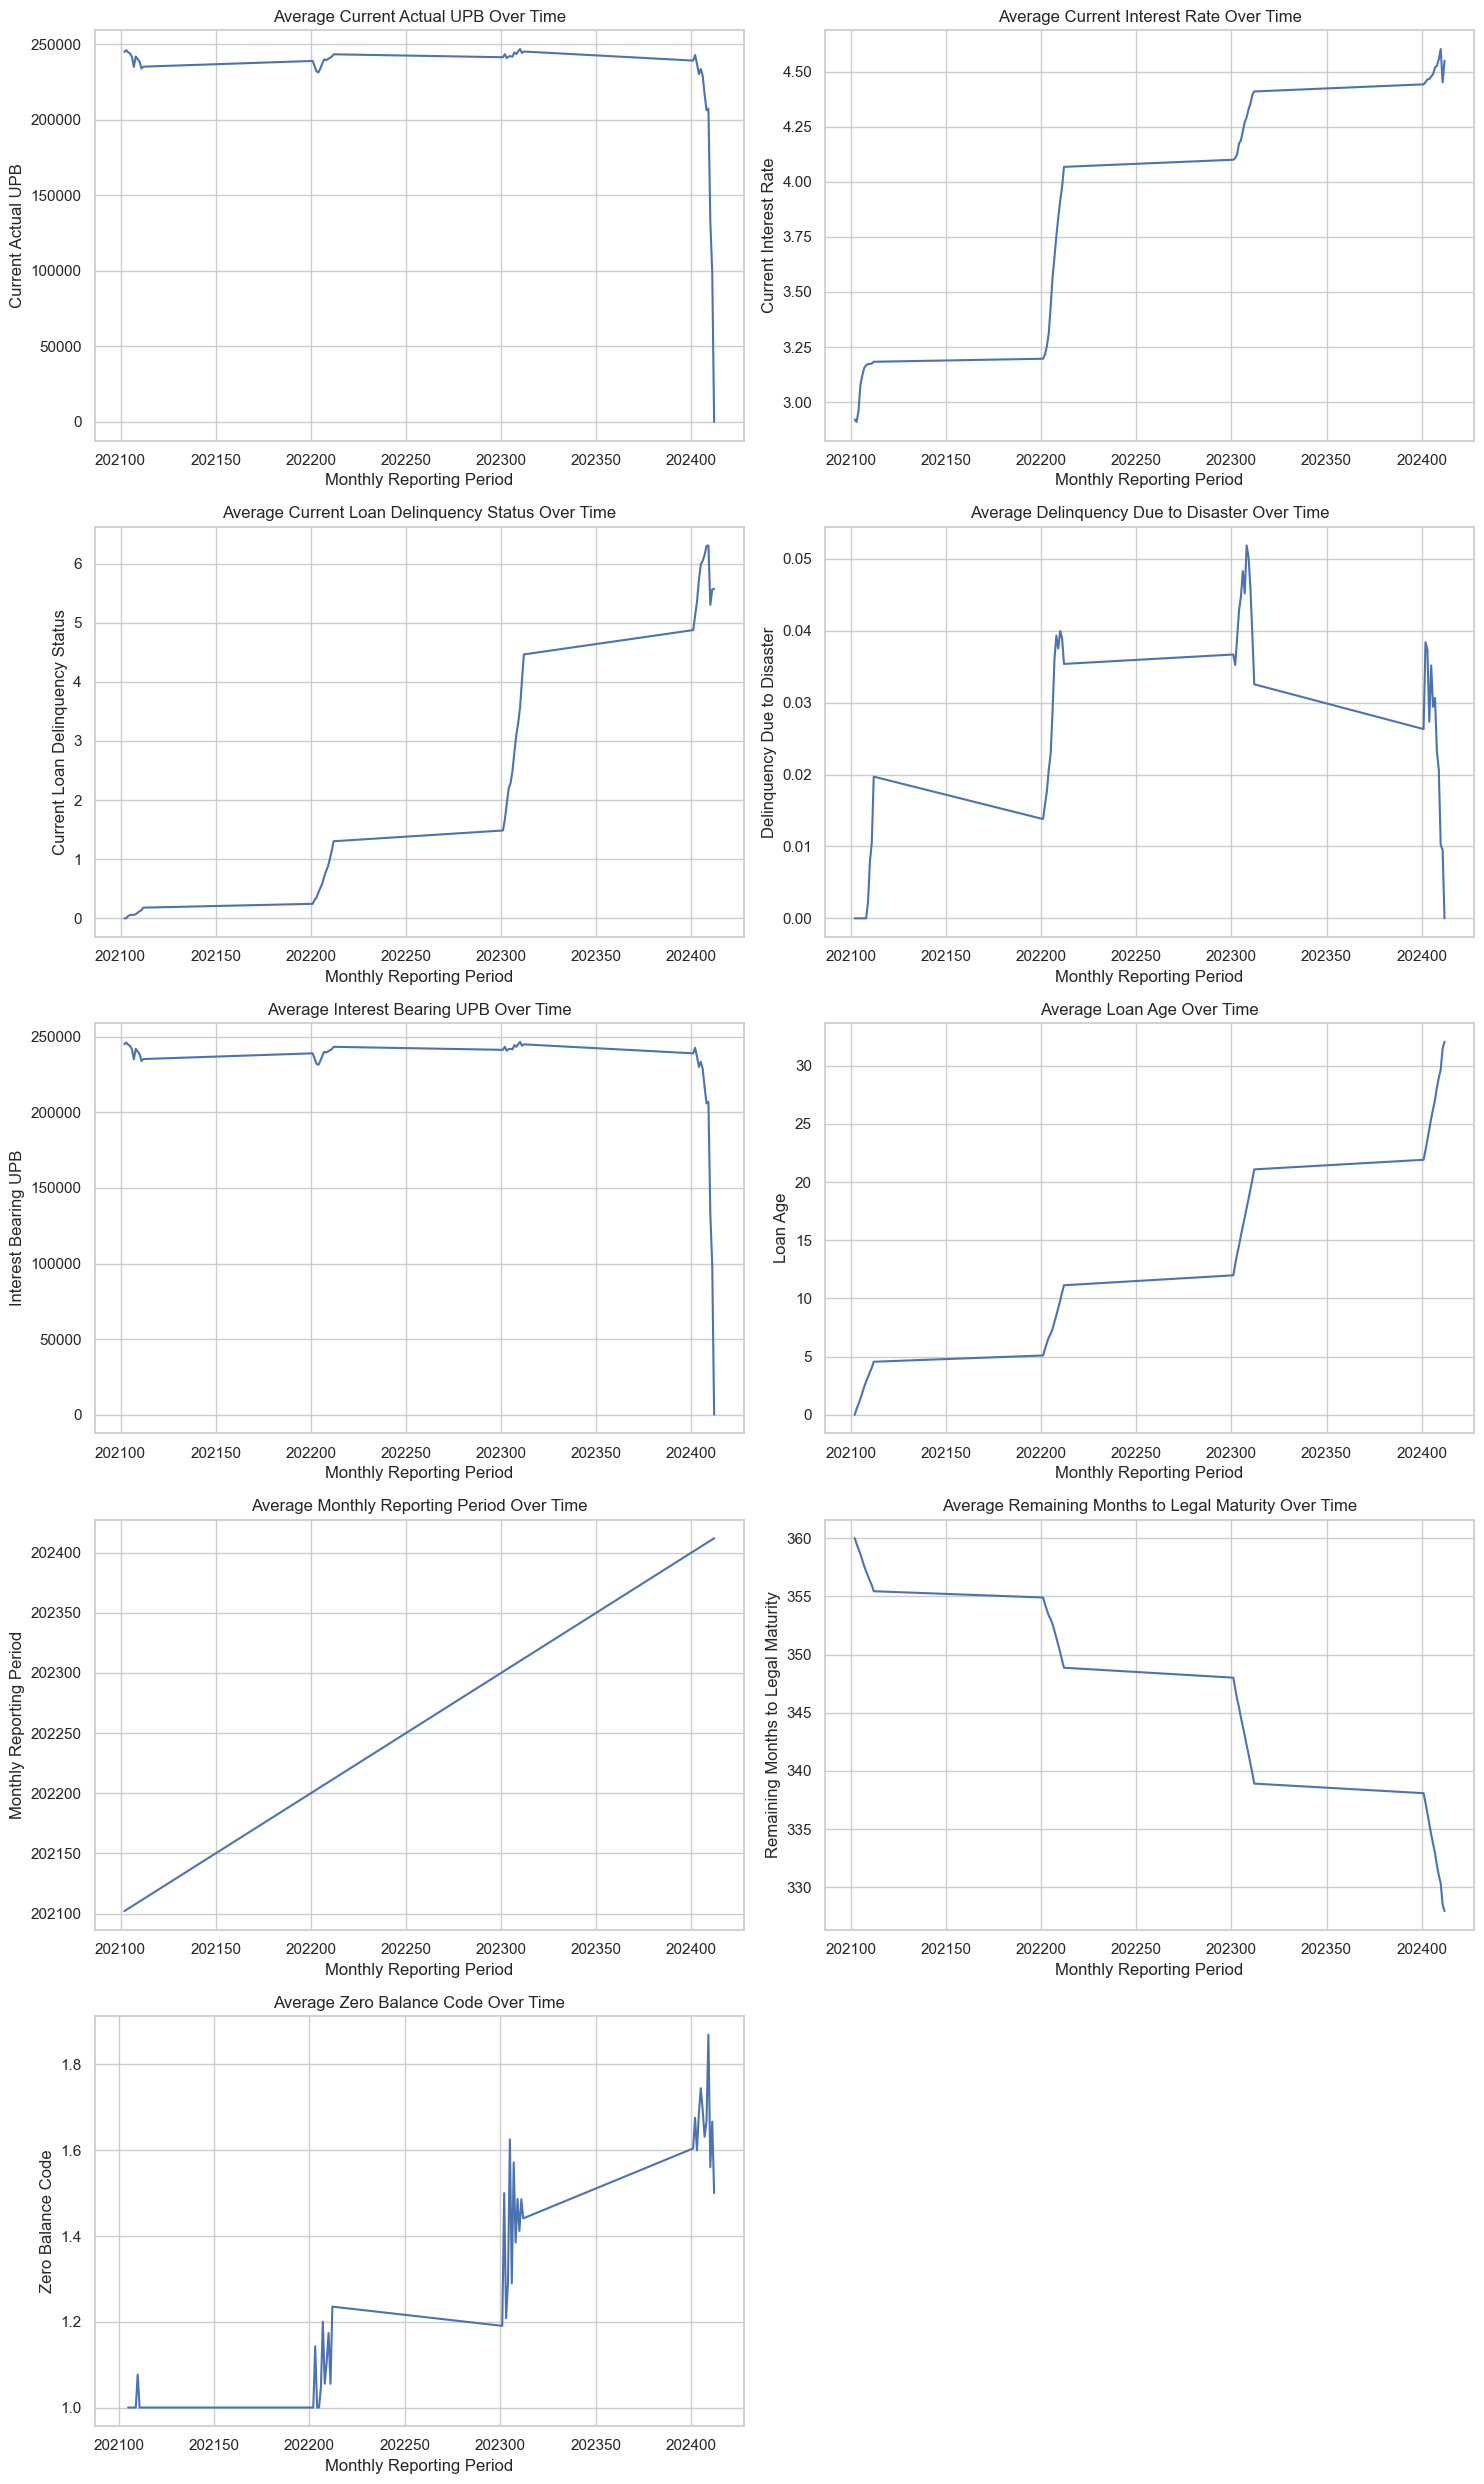

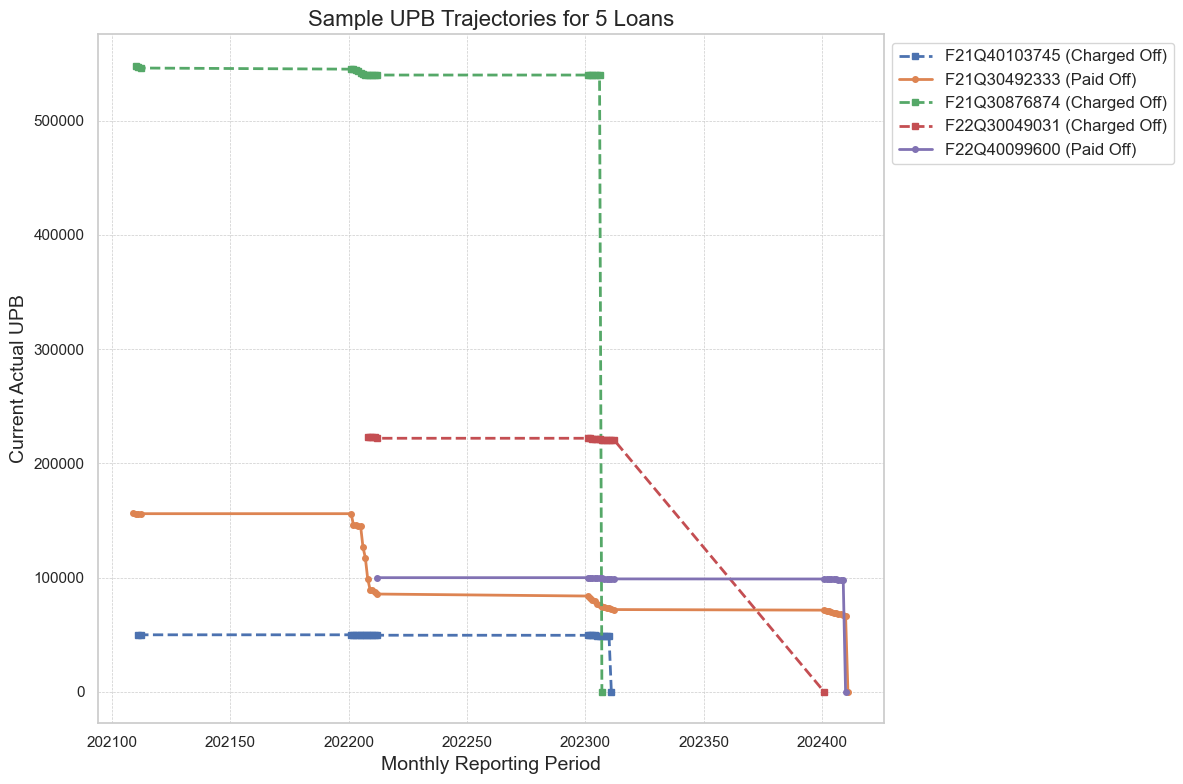

In [19]:
# Define paths
orig_csv_path = r"C:\dwaraka\github projects\Risk Analytics\Freddie_mac_raw_data\Standard_Quaterly\df_orig.csv"
monthly_csv_path = r"C:\dwaraka\github projects\Risk Analytics\Freddie_mac_raw_data\Standard_Quaterly\df_monthly.csv"

# Load CSVs
df_setup = pd.read_csv(orig_csv_path)
df_monthly = pd.read_csv(monthly_csv_path)

# Quick check
print("Origination Data:")
display(df_setup.head())

print("\nMonthly Performance Data:")
display(df_monthly.head())  

df_setup.shape
df_monthly.shape

# Setting up display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# General overview
display(df_setup.info())

# Display first few rows
display(df_setup.head())

df_setup.describe()

missing_data = df_setup.isnull().sum()
print(missing_data)

numeric_cols = df_setup.select_dtypes(include=[np.number]).columns.tolist()

# Number of plots per row
plots_per_row = 4
n = len(numeric_cols)
rows = int(np.ceil(n / plots_per_row))
cols = plots_per_row

# Histograms
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    df_setup[col].hist(ax=axes[idx], bins=50)
    axes[idx].set_title(col)
    axes[idx].grid(False)

# Hide any unused subplots
for idx in range(n, rows * cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df_setup, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')
    axes[idx].grid(True)

# Hide any unused subplots
for idx in range(n, rows * cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()  


categorical_cols = df_setup.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Loan Sequence Number')  # Exclude 'Loan Sequence Number'

# Determine the layout for subplots
n_cols = 2  # number of columns in subplot layout
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.ravel()  # Flatten the 2D array for easier iteration

for idx, col in enumerate(categorical_cols):
    sns.countplot(y=col, data=df_setup, ax=axes[idx], order=df_setup[col].value_counts().index)
    axes[idx].set_title(f'Frequency of {col}', y=1.02)  # adjust title position to avoid overlap
    axes[idx].grid(True)

# Remove unused subplots if any
for j in range(idx+1, n_cols*n_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Select only numeric columns for correlation computation
numeric_cols = df_setup.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns
corr_matrix = numeric_cols.corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show() 


# List of specified columns for the pair plot
selected_cols = [
    'Original UPB',
    'Mortgage Insurance Percentage (MI %)',
    'Original Loan-to-Value (LTV)',
    'Original Interest Rate',
    'Credit Score',
    'Original Debt-to-Income (DTI) Ratio'
]

# Plotting pair plot for the selected columns
sns.pairplot(df_setup[selected_cols])
plt.show()


numeric_columns = df_setup.select_dtypes(include=[np.number]).columns

# Determine the grid size: For simplicity, assume a square grid
grid_size = int(np.ceil(np.sqrt(len(numeric_columns))))

# Create a subplot grid
fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(20, 20))

# Adjust the space between plots
plt.tight_layout(pad=4)

# Hide any extra subplots
for ax in axes.ravel()[len(numeric_columns):]:
    ax.axis("off")

# Iterate over columns and axes to plot
for col, ax in zip(numeric_columns, axes.ravel()):
    sns.histplot(df_setup[col], kde=True, bins=30, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Count')

plt.show() 

#Loan Monthly Performance Table
display(df_monthly.describe())
df_monthly.info()

df_monthly['Loan Sequence Number'].value_counts().hist()
plt.title("Distribution of Number of Monthly Reports per Loan")
plt.xlabel("Number of Monthly Reports")
plt.ylabel("Number of Loans")
plt.show()


# Exclude 'Loan Sequence Number' and other non-numeric or non-sensible columns
columns_to_aggregate = df_monthly.select_dtypes(include=[np.number]).columns.difference(['Loan Sequence Number'])

# Aggregate by month
monthly_aggregates = df_monthly.groupby('Monthly Reporting Period')[columns_to_aggregate].mean()

# Determine the number of rows and columns for subplots based on the number of valid columns
n_cols = 2
n_rows = len(columns_to_aggregate) // n_cols + (len(columns_to_aggregate) % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# If there's only one row, ensure that axes is still indexable by [row][col]
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, column in enumerate(columns_to_aggregate):
    row, col = divmod(idx, n_cols)
    axes[row][col].plot(monthly_aggregates.index, monthly_aggregates[column])
    axes[row][col].set_title(f"Average {column} Over Time")
    axes[row][col].set_ylabel(column)
    axes[row][col].set_xlabel('Monthly Reporting Period')

# Remove any empty subplots
for idx in range(len(columns_to_aggregate), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    fig.delaxes(axes[row][col])

plt.tight_layout()
plt.show()

sample_loans = df_monthly['Loan Sequence Number'].sample(5).values

plt.figure(figsize=(12, 8))

for loan in sample_loans:
    subset = df_monthly[df_monthly['Loan Sequence Number'] == loan]
    
    # Determine the end status of the loan
    final_status = subset['Zero Balance Code'].iloc[-1]
    label_suffix = ''
    if final_status == 1:
        marker_style = 'o-'
        label_suffix = ' (Paid Off)'
    elif final_status in [2, 3, 9]:
        marker_style = 's--'
        label_suffix = ' (Charged Off)'
    else:
        marker_style = '^-'
    
    plt.plot(subset['Monthly Reporting Period'], subset['Current Actual UPB'], marker_style, label=loan + label_suffix, markersize=4, linewidth=2)

plt.title("Sample UPB Trajectories for 5 Loans", fontsize=16)
plt.xlabel("Monthly Reporting Period", fontsize=14)
plt.ylabel("Current Actual UPB", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)  # Move the legend to the right side of the plot
plt.tight_layout()

plt.show()


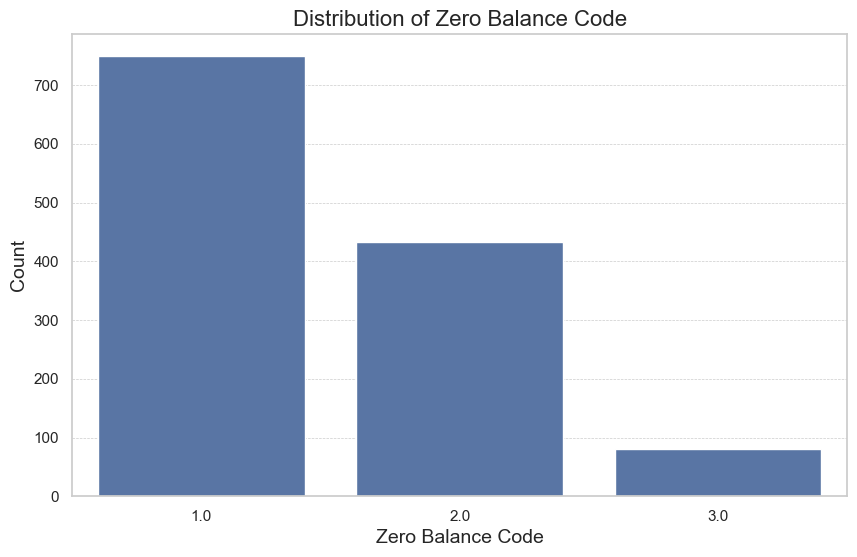

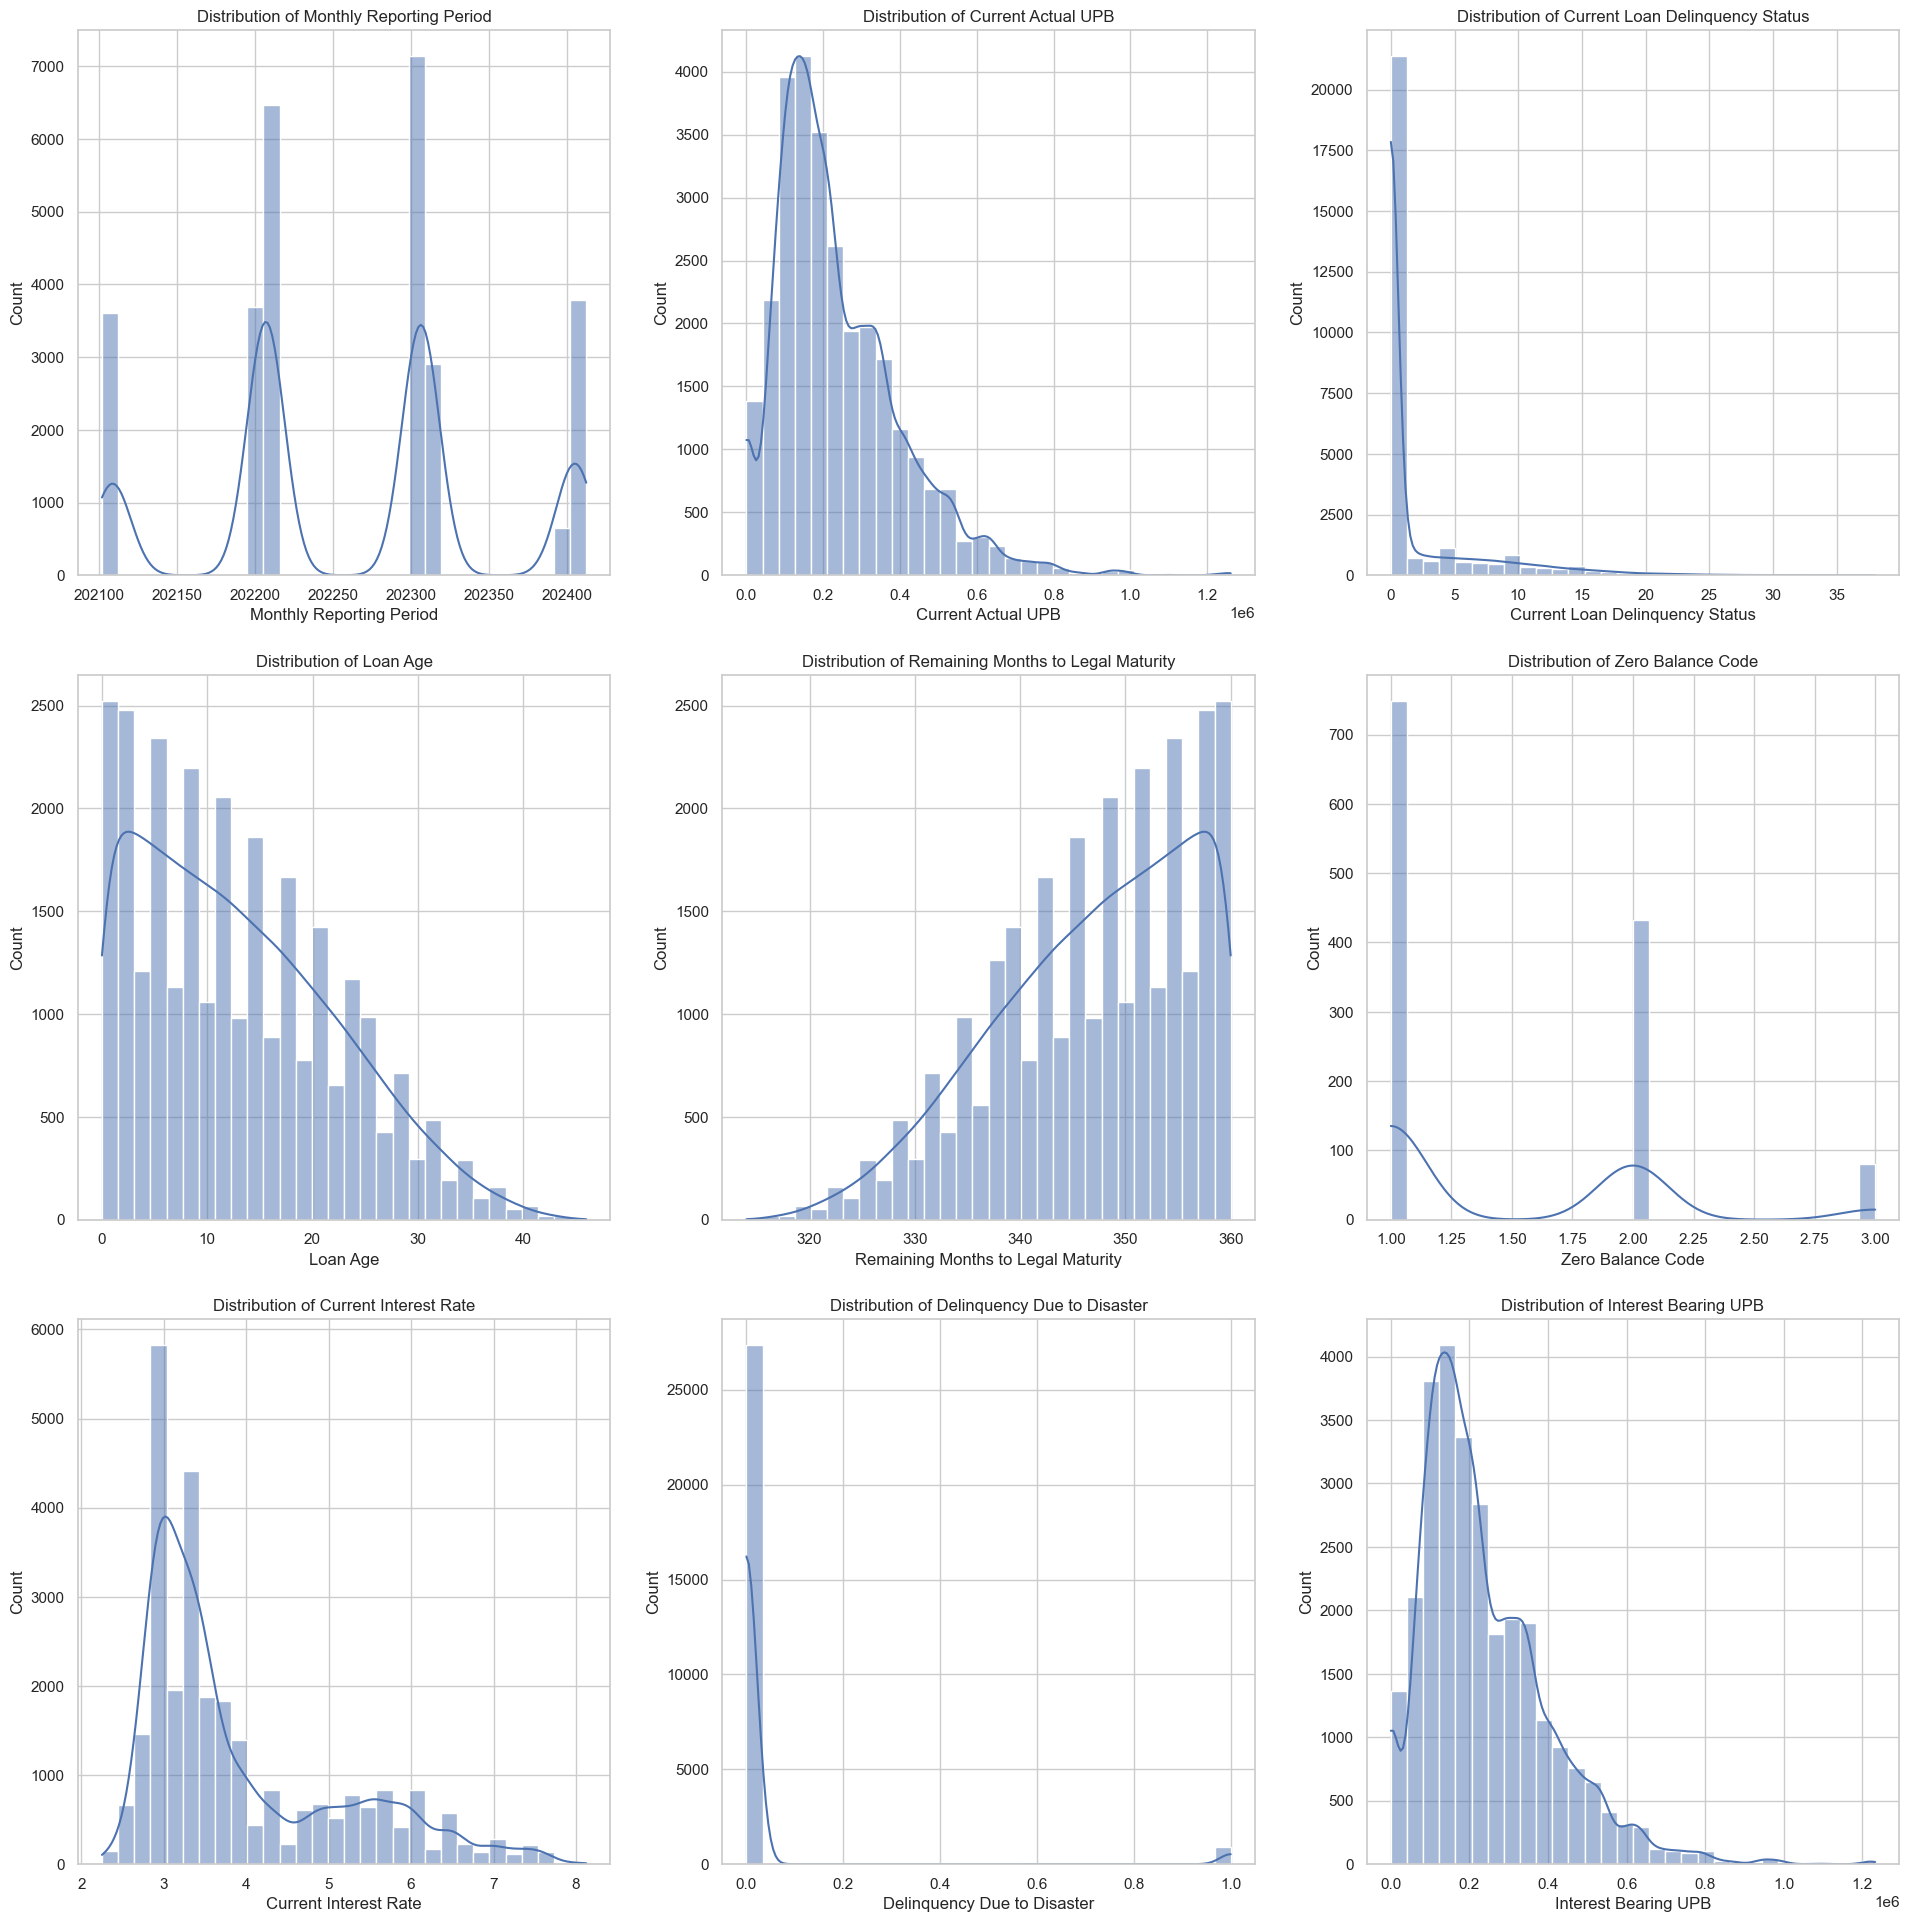

Codes in 'df_setup' but not in 'df_housing_price': set()
Codes in 'df_housing_price' but not in 'df_setup': {'HI'}


In [20]:
# Calculate the distribution of 'Zero Balance Code'
zero_balance_counts = df_monthly['Zero Balance Code'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=zero_balance_counts.index, y=zero_balance_counts.values)

plt.title('Distribution of Zero Balance Code', fontsize=16)
plt.xlabel('Zero Balance Code', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)

plt.show() 


# Assuming df_monthly is already defined and is the DataFrame you're working with
numeric_columns = df_monthly.select_dtypes(include=[np.number]).columns

# Determine the grid size: For simplicity, assume a square grid
grid_size = int(np.ceil(np.sqrt(len(numeric_columns))))

# Create a subplot grid
fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(20, 20))

# Adjust the space between plots
plt.tight_layout(pad=4)

# Hide any extra subplots
for ax in axes.ravel()[len(numeric_columns):]:
    ax.axis("off")

# Iterate over columns and axes to plot
for col, ax in zip(numeric_columns, axes.ravel()):
    sns.histplot(df_monthly[col], kde=True, bins=30, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Count')

plt.show()



df_combined = pd.merge(df_monthly, df_setup, on='Loan Sequence Number')
df_combined = df_combined.sort_values(by=['Loan Sequence Number', 'Loan Age'], ascending=[True, True])
df_combined

#Create a new adj_time column that is one month earlier than the reported period
# Convert 'Monthly Reporting Period' to datetime
df_combined['Monthly Reporting Period'] = pd.to_datetime(df_combined['Monthly Reporting Period'], format='%Y%m')

# Subtract one month
df_combined['adj_time'] = df_combined['Monthly Reporting Period'] - pd.DateOffset(months=1)

# Convert 'adj_time' back to the original format YYYYMM
df_combined['adj_time'] = df_combined['adj_time'].dt.strftime('%Y%m')
df_combined


#Import & Merge Economic Indicator

#Housing Price index

#df_housing_price = pd.read_csv('/Users/miracles/Desktop/practicum/Reference data/fmhpi_master_file.csv')
df_housing_price



# Get unique values from both columns
codes_in_housing_price = set(df_housing_price[df_housing_price['GEO_Type'] == 'State']['GEO_Name'].unique())
codes_in_setup = set(df_setup['Property State'].unique())

# Find the difference
codes_in_setup_not_in_housing_price = codes_in_setup - codes_in_housing_price

# Print the unique values that are in df_setup but not in df_housing_price
print(f"Codes in 'df_setup' but not in 'df_housing_price': {codes_in_setup_not_in_housing_price}")

# Find the difference
codes_in_housing_price_not_in_setup = codes_in_housing_price - codes_in_setup

# Print the unique values that are in df_housing_price but not in df_setup
print(f"Codes in 'df_housing_price' but not in 'df_setup': {codes_in_housing_price_not_in_setup}") 

Number of matched rows: 28242
Number of unmatched rows: 0
CPI merge complete
Matched: 28242
Unmatched: 0
Number of matched rows: 28242
Number of unmatched rows: 0
Number of matched rows: 28212
Number of unmatched rows: 30
Recession merge complete
Matched: 28242
Unmatched: 0


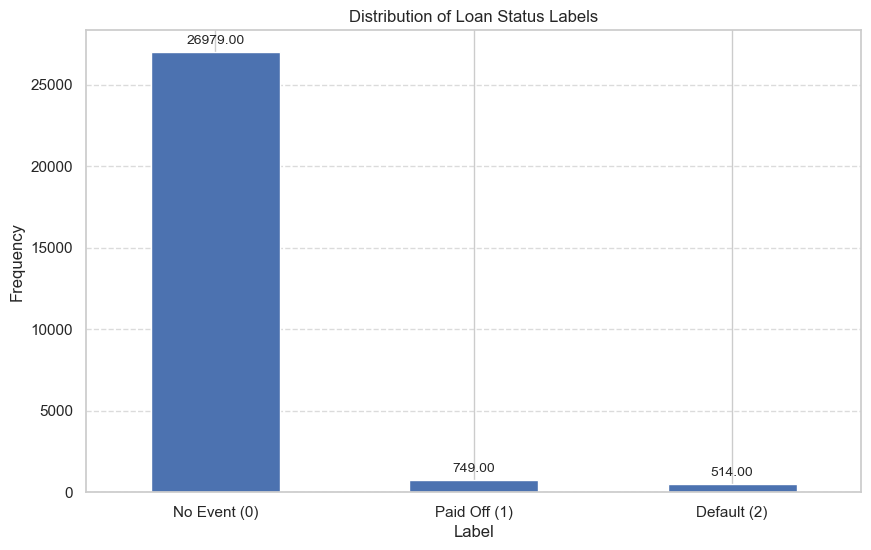

Loan Sequence Number Monthly Reporting Period  Current Actual UPB  \
0         F21Q11280918               2021-02-01            141000.0   
1         F21Q11280918               2021-03-01            140000.0   
2         F21Q11280918               2021-04-01            140000.0   
3         F21Q11280918               2021-05-01            140000.0   
4         F21Q11280918               2021-06-01                 0.0   

   Current Loan Delinquency Status  Loan Age  \
0                                0       0.0   
1                                0       1.0   
2                                0       2.0   
3                                0       3.0   
4                                0       4.0   

   Remaining Months to Legal Maturity  Current Interest Rate  \
0                               360.0                  2.875   
1                               359.0                  2.875   
2                               358.0                  2.875   
3                               357.0                  2.875   
4                               356.0                  2.875   

   Delinquency Due to Disaster  Interest Bearing UPB  Original UPB  \
0                            0              141000.0      141000.0   
1                            0              140000.0      141000.0   
2                            0              140000.0      141000.0   
3                            0              140000.0      141000.0   
4                            0                   0.0      141000.0   

   Mortgage Insurance Percentage (MI %)  Original Loan-to-Value (LTV)  \
0                                  25.0                          90.0   
1                                  25.0                          90.0   
2                                  25.0                          90.0   
3                                  25.0                          90.0   
4                                  25.0                          90.0   

   Original Interest Rate Channel Loan Purpose  Super Conforming Flag  \
0                   2.875       R            P                      0   
1                   2.875       R            P                      0   
2                   2.875       R            P                      0   
3                   2.875       R            P                      0   
4                   2.875       R            P                      0   

   Credit Score First Time Homebuyer Flag  \
0         689.0                         N   
1         689.0                         N   
2         689.0                         N   
3         689.0                         N   
4         689.0                         N   

   Original Debt-to-Income (DTI) Ratio  Number of Borrowers  Number of Units  \
0                                 35.0                  2.0              1.0   
1                                 35.0                  2.0              1.0   
2                                 35.0                  2.0              1.0   
3                                 35.0                  2.0              1.0   
4                                 35.0                  2.0              1.0   

  Occupancy Status Property Type  Property Valuation Method  Valid DTI Ratio  \
0                P            SF                        2.0                1   
1                P            SF                        2.0                1   
2                P            SF                        2.0                1   
3                P            SF                        2.0                1   
4                P            SF                        2.0                1   

   Housing Price       CPI  Unemployment_Rate  Recession  Label  
0     155.760518  1.391588                6.1        0.2      0  
1     157.381874  1.403014                6.1        0.2      0  
2     159.101479  1.592602                6.0        0.2      0  
3     161.061971  2.212664                5.9        0.3      0  
4     163.395493  2.569395             

In [30]:
# Part 3: Loan + Macro Merge

# Step 1: Split 'adj_time' into 'year' and 'month'
df_combined['adj_year'] = df_combined['adj_time'].str[:4].astype(int)
df_combined['adj_month'] = df_combined['adj_time'].str[4:].astype(int)

# Step 2: Filter 'df_housing_price' to include only rows where 'GEO_Type' is 'State'
df_housing_price_state = df_housing_price[df_housing_price['GEO_Type'] == 'State']

# Step 3: Merge 'df_combined' with 'df_housing_price_state'
df_merged = pd.merge(
    df_combined,
    df_housing_price_state[['Year', 'Month', 'GEO_Name', 'Index_SA']],
    left_on=['adj_year', 'adj_month', 'Property State'],
    right_on=['Year', 'Month', 'GEO_Name'],
    how='left'
)

# Step 4: Drop the 'Year' and 'Month' columns from 'df_housing_price' if you don't need them
df_merged.drop(columns=['Year', 'Month','GEO_Name'], inplace=True)

# Step 5: Determine the count of matched and unmatched rows
matched_rows = df_merged['Index_SA'].notnull().sum()
unmatched_rows = df_merged['Index_SA'].isnull().sum()

print(f"Number of matched rows: {matched_rows}")
print(f"Number of unmatched rows: {unmatched_rows}")

df_merged = df_merged.rename(columns = {'Index_SA':'Housing Price'})

# df_unmatched = df_merged[df_merged['GEO_Name'].isnull()]
# df_matched = df_merged[df_merged['GEO_Name'].notnull()]

#df_cpi = pd.read_csv('/Users/miracles/Desktop/practicum/Reference data/cpi.csv')

# Clean column names
df_cpi.columns = df_cpi.columns.str.strip()

# Rename CPI column safely
if 'CORESTICKM159SFRBATL' in df_cpi.columns:
    df_cpi.rename(columns={'CORESTICKM159SFRBATL': 'CPI'}, inplace=True)

# Automatically detect date column
date_col = [col for col in df_cpi.columns if 'date' in col.lower()]

if len(date_col) == 0:
    raise ValueError("No date column found in CPI dataset")

date_col = date_col[0]

# Convert to datetime
df_cpi[date_col] = pd.to_datetime(df_cpi[date_col])

# Create merge keys
df_cpi['year'] = df_cpi[date_col].dt.year
df_cpi['month'] = df_cpi[date_col].dt.month

# Merge
df_merged = pd.merge(
    df_merged,
    df_cpi[['year', 'month', 'CPI']],
    left_on=['adj_year', 'adj_month'],
    right_on=['year', 'month'],
    how='left'
)

df_merged.drop(columns=['year', 'month'], inplace=True)

print("CPI merge complete")
print("Matched:", df_merged['CPI'].notnull().sum())
print("Unmatched:", df_merged['CPI'].isnull().sum())


print(f"Number of matched rows: {matched_rows}")
print(f"Number of unmatched rows: {unmatched_rows}")
 
    
df_unemployment_state = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\LAUS\laus_filtered_monthly_cleaned.csv")
df_unemployment_state

state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Assuming your df_merged and state_abbreviations dictionary are already defined as shown earlier

# Map the full state names to their abbreviations in df_unemployment_state
df_unemployment_state['State_abbr'] = df_unemployment_state['area_name'].map(state_abbreviations)

# Now create a new DataFrame with only the columns you need
df_unemployment_state_reduced = df_unemployment_state[['year', 'month', 'State_abbr', '% Unemployed']]

# Now perform the merge using the new 'State_abbr' column
df_merged = pd.merge(df_merged,
                           df_unemployment_state_reduced,
                           left_on=['Property State', 'adj_year', 'adj_month'],
                           right_on=['State_abbr', 'year', 'month'],
                           how='left')

# Rename the column to your desired name if needed
df_merged.rename(columns={'% Unemployed': 'Unemployment_Rate'}, inplace=True)

# After the merge, check the number of matched and unmatched rows
matched_rows = df_merged['Unemployment_Rate'].notnull().sum()
unmatched_rows = df_merged['Unemployment_Rate'].isnull().sum()

print(f"Number of matched rows: {matched_rows}")
print(f"Number of unmatched rows: {unmatched_rows}")
df_merged.drop(columns=['State_abbr', 'year', 'month'], inplace=True) 


#df_recession = pd.read_csv('/Users/miracles/Desktop/practicum/Reference data/GDP-based Recession index.csv')


# Clean column names
df_recession.columns = df_recession.columns.str.strip()

# Rename recession column
if 'JHGDPBRINDX' in df_recession.columns:
    df_recession.rename(columns={'JHGDPBRINDX': 'Recession'}, inplace=True)

# Detect date column automatically
date_col = [col for col in df_recession.columns if 'date' in col.lower()]

if len(date_col) == 0:
    raise ValueError("No date column found in recession dataset")

date_col = date_col[0]

# Convert to datetime
df_recession[date_col] = pd.to_datetime(df_recession[date_col])

# Extract year + quarter
df_recession['Year'] = df_recession[date_col].dt.year
df_recession['Quarter'] = df_recession[date_col].dt.quarter

# Create quarter in df_merged
df_merged['Quarter'] = ((df_merged['adj_month'] - 1) // 3) + 1

# Merge recession data
df_merged = pd.merge(
    df_merged,
    df_recession[['Year', 'Quarter', 'Recession']],
    left_on=['adj_year', 'Quarter'],
    right_on=['Year', 'Quarter'],
    how='left'
)

df_merged.drop(columns=['Year'], inplace=True, errors='ignore')

print("Recession merge complete")
print("Matched:", df_merged['Recession'].notnull().sum())
print("Unmatched:", df_merged['Recession'].isnull().sum())

# Fill missing values with the average of the same 'adj_year' and 'Quarter'
for column in ['Housing Price', 'CPI', 'Unemployment_Rate', 'Recession']:
    df_merged[column] = df_merged.groupby(['adj_year', 'Quarter'])[column].transform(lambda x: x.fillna(x.mean()))

df_merged.drop(columns=['Quarter'], inplace=True)
df_merged

# Define a new function to create labels based on 'Zero Balance Code'
def create_labels(zero_balance_code):
    if pd.isna(zero_balance_code):
        return 0  # No event
    elif zero_balance_code == 1:
        return 1  # Loan Paid Off
    elif zero_balance_code in [2, 3, 9]:
        return 2  # Default
    else:
        return -1  # Just in case there are other codes not accounted for

# Apply the function to the 'Zero Balance Code' column to create a new 'Label' column
df_merged['Label'] = df_merged['Zero Balance Code'].apply(create_labels)

# Verify the new labels
df_merged[['Zero Balance Code', 'Label']].head()
 
    
# Assuming df_merged already has the 'Label' column with the new labels
label_counts = df_merged['Label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = label_counts.plot(kind='bar')
plt.title('Distribution of Loan Status Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['No Event (0)', 'Paid Off (1)', 'Default (2)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the bar plot with the values
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f'), 
                  (bar.get_x() + bar.get_width() / 2, 
                   bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Show the plot
plt.show()


# columns not needed in modeling
columns_to_drop = ['Original Loan Term', 'Zero Balance Code', 'First Payment Date', 'adj_time', 'adj_year', 'adj_month', 'Property State']

# Drop the columns from df_merged
df_final = df_merged.drop(columns=columns_to_drop)

# Display the first few rows of the updated DataFrame to confirm the drop
df_final.head() 

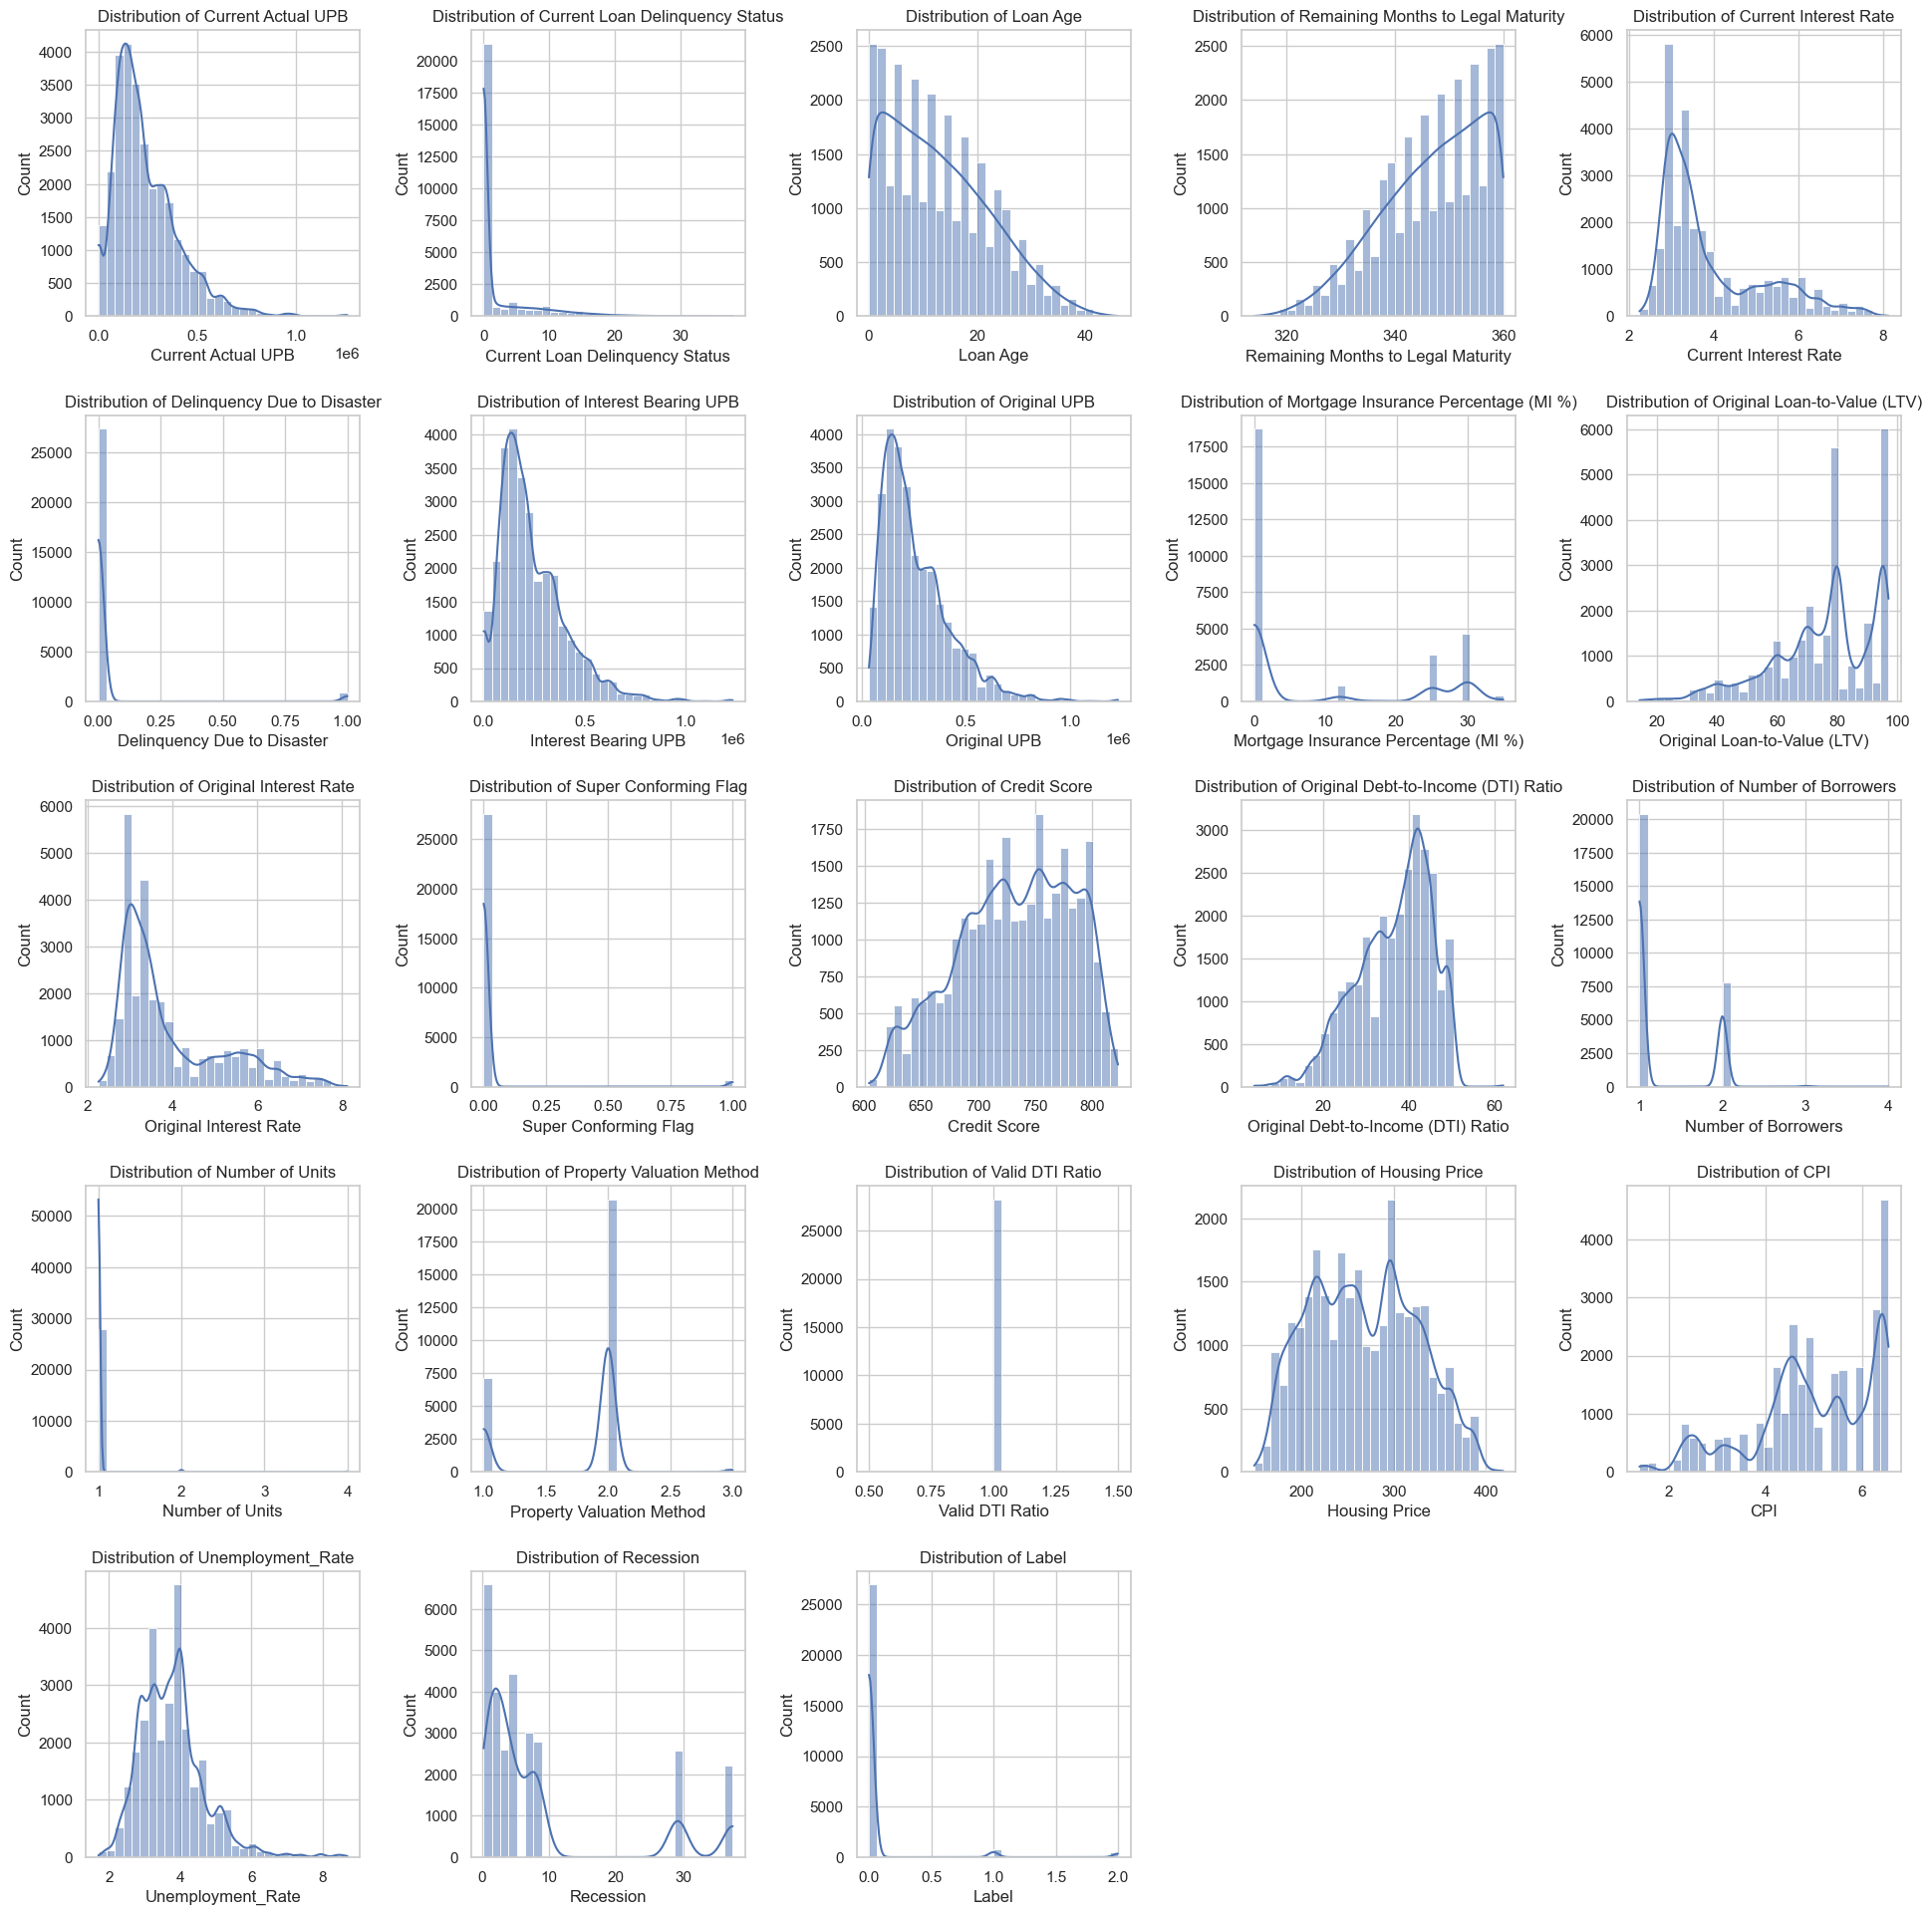

In [32]:
# Part 4: Label Engineering

numeric_columns = df_final.select_dtypes(include=[np.number]).columns

# Determine the grid size based on the number of numeric columns
n_cols = int(np.ceil(np.sqrt(len(numeric_columns))))
n_rows = int(np.ceil(len(numeric_columns) / n_cols))

# Create a subplot grid with enough rows and columns to fit all numeric columns
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 20))

# Adjust the space between plots
plt.tight_layout(pad=4)

# Flatten the array of axes for easy iteration
axes_flat = axes.flatten()

# Hide any extra subplots that won't have a plot
for i in range(len(numeric_columns), len(axes_flat)):
    axes_flat[i].axis('off')

# Iterate over columns and corresponding axes to plot
for i, col in enumerate(numeric_columns):
    ax = axes_flat[i]
    sns.histplot(df_final[col], kde=True, bins=30, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Count')

plt.show()  



columns_categorical = [
       'Channel',
       'Loan Purpose',
       'First Time Homebuyer Flag',
       'Occupancy Status',
       'Property Type',
       'Property Valuation Method']

# Perform one-hot encoding on the categorical columns
df_encoded = pd.get_dummies(df_final, columns=columns_categorical)

# Define paths for the CSV files on the desktop
final_csv_path = r"C:\dwaraka\github projects\Risk Analytics\Economic Data\df_final.csv"

# Output dataframes to CSV
df_encoded.to_csv(final_csv_path, index=False) 

In [34]:
# Part 5: Final Modeling Dataset Creation

# set up table for all loans
df = pd.read_csv(r"C:\dwaraka\github projects\Risk Analytics\Economic Data\df_final.csv")
df

# Define columns of different types
columns_orig = [
       'Original UPB', 'Mortgage Insurance Percentage (MI %)',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate', 'Super Conforming Flag', 'Credit Score',
       'Original Debt-to-Income (DTI) Ratio',
       'Number of Borrowers', 'Number of Units', 'Property Valuation Method',
       'Valid DTI Ratio', 'Channel_B', 'Channel_C', 'Channel_R', 'Loan Purpose_C',
       'Loan Purpose_N', 'Loan Purpose_P', 'First Time Homebuyer Flag_N',
       'First Time Homebuyer Flag_Y', 'Occupancy Status_I',
       'Occupancy Status_P', 'Occupancy Status_S', 'Property Type_CO',
       'Property Type_CP', 'Property Type_MH', 'Property Type_PU',
       'Property Type_SF']

columns_monthly = [
       'Monthly Reporting Period',
       'Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity',
       'Current Interest Rate', 'Delinquency Due to Disaster', 'Interest Bearing UPB',
       'Label']

columns_categorical_final = [
       'Valid DTI Ratio',
       'Super Conforming Flag',
       'Delinquency Due to Disaster',
       'Channel',
       'Loan Purpose',
       'First Time Homebuyer Flag',
       'Occupancy Status',
       'Property Type',
       'Property Valuation Method']

columns_continuous = [
       'Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age',
       'Remaining Months to Legal Maturity', 'Current Interest Rate',
       'Interest Bearing UPB', 'Original UPB',
       'Mortgage Insurance Percentage (MI %)', 'Original Loan-to-Value (LTV)',
       'Original Interest Rate',
       'Credit Score',
       'Original Debt-to-Income (DTI) Ratio', 'Number of Borrowers',
       'Number of Units','Valid DTI Ratio',
       'Housing Price', 'CPI', 'Unemployment_Rate', 'Recession'
]



# Automatically detect available columns to process
columns_to_process = [
    col for col in df.columns
    if col not in [
        'Loan Sequence Number',
        'Monthly Reporting Period',
        'label_target',
        'target_0&1'
    ]
    and df[col].dtype != 'object'
]


# Convert 'Monthly Reporting Period' to datetime type for proper sorting and manipulation
df['Monthly Reporting Period'] = pd.to_datetime(df['Monthly Reporting Period'])

# Sort the DataFrame by 'Loan Sequence Number' and 'Monthly Reporting Period' to ensure correct label alignment
df.sort_values(by=['Loan Sequence Number', 'Monthly Reporting Period'], inplace=True)

# Group by 'Loan Sequence Number' and shift 'Label' up by one to create the 'label_target'
df['label_target'] = df.groupby('Loan Sequence Number')['Label'].shift(-1)

# Drop rows where 'label_target' is NaN, indicating no subsequent month data for the same loan sequence number
df = df.dropna(subset=['label_target'])
df = df.drop(columns = {'Label'})
df = df.reset_index(drop = True)


df['target_0&1'] = df['label_target'].apply(lambda x: 0 if x in [0, 1] else 1)

def gaussian_weights(window_size, std_dev):
    # Creates a series of weights for a Gaussian distribution
    # The most recent time point (the last in the sequence) gets the highest weight
    return np.exp(-0.5 * ((np.arange(window_size) - window_size + 1) / std_dev) ** 2)

def apply_gaussian_rolling(group, window_size=12, std_dev=3):
    weights = gaussian_weights(window_size, std_dev)
    weighted_averages = pd.DataFrame(index=group.index)

    for column in columns_to_process:
        if column not in group.columns:
            continue

        padded_series = np.concatenate(
            (np.zeros(window_size - 1), group[column].to_numpy())
        )

        weighted_avg = np.convolve(
            padded_series,
            weights[::-1],
            mode='valid'
        ) / np.convolve(
            np.ones_like(padded_series),
            weights[::-1],
            mode='valid'
        )

        weighted_averages[column] = weighted_avg

    return weighted_averages


# Apply the function to each group and store the result
window_size = 12  # This includes the current month and the past 11 months
std_dev = 2  # Standard deviation for the Gaussian weights

# Apply the transformation and update the original columns
transformed_df = df.groupby('Loan Sequence Number').apply(lambda x: apply_gaussian_rolling(x, window_size, std_dev)).reset_index(level=0, drop=True)
transformed_df[['Loan Sequence Number', 'Monthly Reporting Period','label_target','target_0&1']] = df[['Loan Sequence Number', 'Monthly Reporting Period','label_target','target_0&1']]
transformed_df.head()

Current Actual UPB  Current Loan Delinquency Status  Loan Age  \
0        46896.386207                              0.0  0.000000   
1        87949.703293                              0.0  0.332598   
2       116100.282225                              0.0  0.958714   
3       131123.578539                              0.0  1.786561   
4       265080.991536                              0.0  0.000000   

   Remaining Months to Legal Maturity  Current Interest Rate  \
0                          119.735454               0.956221   
1                          225.069023               1.800082   
2                          297.066131               2.380060   
3                          335.110695               2.690499   
4                          119.735454               0.997463   

   Delinquency Due to Disaster  Interest Bearing UPB   Original UPB  \
0                          0.0          46896.386207   46896.386207   
1                          0.0          87949.703293   88282.301776   
2                          0.0         116100.282225  116726.397840   
3                          0.0         131123.578539  131951.425332   
4                          0.0         265080.991536  265413.590020   

   Mortgage Insurance Percentage (MI %)  Original Loan-to-Value (LTV)  \
0                              8.314962                     29.933864   
1                             15.652890                     56.350405   
2                             20.696170                     74.506211   
3                             23.395643                     84.224314   
4                              9.977955                     31.596856   

   Original Interest Rate  Super Conforming Flag  Credit Score  \
0                0.956221               0.000000    229.160355   
1                1.800082               0.000000    431.393659   
2                2.380060               0.000000    570.386441   
3                2.690499               0.000000    644.783915   
4                0.997463               0.332598    249.448863   

   Original Debt-to-Income (DTI) Ratio  Number of Borrowers  Number of Units  \
0                            11.640947             0.665197         0.332598   
1                            21.914047             1.252231         0.626116   
2                            28.974638             1.655694         0.827847   
3                            32.753900             1.871651         0.935826   
4                            15.964727             0.665197         0.332598   

   Valid DTI Ratio  Housing Price       CPI  Unemployment_Rate  Recession  \
0         0.332598      51.805712  0.462840           2.028851   0.066520   
1         0.626116      98.063353  0.875095           3.819305   0.125223   
2         0.827847     130.532939  1.222232           5.016606   0.165569   
3         0.935826     148.835660  1.636678           5.612665   0.220425   
4         0.332598      88.276861  0.462840           2.893607   0.066520   

   Channel_B  Channel_C  Channel_R  Loan Purpose_C  Loan Purpose_N  \
0   0.000000        0.0   0.332598             0.0             0.0   
1   0.000000        0.0   0.626116             0.0             0.0   
2   0.000000        0.0   0.827847             0.0             0.0   
3   0.000000        0.0   0.935826             0.0             0.0   
4   0.332598        0.0   0.000000             0.0             0.0   

   Loan Purpose_P  First Time Homebuyer Flag_N  First Time Homebuyer Flag_Y  \
0        0.332598                     0.332598                     0.000000   
1        0.626116                     0.626116                     0.000000   
2        0.827847                     0.827847                     0.000000   
3        0.935826                     0.935826                     0.000000   
4        0.332598                     0.000000                     0.332598   

   Occupancy Status_I  Occupancy Status_P  Occupancy Status_S  \
0                 0.0            0.332598